In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import glob
import scipy
import re
import random
import time
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from scipy.stats import ttest_ind
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.optimize import minimize
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.3f}".format

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_4_exports'
data_folder = '../all_data/Figure_4_data'

### Read in dataset

In [3]:
data = pd.read_pickle('../all_data/General_data/screen_active_data.pkl')
data

experiment_id   day  plate well_name Supp DNA_name  DNA_conc  \
0            eCM313 1.000  1.000       H12  S22     AqpZ     5.000   
1            eCM313 1.000  1.000       K12  S22     AqpZ     5.000   
2            eCM313 1.000  1.000        M5  S22     AqpZ     5.000   
3            eCM313 2.000  4.000        J2  S22     AqpZ     5.000   
4            eCM313 2.000  4.000       N22  S22     AqpZ     5.000   
...             ...   ...    ...       ...  ...      ...       ...   
33542        eCM313 2.000  3.000        A1  S22      Vol     5.000   
33543        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33544        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33545        eCM313 2.000  4.000        G6  S22      Vol     5.000   
33546        eCM313 2.000  4.000        G6  S22      Vol     5.000   

      Liposome_name  Liposome_conc     Mg  SecYE    K   WCE   PEG  pmol  \
0              DMPC              3  8.000  0.000   85  BL62 2.000 4.918   
1              DMPC              3  8.000  0.000   85  BL62 2.000 4.311   
2              DMPC              3  8.000  0.000   85  BL62 2.000 2.644   
3              DMPC              3  8.000  0.000   85  BL62 2.000 7.546   
4              DMPC              3  8.000  0.000   85  BL62 2.000 7.527   
...             ...            ...    ...    ...  ...   ...   ...   ...   
33542       no_lipo              0 20.000  1.250  135  BL62 2.000 1.149   
33543       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33544       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33545       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   
33546       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   

        rxn_id   label  
0        0.000  screen  
1        0.000  screen  
2        0.000  screen  
3        0.000  screen  
4        0.000  screen  
...        ...     ...  
33542 3966.000  screen  
33543 3862.000  screen  
33544 3966.000  screen  
33545 3862.000  screen  
33546 3966.000  screen  

[11197 rows x 17 columns]

In [4]:
sub_df = []
diff_threshold = 1

for rxn_id, df in data[data['label'] != 'other'].groupby('rxn_id'):
    t = df.copy()
    n_sub = np.mean(t[t['Liposome_conc'] == 0]['pmol'])
    
    t['pmol_sub_nolipo'] = t['pmol'] - n_sub
    l = t[t['Liposome_conc'] != 0]
    n = t[t['Liposome_conc'] == 0]
    pval = ttest_ind(l['pmol_sub_nolipo'],n['pmol_sub_nolipo'])[1]
    t['p-val'] = pval
    mean_diff = np.mean(l['pmol_sub_nolipo'])
    t['mean_diff'] = mean_diff
    if mean_diff > diff_threshold and pval < 0.05:
        t['score'] = 1
    else:
        t['score'] = 0
    sub_df.append(t)

sub_df = pd.concat(sub_df).reset_index(drop=True)
sub_df


experiment_id   day  plate well_name Supp DNA_name  DNA_conc  \
0            eCM313 1.000  1.000       H12  S22     AqpZ     5.000   
1            eCM313 1.000  1.000       K12  S22     AqpZ     5.000   
2            eCM313 1.000  1.000        M5  S22     AqpZ     5.000   
3            eCM313 2.000  4.000        J2  S22     AqpZ     5.000   
4            eCM313 2.000  4.000       N22  S22     AqpZ     5.000   
...             ...   ...    ...       ...  ...      ...       ...   
11192        eCM313 1.000  2.000       C22  S22      Vol     5.000   
11193        eCM313 1.000  2.000       N11  S22      Vol     5.000   
11194        eCM313 2.000  3.000        A1  S22      Vol     5.000   
11195        eCM313 2.000  4.000        B2  S22      Vol     5.000   
11196        eCM313 2.000  4.000        G6  S22      Vol     5.000   

      Liposome_name  Liposome_conc     Mg  ...    K   WCE   PEG  pmol  \
0              DMPC              3  8.000  ...   85  BL62 2.000 4.918   
1              DMPC              3  8.000  ...   85  BL62 2.000 4.311   
2              DMPC              3  8.000  ...   85  BL62 2.000 2.644   
3              DMPC              3  8.000  ...   85  BL62 2.000 7.546   
4              DMPC              3  8.000  ...   85  BL62 2.000 7.527   
...             ...            ...    ...  ...  ...   ...   ...   ...   
11192       no_lipo              0 20.000  ...  135  BL62 2.000 1.915   
11193       no_lipo              0 20.000  ...  135  BL62 2.000 1.529   
11194       no_lipo              0 20.000  ...  135  BL62 2.000 1.149   
11195       no_lipo              0 20.000  ...  135  BL62 2.000 1.265   
11196       no_lipo              0 20.000  ...  135  BL62 2.000 2.024   

        rxn_id   label pmol_sub_nolipo  p-val  mean_diff  score  
0        0.000  screen           2.688  0.006      3.159      1  
1        0.000  screen           2.081  0.006      3.159      1  
2        0.000  screen           0.414  0.006      3.159      1  
3        0.000  screen           5.316  0.006      3.159      1  
4        0.000  screen           5.297  0.006      3.159      1  
...        ...     ...             ...    ...        ...    ...  
11192 3966.000  screen           0.238  0.095     -0.415      0  
11193 3966.000  screen          -0.148  0.095     -0.415      0  
11194 3966.000  screen          -0.529  0.095     -0.415      0  
11195 3966.000  screen          -0.413  0.095     -0.415      0  
11196 3966.000  screen           0.347  0.095     -0.415      0  

[11197 rows x 21 columns]

In [5]:
sub_df = sub_df[sub_df['Liposome_name'] != 'no_lipo'].copy()


In [6]:
training_data = sub_df.copy()
# training_data = training_data[training_data['Liposome_name'] != 'no_lipo'].copy()

lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14}

training_data['lipid'] = training_data['Liposome_name'].apply(lambda x: lipo_dict[x])
training_data = training_data[['rxn_id','DNA_name','lipid','Mg','SecYE','K','PEG','pmol']].copy()
training_data

rxn_id DNA_name  lipid     Mg  SecYE    K   PEG  pmol
0        0.000     AqpZ     14  8.000  0.000   85 2.000 4.918
1        0.000     AqpZ     14  8.000  0.000   85 2.000 4.311
2        0.000     AqpZ     14  8.000  0.000   85 2.000 2.644
3        0.000     AqpZ     14  8.000  0.000   85 2.000 7.546
4        0.000     AqpZ     14  8.000  0.000   85 2.000 7.527
...        ...      ...    ...    ...    ...  ...   ...   ...
11186 3966.000      Vol     18 20.000  1.250  135 2.000 1.240
11187 3966.000      Vol     18 20.000  1.250  135 2.000 1.230
11188 3966.000      Vol     18 20.000  1.250  135 2.000 1.726
11189 3966.000      Vol     18 20.000  1.250  135 2.000 1.145
11190 3966.000      Vol     18 20.000  1.250  135 2.000 0.972

[5506 rows x 8 columns]

In [9]:
embeddings = pd.read_excel(f'{data_folder}/Fig4A-tSNE-rxn_embedding.xlsx')[['DNA_name','x_mean','y_mean']].rename(columns={'x_mean':'tsne_x','y_mean':'tsne_y'})
std_scale = ['tsne_x', 'tsne_y']
scaler = StandardScaler()
embeddings[std_scale] = scaler.fit_transform(np.array(embeddings[std_scale]))
embeddings

DNA_name  tsne_x  tsne_y
0      AqpZ   0.865   1.166
1       Aux  -1.488   0.909
2      B2AR   0.329  -0.385
3      B3AR  -0.319  -0.301
4      Beta   0.722  -0.930
..      ...     ...     ...
23    OR1D2  -0.765  -0.128
24    OR1E1  -0.387   0.296
25   OR2AG1  -0.502  -1.728
26  SecYE-G   0.248  -1.426
27      Vol   1.234   0.377

[28 rows x 3 columns]

In [10]:
prot_feat = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')
prot_feat

uniprot DNA_name     Organism  Length  tm_count   Mass
0   P60844     AqpZ      E. coli     231         6 23.703
1   F4HWB6      Aux  A. thaliana     472        10 51.877
2   P07550     B2AR   H. sapiens     413         7 46.459
3   P13945     B3AR   H. sapiens     408         7 43.519
4   Q9LTG0     Beta  A. thaliana     303         4 33.777
..     ...      ...          ...     ...       ...    ...
26  P0AGA2  SecYE-G      E. coli     443        12 48.512
27  Q5JW98      Vol   H. sapiens     314         4 35.060
28  Q8RXN3     PPT1  A. thaliana     408         8 44.200
29  Q96247    AuxT1  A. thaliana     485        11 54.100
30  Q8N6M3    FITM2   H. sapiens     262         6 29.900

[31 rows x 6 columns]

In [11]:
def add_one_hot(df,col_name):
    temp = df[[col_name]]

    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoder.fit(temp)

    encoded = one_hot_encoder.transform(temp)
    encoded = pd.DataFrame(data=encoded, columns=[col_name+'-'+c for c in one_hot_encoder.categories_])
    df = df.join(encoded)
    targets = list([col_name+'-'+c for c in one_hot_encoder.categories_])[0]
    original = [(t,) for t in targets]
    df = df.rename(columns=dict(zip(original,targets)))
    # df = df.drop(columns=col_name)
    return df


org_encoded = add_one_hot(prot_feat,'Organism')
dna_encoded = add_one_hot(org_encoded,'DNA_name')

dna_encoded.columns

Index(['uniprot', 'DNA_name', 'Organism', 'Length', 'tm_count', 'Mass',
       'Organism-A. thaliana', 'Organism-E. coli', 'Organism-H. sapiens',
       'DNA_name-AqpZ', 'DNA_name-Aux', 'DNA_name-AuxT1', 'DNA_name-B2AR',
       'DNA_name-B3AR', 'DNA_name-Beta', 'DNA_name-CD47', 'DNA_name-CD63',
       'DNA_name-CD81', 'DNA_name-CD9', 'DNA_name-CML1', 'DNA_name-CRCM',
       'DNA_name-CaM', 'DNA_name-Cx43', 'DNA_name-Dia', 'DNA_name-FFAR4',
       'DNA_name-FITM2', 'DNA_name-Glut', 'DNA_name-InP', 'DNA_name-Mito',
       'DNA_name-Mol', 'DNA_name-MscL', 'DNA_name-MtlA', 'DNA_name-Neu',
       'DNA_name-OR1A1', 'DNA_name-OR1D2', 'DNA_name-OR1E1', 'DNA_name-OR2AG1',
       'DNA_name-PPT1', 'DNA_name-SecYE-G', 'DNA_name-Vol'],
      dtype='object')

In [12]:
all_features = training_data.set_index('DNA_name').join(dna_encoded.set_index('DNA_name')).join(embeddings.set_index('DNA_name')).reset_index()
all_features

DNA_name   rxn_id  lipid     Mg  SecYE    K   PEG  pmol uniprot  \
0        AqpZ    0.000     14  8.000  0.000   85 2.000 4.918  P60844   
1        AqpZ    0.000     14  8.000  0.000   85 2.000 4.311  P60844   
2        AqpZ    0.000     14  8.000  0.000   85 2.000 2.644  P60844   
3        AqpZ    0.000     14  8.000  0.000   85 2.000 7.546  P60844   
4        AqpZ    0.000     14  8.000  0.000   85 2.000 7.527  P60844   
...       ...      ...    ...    ...    ...  ...   ...   ...     ...   
5501      Vol 3966.000     18 20.000  1.250  135 2.000 1.240  Q5JW98   
5502      Vol 3966.000     18 20.000  1.250  135 2.000 1.230  Q5JW98   
5503      Vol 3966.000     18 20.000  1.250  135 2.000 1.726  Q5JW98   
5504      Vol 3966.000     18 20.000  1.250  135 2.000 1.145  Q5JW98   
5505      Vol 3966.000     18 20.000  1.250  135 2.000 0.972  Q5JW98   

        Organism  ...  DNA_name-Neu  DNA_name-OR1A1  DNA_name-OR1D2  \
0        E. coli  ...         0.000           0.000           0.000   
1        E. coli  ...         0.000           0.000           0.000   
2        E. coli  ...         0.000           0.000           0.000   
3        E. coli  ...         0.000           0.000           0.000   
4        E. coli  ...         0.000           0.000           0.000   
...          ...  ...           ...             ...             ...   
5501  H. sapiens  ...         0.000           0.000           0.000   
5502  H. sapiens  ...         0.000           0.000           0.000   
5503  H. sapiens  ...         0.000           0.000           0.000   
5504  H. sapiens  ...         0.000           0.000           0.000   
5505  H. sapiens  ...         0.000           0.000           0.000   

      DNA_name-OR1E1  DNA_name-OR2AG1  DNA_name-PPT1  DNA_name-SecYE-G  \
0              0.000            0.000          0.000             0.000   
1              0.000            0.000          0.000             0.000   
2              0.000            0.000          0.000             0.000   
3              0.000            0.000          0.000             0.000   
4              0.000            0.000          0.000             0.000   
...              ...              ...            ...               ...   
5501           0.000            0.000          0.000             0.000   
5502           0.000            0.000          0.000             0.000   
5503           0.000            0.000          0.000             0.000   
5504           0.000            0.000          0.000             0.000   
5505           0.000            0.000          0.000             0.000   

      DNA_name-Vol  tsne_x  tsne_y  
0            0.000   0.865   1.166  
1            0.000   0.865   1.166  
2            0.000   0.865   1.166  
3            0.000   0.865   1.166  
4            0.000   0.865   1.166  
...            ...     ...     ...  
5501         1.000   1.234   0.377  
5502         1.000   1.234   0.377  
5503         1.000   1.234   0.377  
5504         1.000   1.234   0.377  
5505         1.000   1.234   0.377  

[5506 rows x 49 columns]

### Min-Max scaling

In [13]:
data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
scalerX = MinMaxScaler()
X_bounded = scalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id']
data_bounded = data_bounded.drop_duplicates().set_index('rxn_id')
data_bounded

Mg  SecYE     K   PEG  lipid
rxn_id                                  
0.000    0.000  0.000 0.000 1.000  0.000
1.000    0.000  0.000 0.000 0.000  0.000
2.000    0.000  0.000 0.000 1.000  0.000
3.000    0.000  0.000 0.500 1.000  0.000
4.000    0.000  0.000 0.500 0.000  0.000
...        ...    ...   ...   ...    ...
3953.000 1.000  0.000 0.500 1.000  1.000
3954.000 1.000  0.000 1.000 0.000  1.000
3964.000 1.000  0.500 1.000 0.000  1.000
3965.000 1.000  1.000 0.000 1.000  1.000
3966.000 1.000  1.000 0.500 1.000  1.000

[1251 rows x 5 columns]

### Standard Scaling

In [14]:
std_scale = ['Length', 'tm_count']

data_scaled = all_features[std_scale]
X_scaled = np.array(data_scaled)
scalerX = StandardScaler()
X_scaled = scalerX.fit_transform(X_scaled)
data_scaled = pd.DataFrame(X_scaled,columns=data_scaled.columns)
data_scaled['rxn_id'] = all_features['rxn_id']
data_scaled = data_scaled.drop_duplicates().set_index('rxn_id')
data_scaled

Length  tm_count
rxn_id                    
0.000     -0.949     0.006
1.000     -0.949     0.006
2.000     -0.949     0.006
3.000     -0.949     0.006
4.000     -0.949     0.006
...          ...       ...
3953.000  -0.215    -0.804
3954.000  -0.215    -0.804
3964.000  -0.215    -0.804
3965.000  -0.215    -0.804
3966.000  -0.215    -0.804

[1251 rows x 2 columns]

In [15]:
y_col = 'pmol'

transformed = []
scaler_dict = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id','label']].set_index('rxn_id')
transformed

label
rxn_id         
0.000    -0.570
0.000    -0.656
0.000    -0.891
0.000    -0.201
0.000    -0.203
...         ...
3966.000 -0.656
3966.000 -0.665
3966.000 -0.194
3966.000 -0.745
3966.000 -0.910

[5506 rows x 1 columns]

In [16]:
encoded_cols = [c for c in all_features.columns if 'DNA' in c or 'Organism' in c]
encoded_cols = all_features[encoded_cols+['rxn_id']].drop_duplicates().set_index('rxn_id')
encoded_cols

DNA_name    Organism  Organism-A. thaliana  Organism-E. coli  \
rxn_id                                                                  
0.000        AqpZ     E. coli                 0.000             1.000   
1.000        AqpZ     E. coli                 0.000             1.000   
2.000        AqpZ     E. coli                 0.000             1.000   
3.000        AqpZ     E. coli                 0.000             1.000   
4.000        AqpZ     E. coli                 0.000             1.000   
...           ...         ...                   ...               ...   
3953.000      Vol  H. sapiens                 0.000             0.000   
3954.000      Vol  H. sapiens                 0.000             0.000   
3964.000      Vol  H. sapiens                 0.000             0.000   
3965.000      Vol  H. sapiens                 0.000             0.000   
3966.000      Vol  H. sapiens                 0.000             0.000   

          Organism-H. sapiens  DNA_name-AqpZ  DNA_name-Aux  DNA_name-AuxT1  \
rxn_id                                                                       
0.000                   0.000          1.000         0.000           0.000   
1.000                   0.000          1.000         0.000           0.000   
2.000                   0.000          1.000         0.000           0.000   
3.000                   0.000          1.000         0.000           0.000   
4.000                   0.000          1.000         0.000           0.000   
...                       ...            ...           ...             ...   
3953.000                1.000          0.000         0.000           0.000   
3954.000                1.000          0.000         0.000           0.000   
3964.000                1.000          0.000         0.000           0.000   
3965.000                1.000          0.000         0.000           0.000   
3966.000                1.000          0.000         0.000           0.000   

          DNA_name-B2AR  DNA_name-B3AR  ...  DNA_name-MscL  DNA_name-MtlA  \
rxn_id                                  ...                                 
0.000             0.000          0.000  ...          0.000          0.000   
1.000             0.000          0.000  ...          0.000          0.000   
2.000             0.000          0.000  ...          0.000          0.000   
3.000             0.000          0.000  ...          0.000          0.000   
4.000             0.000          0.000  ...          0.000          0.000   
...                 ...            ...  ...            ...            ...   
3953.000          0.000          0.000  ...          0.000          0.000   
3954.000          0.000          0.000  ...          0.000          0.000   
3964.000          0.000          0.000  ...          0.000          0.000   
3965.000          0.000          0.000  ...          0.000          0.000   
3966.000          0.000          0.000  ...          0.000          0.000   

          DNA_name-Neu  DNA_name-OR1A1  DNA_name-OR1D2  DNA_name-OR1E1  \
rxn_id                                                                   
0.000            0.000           0.000           0.000           0.000   
1.000            0.000           0.000           0.000           0.000   
2.000            0.000           0.000           0.000           0.000   
3.000            0.000           0.000           0.000           0.000   
4.000            0.000           0.000           0.000           0.000   
...                ...             ...             ...             ...   
3953.000         0.000           0.000           0.000           0.000   
3954.000         0.000           0.000           0.000           0.000   
3964.000         0.000           0.000           0.000           0.000   
3965.000         0.000           0.000           0.000           0.000   
3966.000         0.000           0.000           0.000           0.000   

          DNA_name-OR2AG1  DNA_name-PPT1  DNA_name-SecYE-G  DNA_name-Vol  
rxn_

In [17]:
norm_data = data_bounded.join(data_scaled).join(encoded_cols).join(transformed).reset_index()
norm_data = norm_data.set_index('DNA_name').join(embeddings.set_index('DNA_name')).reset_index()
norm_data

DNA_name   rxn_id    Mg  SecYE     K   PEG  lipid  Length  tm_count  \
0        AqpZ    0.000 0.000  0.000 0.000 1.000  0.000  -0.949     0.006   
1        AqpZ    0.000 0.000  0.000 0.000 1.000  0.000  -0.949     0.006   
2        AqpZ    0.000 0.000  0.000 0.000 1.000  0.000  -0.949     0.006   
3        AqpZ    0.000 0.000  0.000 0.000 1.000  0.000  -0.949     0.006   
4        AqpZ    0.000 0.000  0.000 0.000 1.000  0.000  -0.949     0.006   
...       ...      ...   ...    ...   ...   ...    ...     ...       ...   
5501      Vol 3966.000 1.000  1.000 0.500 1.000  1.000  -0.215    -0.804   
5502      Vol 3966.000 1.000  1.000 0.500 1.000  1.000  -0.215    -0.804   
5503      Vol 3966.000 1.000  1.000 0.500 1.000  1.000  -0.215    -0.804   
5504      Vol 3966.000 1.000  1.000 0.500 1.000  1.000  -0.215    -0.804   
5505      Vol 3966.000 1.000  1.000 0.500 1.000  1.000  -0.215    -0.804   

        Organism  ...  DNA_name-OR1A1  DNA_name-OR1D2  DNA_name-OR1E1  \
0        E. coli  ...           0.000           0.000           0.000   
1        E. coli  ...           0.000           0.000           0.000   
2        E. coli  ...           0.000           0.000           0.000   
3        E. coli  ...           0.000           0.000           0.000   
4        E. coli  ...           0.000           0.000           0.000   
...          ...  ...             ...             ...             ...   
5501  H. sapiens  ...           0.000           0.000           0.000   
5502  H. sapiens  ...           0.000           0.000           0.000   
5503  H. sapiens  ...           0.000           0.000           0.000   
5504  H. sapiens  ...           0.000           0.000           0.000   
5505  H. sapiens  ...           0.000           0.000           0.000   

      DNA_name-OR2AG1  DNA_name-PPT1  DNA_name-SecYE-G  DNA_name-Vol  label  \
0               0.000          0.000             0.000         0.000 -0.570   
1               0.000          0.000             0.000         0.000 -0.656   
2               0.000          0.000             0.000         0.000 -0.891   
3               0.000          0.000             0.000         0.000 -0.201   
4               0.000          0.000             0.000         0.000 -0.203   
...               ...            ...               ...           ...    ...   
5501            0.000          0.000             0.000         1.000 -0.656   
5502            0.000          0.000             0.000         1.000 -0.665   
5503            0.000          0.000             0.000         1.000 -0.194   
5504            0.000          0.000             0.000         1.000 -0.745   
5505            0.000          0.000             0.000         1.000 -0.910   

      tsne_x  tsne_y  
0      0.865   1.166  
1      0.865   1.166  
2      0.865   1.166  
3      0.865   1.166  
4      0.865   1.166  
...      ...     ...  
5501   1.234   0.377  
5502   1.234   0.377  
5503   1.234   0.377  
5504   1.234   0.377  
5505   1.234   0.377  

[5506 rows x 47 columns]

In [18]:
rxn_features = ['Mg','SecYE','K','PEG','lipid']
simple_prot = ['Length','tm_count']
org_features = [c for c in norm_data.columns if 'Organism-' in c]
dna_features = [c for c in norm_data.columns if 'DNA_name-' in c]

tsne_features = [c for c in norm_data.columns if 'tsne' in c]

In [19]:
col_dict = {
    'no_prot_features':rxn_features,
    'dna_encoded':rxn_features+dna_features,
    'tsne':rxn_features+tsne_features,
}

In [20]:
def make_model(learning_rate=1e-3,nodes=[256,128,64,32,16]):
    temp = [tf.keras.layers.Dense(n, activation='relu') for n in nodes] + [tf.keras.layers.Dense(1, activation="linear")]
    model = tf.keras.Sequential([*temp])
    
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

def prep_data(train,test):
    to_drop = 'rxn_id'
    train = train.drop(columns=to_drop)
    test = test.drop(columns=to_drop)
    
    target = 'label'
    cols = [col for col in train.columns.values if col != target]

    X_train = np.array(train[cols])
    y_train = train[target].values.reshape(-1, 1)

    X_test = np.array(test[cols])
    y_test = test[target].values.reshape(-1, 1)
    
    return train,test,X_train,X_test,y_train,y_test

In [21]:
all_features['DNA_name'].unique()

array(['AqpZ', 'Aux', 'B2AR', 'B3AR', 'Beta', 'CD47', 'CD63', 'CD81',
       'CD9', 'CML1', 'CRCM', 'CaM', 'Cx43', 'Dia', 'FFAR4', 'Glut',
       'InP', 'Mito', 'Mol', 'MscL', 'MtlA', 'Neu', 'OR1A1', 'OR1D2',
       'OR1E1', 'OR2AG1', 'SecYE-G', 'Vol'], dtype=object)

In [22]:

layer_arr = []

num_layers = [6]

nodes = [2**i for i in range(4,12)][::-1]
start = 'low'
for num in num_layers:
    if start == 'high':
        layers = [nodes[i] for i in range(num)]
    elif start == 'low':
        layers = [nodes[len(nodes)-i-1] for i in range(num)][::-1]
    layer_arr.append(layers)


learning_rates = [1e-3]
batch_sizes = [50]
ensemble = col_dict.keys()

holdout = all_features['DNA_name'].unique().tolist()

folds = range(5)

combinations = list(itertools.product(holdout,ensemble,folds,batch_sizes,learning_rates,layer_arr))
combinations = pd.DataFrame(combinations,columns=['holdout','ensemble','fold','batch','learning_rate','nodes']).reset_index().rename(columns={'index':'model_id'}).set_index('model_id')
combinations = combinations.reset_index()
combinations['cols'] = combinations['ensemble'].apply(lambda x: col_dict[x])
combinations


def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]

all_test = []

for holdout, hold_df in combinations.groupby('holdout'):    
    holdout_data = norm_data[norm_data['DNA_name'] != holdout]
    subset_ids = holdout_data['rxn_id'].drop_duplicates().tolist()
    
    test_ids = partition(subset_ids,len(folds))
    test_ids = pd.DataFrame(test_ids,columns=['fold','test_ids'])
    test_ids['train_ids'] = test_ids['test_ids'].apply(get_train_ids,available_ids=subset_ids)
    test_ids['holdout'] = holdout
    all_test.append(test_ids)
    
all_test = pd.concat(all_test)

combinations = combinations.set_index(['holdout','fold']).join(all_test.set_index(['holdout','fold'])).reset_index()

combinations

holdout  fold  model_id          ensemble  batch  learning_rate  \
0      AqpZ     0         0  no_prot_features     50          0.001   
1      AqpZ     1         1  no_prot_features     50          0.001   
2      AqpZ     2         2  no_prot_features     50          0.001   
3      AqpZ     3         3  no_prot_features     50          0.001   
4      AqpZ     4         4  no_prot_features     50          0.001   
..      ...   ...       ...               ...    ...            ...   
415     Vol     0       415              tsne     50          0.001   
416     Vol     1       416              tsne     50          0.001   
417     Vol     2       417              tsne     50          0.001   
418     Vol     3       418              tsne     50          0.001   
419     Vol     4       419              tsne     50          0.001   

                           nodes                                        cols  \
0    [512, 256, 128, 64, 32, 16]                  [Mg, SecYE, K, PEG, lipid]   
1    [512, 256, 128, 64, 32, 16]                  [Mg, SecYE, K, PEG, lipid]   
2    [512, 256, 128, 64, 32, 16]                  [Mg, SecYE, K, PEG, lipid]   
3    [512, 256, 128, 64, 32, 16]                  [Mg, SecYE, K, PEG, lipid]   
4    [512, 256, 128, 64, 32, 16]                  [Mg, SecYE, K, PEG, lipid]   
..                           ...                                         ...   
415  [512, 256, 128, 64, 32, 16]  [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
416  [512, 256, 128, 64, 32, 16]  [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
417  [512, 256, 128, 64, 32, 16]  [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
418  [512, 256, 128, 64, 32, 16]  [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
419  [512, 256, 128, 64, 32, 16]  [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   

                                              test_ids  \
0    [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
1    [2793.0, 1528.0, 1900.0, 3401.0, 530.0, 2412.0...   
2    [1889.0, 1370.0, 3602.0, 1580.0, 1884.0, 3530....   
3    [1887.0, 521.0, 603.0, 2821.0, 1292.0, 3842.0,...   
4    [3917.0, 3078.0, 1455.0, 2960.0, 910.0, 3028.0...   
..                                                 ...   
415  [2307.0, 3332.0, 1883.0, 660.0, 178.0, 2801.0,...   
416  [2997.0, 205.0, 540.0, 1302.0, 543.0, 2342.0, ...   
417  [2942.0, 2382.0, 2434.0, 1891.0, 1403.0, 3076....   
418  [544.0, 2831.0, 158.0, 1004.0, 2306.0, 1538.0,...   
419  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   

                                             train_ids  
0    [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....  
1    [2831.0, 1889.0, 1887.0, 3917.0, 2998.0, 1370....  
2    [2831.0, 2793.0, 1887.0, 3917.0, 2998.0, 1528....  
3    [2831.0, 2793.0, 1889.0, 3917.0, 2998.0, 1528....  
4    [2831.0, 2793.0, 1889.0, 1887.0, 2998.0, 1528....  
..                                                 ...  
415  [2997.0, 2942.0, 544.0, 1799.0, 205.0, 2382.0,...  
416  [2307.0, 2942.0, 544.0, 1799.0, 3332.0, 2382.0...  
417  [2307.0, 2997.0, 544.0, 1799.0, 3332.0, 205.0,...  
418  [2307.0, 2997.0, 2942.0, 1799.0, 3332.0, 205.0...  
419  [2307.0, 2997.0, 2942.0, 544.0, 3332.0, 205.0,...  

[420 rows x 10 columns]

In [43]:
time_start = time.strftime("%Y-%m-%d_%H-%M", time.gmtime())
dir_name = f'no_prot_all-regression-models {time_start}'
dir_path = f'./{dir_name}'
# dir_path = 'regression-models 2023-08-15_21-58'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
else:
    print('Directory already exists - Overwriting data')
    
combinations.to_pickle(f'{dir_path}/model_id_info.pkl')

    
EPOCHS = 100

for i,row in combinations.iterrows():
    if os.path.exists(f'{dir_path}/model-{row.model_id}'):
        print(f'{dir_path}/model-{row.model_id} already trained')
        continue
    print(f'\n\n{row.model_id}: {round(i/len(combinations)*100,1)}%, ensemble: {row.ensemble}, nodes: {row.nodes}, holdout: {row.holdout}')
        
    t = norm_data[row.cols + ['rxn_id','label']]
    train = t[t['rxn_id'].isin(row['train_ids'])]
    test = t[t['rxn_id'].isin(row['test_ids'])]
    
    train,test,X_train,X_test,y_train,y_test = prep_data(train,test)
    model = make_model(learning_rate=row['learning_rate'],nodes=row['nodes'])

    history = model.fit(
            X_train,
            y_train,
            batch_size=int(row['batch']),
            epochs=EPOCHS,
            validation_data=(X_test, y_test))

    model.save(f'{dir_path}/model-{row.model_id}')
        
    print('current time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))

print('Start time: ',time_start)
print('End time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))



0: 0.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 6ms/step - loss: 0.7253 - val_loss: 0.7122
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6988 - val_loss: 0.7015
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6869 - val_loss: 0.6949
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6764 - val_loss: 0.6708
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6587 - val_loss: 0.6735
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6531 - val_loss: 0.6781
Epoch 7/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6454 - val_loss: 0.6576
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6427 - val_loss: 0.6649
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6379 - val_loss: 0.6815
Epoch 10/100
83/83 [

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-0\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-0\assets


current time:  2023-08-18_05-33


5: 0.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 3ms/step - loss: 0.7042 - val_loss: 0.6907
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6128 - val_loss: 0.6300
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5555 - val_loss: 0.5919
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5227 - val_loss: 0.5935
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5030 - val_loss: 0.6221
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4859 - val_loss: 0.5797
Epoch 7/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4776 - val_loss: 0.5818
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4663 - val_loss: 0.5849
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4542 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-5\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-5\assets


current time:  2023-08-18_05-34


10: 0.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 3ms/step - loss: 0.6593 - val_loss: 0.6127
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6057 - val_loss: 0.5957
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5808 - val_loss: 0.6008
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5639 - val_loss: 0.5636
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5578 - val_loss: 0.5710
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5456 - val_loss: 0.5629
Epoch 7/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5342 - val_loss: 0.5698
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5226 - val_loss: 0.5750
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5158 - val_loss: 0.5

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-10\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-10\assets


current time:  2023-08-18_05-34


1: 0.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 3ms/step - loss: 0.7119 - val_loss: 0.7403
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6863 - val_loss: 0.7394
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6703 - val_loss: 0.7319
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6601 - val_loss: 0.7056
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6482 - val_loss: 0.6988
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6423 - val_loss: 0.6945
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6425 - val_loss: 0.6958
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6398 - val_loss: 0.6878
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6339 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-1\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-1\assets


current time:  2023-08-18_05-34


6: 1.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6826 - val_loss: 0.6936
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5910 - val_loss: 0.6547
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5414 - val_loss: 0.6500
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5110 - val_loss: 0.6460
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4933 - val_loss: 0.6303
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4817 - val_loss: 0.6176
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4786 - val_loss: 0.6288
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4607 - val_loss: 0.6200
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4538 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-6\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-6\assets


current time:  2023-08-18_05-35


11: 1.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6379 - val_loss: 0.6540
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5863 - val_loss: 0.6506
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5656 - val_loss: 0.6189
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5492 - val_loss: 0.6247
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5383 - val_loss: 0.6245
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5276 - val_loss: 0.6042
Epoch 7/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5129 - val_loss: 0.5998
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5077 - val_loss: 0.6000
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5030 - val_loss: 0.6

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-11\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-11\assets


current time:  2023-08-18_05-35


2: 1.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 3ms/step - loss: 0.7312 - val_loss: 0.6996
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.7075 - val_loss: 0.6455
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6814 - val_loss: 0.6611
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6699 - val_loss: 0.6753
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6553 - val_loss: 0.6519
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6472 - val_loss: 0.6543
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6463 - val_loss: 0.6420
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6414 - val_loss: 0.6367
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6381 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-2\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-2\assets


current time:  2023-08-18_05-35


7: 1.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7075 - val_loss: 0.6311
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6026 - val_loss: 0.6112
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5505 - val_loss: 0.6243
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5225 - val_loss: 0.6240
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5018 - val_loss: 0.6015
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4834 - val_loss: 0.6140
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4768 - val_loss: 0.6111
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4678 - val_loss: 0.6074
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4579 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-7\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-7\assets


current time:  2023-08-18_05-36


12: 1.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6725 - val_loss: 0.6265
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5956 - val_loss: 0.6037
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5721 - val_loss: 0.5989
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5597 - val_loss: 0.5948
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5403 - val_loss: 0.5919
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5328 - val_loss: 0.5838
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5297 - val_loss: 0.5610
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5080 - val_loss: 0.5919
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5068 - val_loss: 0.5

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-12\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-12\assets


current time:  2023-08-18_05-36


3: 2.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7109 - val_loss: 0.7569
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6880 - val_loss: 0.7552
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6693 - val_loss: 0.7553
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6601 - val_loss: 0.7154
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6470 - val_loss: 0.7182
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6446 - val_loss: 0.6999
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6370 - val_loss: 0.7038
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6277 - val_loss: 0.7049
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6307 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-3\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-3\assets


current time:  2023-08-18_05-37


8: 2.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6815 - val_loss: 0.7048
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5878 - val_loss: 0.6651
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5376 - val_loss: 0.6630
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5184 - val_loss: 0.6632
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5024 - val_loss: 0.6558
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4820 - val_loss: 0.6697
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4711 - val_loss: 0.6394
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4620 - val_loss: 0.6433
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4574 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-8\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-8\assets


current time:  2023-08-18_05-37


13: 2.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6722 - val_loss: 0.6919
Epoch 2/100
83/83 [==============================] - 0s 4ms/step - loss: 0.5971 - val_loss: 0.6581
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5780 - val_loss: 0.6517
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5712 - val_loss: 0.6463
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5592 - val_loss: 0.6300
Epoch 6/100
83/83 [==============================] - 0s 4ms/step - loss: 0.5415 - val_loss: 0.6346
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5335 - val_loss: 0.6085
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5238 - val_loss: 0.6197
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5175 - val_loss: 0.6

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-13\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-13\assets


current time:  2023-08-18_05-38


4: 2.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7333 - val_loss: 0.6770
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.7097 - val_loss: 0.6489
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6881 - val_loss: 0.6565
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6760 - val_loss: 0.6625
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6671 - val_loss: 0.6504
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6548 - val_loss: 0.6510
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6539 - val_loss: 0.6594
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6486 - val_loss: 0.6401
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6439 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-4\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-4\assets


current time:  2023-08-18_05-38


9: 3.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7076 - val_loss: 0.6389
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6095 - val_loss: 0.6014
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5540 - val_loss: 0.5645
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5320 - val_loss: 0.5650
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5052 - val_loss: 0.5862
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4985 - val_loss: 0.5752
Epoch 7/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4777 - val_loss: 0.5813
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4631 - val_loss: 0.5766
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4600 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-9\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-9\assets


current time:  2023-08-18_05-38


14: 3.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: AqpZ
Epoch 1/100
83/83 [==============================] - 1s 3ms/step - loss: 0.6717 - val_loss: 0.5729
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6135 - val_loss: 0.5491
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5918 - val_loss: 0.5557
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5765 - val_loss: 0.5560
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5714 - val_loss: 0.5516
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5564 - val_loss: 0.5525
Epoch 7/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5418 - val_loss: 0.5347
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5306 - val_loss: 0.5364
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5312 - val_loss: 0.5

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-14\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-14\assets


current time:  2023-08-18_05-39


15: 3.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7250 - val_loss: 0.6974
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6913 - val_loss: 0.6813
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6777 - val_loss: 0.6679
Epoch 4/100
85/85 [==============================] - 0s 4ms/step - loss: 0.6711 - val_loss: 0.6605
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6600 - val_loss: 0.6445
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6551 - val_loss: 0.6412
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6497 - val_loss: 0.6412
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6378 - val_loss: 0.6355
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6334 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-15\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-15\assets


current time:  2023-08-18_05-39


20: 3.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6947 - val_loss: 0.6492
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6034 - val_loss: 0.6188
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5406 - val_loss: 0.6091
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5161 - val_loss: 0.6029
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4859 - val_loss: 0.5969
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4701 - val_loss: 0.6049
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4618 - val_loss: 0.6033
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4487 - val_loss: 0.6007
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4435 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-20\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-20\assets


current time:  2023-08-18_05-40


25: 4.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6626 - val_loss: 0.5942
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5817 - val_loss: 0.5950
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5608 - val_loss: 0.5924
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5497 - val_loss: 0.5846
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5336 - val_loss: 0.5980
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5240 - val_loss: 0.5807
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5123 - val_loss: 0.5777
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5097 - val_loss: 0.5870
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4988 - val_loss: 0.57

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-25\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-25\assets


current time:  2023-08-18_05-40


16: 4.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.6923 - val_loss: 0.7345
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6692 - val_loss: 0.7205
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6548 - val_loss: 0.7166
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6424 - val_loss: 0.7215
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6340 - val_loss: 0.7122
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6237 - val_loss: 0.7065
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6196 - val_loss: 0.7124
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6227 - val_loss: 0.6977
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6154 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-16\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-16\assets


current time:  2023-08-18_05-40


21: 4.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 5ms/step - loss: 0.6750 - val_loss: 0.7130
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 0.5658 - val_loss: 0.6536
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 0.5245 - val_loss: 0.6796
Epoch 4/100
85/85 [==============================] - 0s 4ms/step - loss: 0.5038 - val_loss: 0.6124
Epoch 5/100
85/85 [==============================] - 0s 4ms/step - loss: 0.4870 - val_loss: 0.6250
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 0.4642 - val_loss: 0.6258
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 0.4536 - val_loss: 0.6166
Epoch 8/100
85/85 [==============================] - 0s 4ms/step - loss: 0.4489 - val_loss: 0.6194
Epoch 9/100
85/85 [==============================] - 0s 4ms/step - loss: 0.4338 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-21\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-21\assets


current time:  2023-08-18_05-41


26: 4.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6304 - val_loss: 0.6643
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 0.5636 - val_loss: 0.6575
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5466 - val_loss: 0.6612
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5378 - val_loss: 0.6361
Epoch 5/100
85/85 [==============================] - 0s 4ms/step - loss: 0.5166 - val_loss: 0.6390
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5026 - val_loss: 0.6513
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4924 - val_loss: 0.6229
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4905 - val_loss: 0.6202
Epoch 9/100
85/85 [==============================] - 0s 4ms/step - loss: 0.4808 - val_loss: 0.62

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-26\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-26\assets


current time:  2023-08-18_05-41


17: 5.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7224 - val_loss: 0.6716
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6857 - val_loss: 0.6466
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6723 - val_loss: 0.6699
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6535 - val_loss: 0.6443
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6459 - val_loss: 0.6439
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6406 - val_loss: 0.6374
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6366 - val_loss: 0.6161
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6325 - val_loss: 0.6284
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6302 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-17\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-17\assets


current time:  2023-08-18_05-42


22: 5.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6834 - val_loss: 0.6246
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5740 - val_loss: 0.5852
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5295 - val_loss: 0.5838
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5062 - val_loss: 0.6350
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4858 - val_loss: 0.5902
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4773 - val_loss: 0.5714
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4673 - val_loss: 0.5989
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4541 - val_loss: 0.5779
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4502 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-22\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-22\assets


current time:  2023-08-18_05-42


27: 5.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6731 - val_loss: 0.5681
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6015 - val_loss: 0.5568
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5683 - val_loss: 0.5681
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5605 - val_loss: 0.5518
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5386 - val_loss: 0.5492
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5278 - val_loss: 0.5642
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5188 - val_loss: 0.5576
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5038 - val_loss: 0.5228
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5031 - val_loss: 0.53

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-27\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-27\assets


current time:  2023-08-18_05-43


18: 5.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7064 - val_loss: 0.7008
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6784 - val_loss: 0.6959
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6725 - val_loss: 0.7009
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6553 - val_loss: 0.6858
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6464 - val_loss: 0.6883
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6418 - val_loss: 0.6726
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6335 - val_loss: 0.6579
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6331 - val_loss: 0.6952
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6274 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-18\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-18\assets


current time:  2023-08-18_05-43


23: 6.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6891 - val_loss: 0.6272
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6051 - val_loss: 0.5834
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5580 - val_loss: 0.5514
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5377 - val_loss: 0.5893
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5108 - val_loss: 0.5488
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4958 - val_loss: 0.5542
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4770 - val_loss: 0.5398
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4754 - val_loss: 0.5318
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4610 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-23\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-23\assets


current time:  2023-08-18_05-44


28: 6.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.6670 - val_loss: 0.6127
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5899 - val_loss: 0.5729
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5732 - val_loss: 0.5664
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5593 - val_loss: 0.5691
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5485 - val_loss: 0.5492
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5272 - val_loss: 0.5553
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5228 - val_loss: 0.5481
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5113 - val_loss: 0.5633
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5087 - val_loss: 0.55

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-28\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-28\assets


current time:  2023-08-18_05-44


19: 6.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7022 - val_loss: 0.6775
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6816 - val_loss: 0.6776
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6688 - val_loss: 0.6745
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6642 - val_loss: 0.6763
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6585 - val_loss: 0.6663
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6546 - val_loss: 0.6859
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6484 - val_loss: 0.6605
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6432 - val_loss: 0.6490
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6344 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-19\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-19\assets


current time:  2023-08-18_05-44


24: 6.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7082 - val_loss: 0.7035
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6044 - val_loss: 0.6133
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5441 - val_loss: 0.5965
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5108 - val_loss: 0.6004
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4932 - val_loss: 0.5816
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4777 - val_loss: 0.5796
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4722 - val_loss: 0.5957
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4575 - val_loss: 0.5922
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4440 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-24\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-24\assets


current time:  2023-08-18_05-45


29: 6.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Aux
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6532 - val_loss: 0.6019
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5958 - val_loss: 0.6223
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5699 - val_loss: 0.6007
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5685 - val_loss: 0.5887
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5565 - val_loss: 0.5912
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5406 - val_loss: 0.5870
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5192 - val_loss: 0.6026
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5123 - val_loss: 0.5890
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5082 - val_loss: 0.59

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-29\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-29\assets


current time:  2023-08-18_05-45


30: 7.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.7248 - val_loss: 0.7188
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6831 - val_loss: 0.7410
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6752 - val_loss: 0.6910
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6588 - val_loss: 0.6920
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6547 - val_loss: 0.6575
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6390 - val_loss: 0.6615
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6323 - val_loss: 0.6527
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6289 - val_loss: 0.6658
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6248 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-30\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-30\assets


current time:  2023-08-18_05-46


35: 7.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6954 - val_loss: 0.6461
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5861 - val_loss: 0.6097
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5427 - val_loss: 0.5909
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5107 - val_loss: 0.6025
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4963 - val_loss: 0.5758
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4808 - val_loss: 0.5699
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4602 - val_loss: 0.5762
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4570 - val_loss: 0.5742
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4388 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-35\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-35\assets


current time:  2023-08-18_05-46


40: 7.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6429 - val_loss: 0.5793
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5865 - val_loss: 0.5986
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5603 - val_loss: 0.6140
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5413 - val_loss: 0.5755
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5276 - val_loss: 0.6045
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5158 - val_loss: 0.5731
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5024 - val_loss: 0.5606
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4985 - val_loss: 0.5757
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4901 - val_loss: 0.5

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-40\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-40\assets


current time:  2023-08-18_05-47


31: 7.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.7013 - val_loss: 0.7237
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6743 - val_loss: 0.7158
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6542 - val_loss: 0.7035
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6404 - val_loss: 0.7027
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6305 - val_loss: 0.7002
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6277 - val_loss: 0.7038
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6292 - val_loss: 0.6985
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6197 - val_loss: 0.6922
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6165 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-31\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-31\assets


current time:  2023-08-18_05-47


36: 8.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.6929 - val_loss: 0.7086
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5919 - val_loss: 0.7061
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5303 - val_loss: 0.6494
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5089 - val_loss: 0.6558
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4797 - val_loss: 0.6260
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4683 - val_loss: 0.6149
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4541 - val_loss: 0.6371
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4402 - val_loss: 0.6278
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4319 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-36\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-36\assets


current time:  2023-08-18_05-47


41: 8.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6650 - val_loss: 0.6351
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5821 - val_loss: 0.6053
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5699 - val_loss: 0.5945
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5449 - val_loss: 0.5980
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5326 - val_loss: 0.5605
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5160 - val_loss: 0.5857
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5084 - val_loss: 0.5929
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5063 - val_loss: 0.5853
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4911 - val_loss: 0.5

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-41\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-41\assets


current time:  2023-08-18_05-48


32: 8.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7090 - val_loss: 0.7020
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6776 - val_loss: 0.6884
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6644 - val_loss: 0.6836
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6472 - val_loss: 0.7048
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6415 - val_loss: 0.6703
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6309 - val_loss: 0.6585
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6210 - val_loss: 0.6816
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6226 - val_loss: 0.6576
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6202 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-32\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-32\assets


current time:  2023-08-18_05-48


37: 8.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6985 - val_loss: 0.7185
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5948 - val_loss: 0.6043
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5367 - val_loss: 0.6077
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5040 - val_loss: 0.5792
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4839 - val_loss: 0.5754
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4643 - val_loss: 0.5736
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4499 - val_loss: 0.5665
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4460 - val_loss: 0.5703
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4360 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-37\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-37\assets


current time:  2023-08-18_05-49


42: 9.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6535 - val_loss: 0.6911
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5913 - val_loss: 0.5860
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5635 - val_loss: 0.5822
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5436 - val_loss: 0.5804
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5309 - val_loss: 0.5834
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5114 - val_loss: 0.5663
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5102 - val_loss: 0.5596
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5011 - val_loss: 0.5629
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4856 - val_loss: 0.5

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-42\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-42\assets


current time:  2023-08-18_05-49


33: 9.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7317 - val_loss: 0.6359
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.7037 - val_loss: 0.6022
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6880 - val_loss: 0.6041
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6754 - val_loss: 0.5775
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6586 - val_loss: 0.5755
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6584 - val_loss: 0.6006
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6529 - val_loss: 0.5962
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6464 - val_loss: 0.5897
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6494 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-33\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-33\assets


current time:  2023-08-18_05-50


38: 9.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7136 - val_loss: 0.5991
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5994 - val_loss: 0.5425
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5381 - val_loss: 0.5712
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5198 - val_loss: 0.5438
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4933 - val_loss: 0.5679
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4857 - val_loss: 0.5336
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4654 - val_loss: 0.5298
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4559 - val_loss: 0.5683
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4516 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-38\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-38\assets


current time:  2023-08-18_05-50


43: 9.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6730 - val_loss: 0.5473
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5979 - val_loss: 0.5482
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5696 - val_loss: 0.5343
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5560 - val_loss: 0.5532
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5364 - val_loss: 0.5124
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5204 - val_loss: 0.5165
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5270 - val_loss: 0.5199
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5058 - val_loss: 0.5267
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5039 - val_loss: 0.5

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-43\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-43\assets


current time:  2023-08-18_05-51


34: 10.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7103 - val_loss: 0.7515
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6843 - val_loss: 0.7345
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6635 - val_loss: 0.7187
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6517 - val_loss: 0.7011
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6357 - val_loss: 0.6947
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6343 - val_loss: 0.7190
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6298 - val_loss: 0.7092
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6297 - val_loss: 0.6877
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6224 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-34\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-34\assets


current time:  2023-08-18_05-51


39: 10.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6782 - val_loss: 0.7068
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5720 - val_loss: 0.6509
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5278 - val_loss: 0.6704
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4989 - val_loss: 0.6421
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4868 - val_loss: 0.6116
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4626 - val_loss: 0.6401
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4540 - val_loss: 0.6284
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4419 - val_loss: 0.6115
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4364 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-39\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-39\assets


current time:  2023-08-18_05-52


44: 10.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B2AR
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6447 - val_loss: 0.6583
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5698 - val_loss: 0.6490
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5475 - val_loss: 0.6442
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5384 - val_loss: 0.6368
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5261 - val_loss: 0.6226
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5141 - val_loss: 0.6061
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5082 - val_loss: 0.6036
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4980 - val_loss: 0.5922
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4884 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-44\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-44\assets


current time:  2023-08-18_05-52


45: 10.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6947 - val_loss: 0.7452
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6587 - val_loss: 0.7516
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6501 - val_loss: 0.7267
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6419 - val_loss: 0.7213
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6414 - val_loss: 0.7207
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6311 - val_loss: 0.7161
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6279 - val_loss: 0.6944
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6132 - val_loss: 0.7045
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6103 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-45\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-45\assets


current time:  2023-08-18_05-52


50: 11.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6761 - val_loss: 0.7134
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5671 - val_loss: 0.6659
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5208 - val_loss: 0.6527
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4924 - val_loss: 0.6452
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4699 - val_loss: 0.6230
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4558 - val_loss: 0.6124
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4405 - val_loss: 0.6166
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4373 - val_loss: 0.5993
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4264 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-50\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-50\assets


current time:  2023-08-18_05-53


55: 11.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6373 - val_loss: 0.6599
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5671 - val_loss: 0.6595
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5567 - val_loss: 0.7117
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5421 - val_loss: 0.6330
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5283 - val_loss: 0.6176
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5094 - val_loss: 0.6195
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4967 - val_loss: 0.6367
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4880 - val_loss: 0.6172
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4767 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-55\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-55\assets


current time:  2023-08-18_05-53


46: 11.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.7150 - val_loss: 0.6639
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6843 - val_loss: 0.6404
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6654 - val_loss: 0.6573
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6533 - val_loss: 0.6516
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6384 - val_loss: 0.6394
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6311 - val_loss: 0.6687
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6309 - val_loss: 0.6636
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6314 - val_loss: 0.6489
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6245 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-46\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-46\assets


current time:  2023-08-18_05-54


51: 11.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.6679 - val_loss: 0.6230
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5734 - val_loss: 0.5901
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5276 - val_loss: 0.5721
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4974 - val_loss: 0.6041
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4707 - val_loss: 0.6010
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4601 - val_loss: 0.5946
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4470 - val_loss: 0.5852
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4437 - val_loss: 0.5879
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4339 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-51\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-51\assets


current time:  2023-08-18_05-54


56: 11.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6401 - val_loss: 0.6157
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5924 - val_loss: 0.5835
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5666 - val_loss: 0.5538
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5538 - val_loss: 0.5625
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5329 - val_loss: 0.5329
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5214 - val_loss: 0.5444
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5172 - val_loss: 0.5581
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5045 - val_loss: 0.5476
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4992 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-56\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-56\assets


current time:  2023-08-18_05-54


47: 12.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7157 - val_loss: 0.6562
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6888 - val_loss: 0.6439
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6799 - val_loss: 0.6406
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6699 - val_loss: 0.6227
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6607 - val_loss: 0.6246
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6539 - val_loss: 0.6291
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6492 - val_loss: 0.6434
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6437 - val_loss: 0.6067
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6410 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-47\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-47\assets


current time:  2023-08-18_05-55


52: 12.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6808 - val_loss: 0.6474
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5853 - val_loss: 0.5650
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5334 - val_loss: 0.5503
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5039 - val_loss: 0.5276
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4878 - val_loss: 0.5677
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4764 - val_loss: 0.5434
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4617 - val_loss: 0.5305
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4513 - val_loss: 0.5292
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4447 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-52\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-52\assets


current time:  2023-08-18_05-55


57: 12.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6860 - val_loss: 0.5965
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5945 - val_loss: 0.5769
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5753 - val_loss: 0.5516
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5517 - val_loss: 0.5487
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5397 - val_loss: 0.5499
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5211 - val_loss: 0.5675
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5206 - val_loss: 0.5947
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5058 - val_loss: 0.5585
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5036 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-57\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-57\assets


current time:  2023-08-18_05-56


48: 12.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7014 - val_loss: 0.7168
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6768 - val_loss: 0.6934
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6615 - val_loss: 0.6786
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6486 - val_loss: 0.6858
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6393 - val_loss: 0.6762
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6293 - val_loss: 0.6542
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6299 - val_loss: 0.6436
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6229 - val_loss: 0.6605
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6182 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-48\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-48\assets


current time:  2023-08-18_05-56


53: 13.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6855 - val_loss: 0.6745
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5817 - val_loss: 0.6618
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5266 - val_loss: 0.6427
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4994 - val_loss: 0.6497
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4835 - val_loss: 0.6594
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4639 - val_loss: 0.6650
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4592 - val_loss: 0.6502
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4461 - val_loss: 0.6572
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4346 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-53\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-53\assets


current time:  2023-08-18_05-57


58: 13.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6304 - val_loss: 0.6330
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5701 - val_loss: 0.6206
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5458 - val_loss: 0.6233
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5343 - val_loss: 0.6007
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5172 - val_loss: 0.6068
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5035 - val_loss: 0.6186
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5090 - val_loss: 0.5803
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4988 - val_loss: 0.6109
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4964 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-58\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-58\assets


current time:  2023-08-18_05-57


49: 13.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7025 - val_loss: 0.6965
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6760 - val_loss: 0.6789
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6636 - val_loss: 0.6636
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6400 - val_loss: 0.6833
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6407 - val_loss: 0.6624
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6346 - val_loss: 0.6706
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6224 - val_loss: 0.6480
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6205 - val_loss: 0.6539
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6198 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-49\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-49\assets


current time:  2023-08-18_05-57


54: 13.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 5ms/step - loss: 0.6865 - val_loss: 0.6629
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5989 - val_loss: 0.5727
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5439 - val_loss: 0.5639
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5167 - val_loss: 0.5376
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5028 - val_loss: 0.5543
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4795 - val_loss: 0.5505
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4674 - val_loss: 0.5606
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4541 - val_loss: 0.5354
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4560 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-54\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-54\assets


current time:  2023-08-18_05-58


59: 14.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: B3AR
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6419 - val_loss: 0.5681
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5812 - val_loss: 0.5867
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5663 - val_loss: 0.5603
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5524 - val_loss: 0.5540
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5367 - val_loss: 0.5783
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5323 - val_loss: 0.5620
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5183 - val_loss: 0.5333
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5174 - val_loss: 0.5318
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5055 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-59\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-59\assets


current time:  2023-08-18_05-58


60: 14.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7144 - val_loss: 0.6890
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6922 - val_loss: 0.6848
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6735 - val_loss: 0.6519
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6644 - val_loss: 0.6406
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6492 - val_loss: 0.6391
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6419 - val_loss: 0.6294
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6333 - val_loss: 0.6242
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6333 - val_loss: 0.6322
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6270 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-60\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-60\assets


current time:  2023-08-18_05-59


65: 14.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6967 - val_loss: 0.6411
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5883 - val_loss: 0.6070
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5347 - val_loss: 0.5802
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5042 - val_loss: 0.5957
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4896 - val_loss: 0.5707
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4714 - val_loss: 0.5915
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4572 - val_loss: 0.5978
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4494 - val_loss: 0.5801
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4384 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-65\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-65\assets


current time:  2023-08-18_05-59


70: 14.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6599 - val_loss: 0.6364
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5849 - val_loss: 0.6114
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5612 - val_loss: 0.6026
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5453 - val_loss: 0.5967
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5347 - val_loss: 0.5772
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5292 - val_loss: 0.5731
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5169 - val_loss: 0.5593
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5081 - val_loss: 0.5716
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5059 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-70\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-70\assets


current time:  2023-08-18_06-00


61: 15.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6952 - val_loss: 0.7578
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6810 - val_loss: 0.7393
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6693 - val_loss: 0.7353
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6553 - val_loss: 0.7412
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6451 - val_loss: 0.7187
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6324 - val_loss: 0.7033
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6300 - val_loss: 0.7191
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6263 - val_loss: 0.7215
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6222 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-61\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-61\assets


current time:  2023-08-18_06-00


66: 15.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6623 - val_loss: 0.6841
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5642 - val_loss: 0.6796
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5387 - val_loss: 0.6462
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5183 - val_loss: 0.6284
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4928 - val_loss: 0.6362
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4713 - val_loss: 0.6305
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4700 - val_loss: 0.6421
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4592 - val_loss: 0.6193
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4410 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-66\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-66\assets


current time:  2023-08-18_06-01


71: 15.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6503 - val_loss: 0.6752
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5795 - val_loss: 0.6599
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5803 - val_loss: 0.6376
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5443 - val_loss: 0.6290
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5320 - val_loss: 0.6508
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5230 - val_loss: 0.6511
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5313 - val_loss: 0.6299
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5105 - val_loss: 0.6284
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4982 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-71\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-71\assets


current time:  2023-08-18_06-01


62: 15.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7170 - val_loss: 0.6538
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6965 - val_loss: 0.6533
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6893 - val_loss: 0.6393
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6728 - val_loss: 0.6181
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6634 - val_loss: 0.6226
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6515 - val_loss: 0.6199
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6473 - val_loss: 0.6158
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6388 - val_loss: 0.6214
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6361 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-62\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-62\assets


current time:  2023-08-18_06-01


67: 16.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6931 - val_loss: 0.6063
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5825 - val_loss: 0.5797
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5379 - val_loss: 0.5878
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5120 - val_loss: 0.6050
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4969 - val_loss: 0.5780
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4861 - val_loss: 0.5581
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4750 - val_loss: 0.5831
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4647 - val_loss: 0.5943
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4572 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-67\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-67\assets


current time:  2023-08-18_06-02


72: 16.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.6604 - val_loss: 0.5538
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5948 - val_loss: 0.5437
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5760 - val_loss: 0.5320
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5598 - val_loss: 0.5486
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5376 - val_loss: 0.5499
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5362 - val_loss: 0.5378
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5260 - val_loss: 0.5422
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5182 - val_loss: 0.5425
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5121 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-72\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-72\assets


current time:  2023-08-18_06-02


63: 16.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7058 - val_loss: 0.6984
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6778 - val_loss: 0.7029
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6584 - val_loss: 0.6976
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6559 - val_loss: 0.6890
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6379 - val_loss: 0.6614
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6309 - val_loss: 0.6760
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6209 - val_loss: 0.6630
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6301 - val_loss: 0.6788
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6172 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-63\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-63\assets


current time:  2023-08-18_06-03


68: 16.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6963 - val_loss: 0.6546
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5984 - val_loss: 0.6282
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5489 - val_loss: 0.5759
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5236 - val_loss: 0.5626
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4978 - val_loss: 0.5895
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4838 - val_loss: 0.5869
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4758 - val_loss: 0.5616
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4573 - val_loss: 0.5669
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4619 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-68\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-68\assets


current time:  2023-08-18_06-03


73: 16.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.6526 - val_loss: 0.6037
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5947 - val_loss: 0.5833
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5675 - val_loss: 0.5864
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5606 - val_loss: 0.5864
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5455 - val_loss: 0.5657
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5318 - val_loss: 0.5529
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5237 - val_loss: 0.5553
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5188 - val_loss: 0.5507
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5158 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-73\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-73\assets


current time:  2023-08-18_06-03


64: 17.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7138 - val_loss: 0.7101
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6803 - val_loss: 0.6956
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6677 - val_loss: 0.6965
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6538 - val_loss: 0.6724
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6492 - val_loss: 0.6655
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6391 - val_loss: 0.6664
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6245 - val_loss: 0.6596
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6233 - val_loss: 0.6761
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6180 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-64\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-64\assets


current time:  2023-08-18_06-04


69: 17.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6610 - val_loss: 0.6568
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5663 - val_loss: 0.6258
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5359 - val_loss: 0.6163
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5083 - val_loss: 0.6187
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4909 - val_loss: 0.6100
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4749 - val_loss: 0.6292
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4596 - val_loss: 0.6060
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4598 - val_loss: 0.6076
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4422 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-69\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-69\assets


current time:  2023-08-18_06-04


74: 17.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Beta
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6485 - val_loss: 0.6106
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5781 - val_loss: 0.6747
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5769 - val_loss: 0.6012
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5538 - val_loss: 0.6073
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5411 - val_loss: 0.5913
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5359 - val_loss: 0.5957
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5244 - val_loss: 0.5848
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5178 - val_loss: 0.5943
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5037 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-74\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-74\assets


current time:  2023-08-18_06-05


75: 17.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7036 - val_loss: 0.7370
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6855 - val_loss: 0.7234
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6698 - val_loss: 0.7167
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6589 - val_loss: 0.7055
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6487 - val_loss: 0.6716
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6391 - val_loss: 0.6767
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6328 - val_loss: 0.6824
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6318 - val_loss: 0.6671
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6291 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-75\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-75\assets


current time:  2023-08-18_06-05


80: 18.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6778 - val_loss: 0.7083
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5807 - val_loss: 0.6381
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5358 - val_loss: 0.6151
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5092 - val_loss: 0.6374
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4971 - val_loss: 0.5937
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4726 - val_loss: 0.6375
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4675 - val_loss: 0.5944
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4524 - val_loss: 0.6137
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4469 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-80\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-80\assets


current time:  2023-08-18_06-06


85: 18.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6392 - val_loss: 0.6222
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5885 - val_loss: 0.6135
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5749 - val_loss: 0.5918
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5531 - val_loss: 0.6085
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5491 - val_loss: 0.5782
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5246 - val_loss: 0.5776
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5213 - val_loss: 0.5658
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5131 - val_loss: 0.5653
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5028 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-85\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-85\assets


current time:  2023-08-18_06-06


76: 18.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.7145 - val_loss: 0.7070
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6784 - val_loss: 0.7071
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6589 - val_loss: 0.7189
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6482 - val_loss: 0.7109
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6478 - val_loss: 0.7014
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6451 - val_loss: 0.6890
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6334 - val_loss: 0.6814
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6291 - val_loss: 0.6734
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6238 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-76\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-76\assets


current time:  2023-08-18_06-06


81: 18.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6773 - val_loss: 0.6811
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5816 - val_loss: 0.6151
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5352 - val_loss: 0.6340
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5095 - val_loss: 0.6440
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4904 - val_loss: 0.6439
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4771 - val_loss: 0.6151
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4638 - val_loss: 0.6062
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4563 - val_loss: 0.6029
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4424 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-81\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-81\assets


current time:  2023-08-18_06-07


86: 19.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6768 - val_loss: 0.6068
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5869 - val_loss: 0.5908
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5623 - val_loss: 0.6073
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5563 - val_loss: 0.5927
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5403 - val_loss: 0.5820
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5249 - val_loss: 0.5834
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5153 - val_loss: 0.5831
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5083 - val_loss: 0.5923
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4985 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-86\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-86\assets


current time:  2023-08-18_06-07


77: 19.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7199 - val_loss: 0.6925
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6935 - val_loss: 0.6742
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6837 - val_loss: 0.6609
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6633 - val_loss: 0.6569
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6508 - val_loss: 0.6682
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6456 - val_loss: 0.6606
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6449 - val_loss: 0.6548
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6325 - val_loss: 0.6521
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6340 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-77\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-77\assets


current time:  2023-08-18_06-08


82: 19.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6873 - val_loss: 0.6147
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5889 - val_loss: 0.6932
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5469 - val_loss: 0.6008
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5192 - val_loss: 0.5998
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5011 - val_loss: 0.5910
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4834 - val_loss: 0.6041
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4763 - val_loss: 0.5812
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4766 - val_loss: 0.5831
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4669 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-82\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-82\assets


current time:  2023-08-18_06-08


87: 19.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6518 - val_loss: 0.6049
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6120 - val_loss: 0.6545
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5709 - val_loss: 0.5707
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5675 - val_loss: 0.5732
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5625 - val_loss: 0.5910
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5498 - val_loss: 0.5790
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5317 - val_loss: 0.5805
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5293 - val_loss: 0.5962
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5344 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-87\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-87\assets


current time:  2023-08-18_06-08


78: 20.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.7051 - val_loss: 0.7133
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6809 - val_loss: 0.7042
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6694 - val_loss: 0.6934
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6655 - val_loss: 0.6878
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 0.6568 - val_loss: 0.6760
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6532 - val_loss: 0.6821
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6429 - val_loss: 0.6677
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6356 - val_loss: 0.6658
Epoch 9/100
82/82 [==============================] - 0s 2ms/step - loss: 0.6255 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-78\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-78\assets


current time:  2023-08-18_06-09


83: 20.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6909 - val_loss: 0.6957
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5850 - val_loss: 0.6331
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5323 - val_loss: 0.6497
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5004 - val_loss: 0.6434
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4885 - val_loss: 0.6398
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4794 - val_loss: 0.6238
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4607 - val_loss: 0.6075
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4565 - val_loss: 0.6155
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4502 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-83\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-83\assets


current time:  2023-08-18_06-09


88: 20.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6533 - val_loss: 0.6385
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5809 - val_loss: 0.6349
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5614 - val_loss: 0.6192
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5420 - val_loss: 0.6140
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5296 - val_loss: 0.6283
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5165 - val_loss: 0.6029
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5086 - val_loss: 0.6177
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4993 - val_loss: 0.6090
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5045 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-88\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-88\assets


current time:  2023-08-18_06-10


79: 20.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.7213 - val_loss: 0.6495
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6907 - val_loss: 0.6434
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6748 - val_loss: 0.6565
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6567 - val_loss: 0.6366
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6466 - val_loss: 0.6458
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6397 - val_loss: 0.6405
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6405 - val_loss: 0.6446
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6351 - val_loss: 0.6544
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6298 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-79\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-79\assets


current time:  2023-08-18_06-10


84: 21.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6973 - val_loss: 0.6501
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5897 - val_loss: 0.6086
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 0.5431 - val_loss: 0.5897
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5211 - val_loss: 0.5812
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 0.4949 - val_loss: 0.5716
Epoch 6/100
82/82 [==============================] - 0s 2ms/step - loss: 0.4862 - val_loss: 0.5714
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4654 - val_loss: 0.5562
Epoch 8/100
82/82 [==============================] - 0s 2ms/step - loss: 0.4547 - val_loss: 0.5808
Epoch 9/100
82/82 [==============================] - 0s 2ms/step - loss: 0.4450 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-84\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-84\assets


current time:  2023-08-18_06-10


89: 21.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD47
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6598 - val_loss: 0.5701
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5980 - val_loss: 0.5659
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5821 - val_loss: 0.5564
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5633 - val_loss: 0.5704
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5465 - val_loss: 0.5380
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5281 - val_loss: 0.5448
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5185 - val_loss: 0.5696
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5207 - val_loss: 0.5484
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5050 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-89\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-89\assets


current time:  2023-08-18_06-11


90: 21.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7081 - val_loss: 0.7399
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6712 - val_loss: 0.7348
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6599 - val_loss: 0.7412
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6499 - val_loss: 0.7225
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6462 - val_loss: 0.7150
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6349 - val_loss: 0.7049
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6333 - val_loss: 0.6990
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6246 - val_loss: 0.7032
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6203 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-90\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-90\assets


current time:  2023-08-18_06-11


95: 21.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6977 - val_loss: 0.7204
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6091 - val_loss: 0.6853
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5519 - val_loss: 0.6462
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5048 - val_loss: 0.6353
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4894 - val_loss: 0.6214
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4685 - val_loss: 0.6181
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4597 - val_loss: 0.6473
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4583 - val_loss: 0.6032
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4377 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-95\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-95\assets


current time:  2023-08-18_06-12


100: 21.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6530 - val_loss: 0.6942
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5717 - val_loss: 0.6528
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5518 - val_loss: 0.6401
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5392 - val_loss: 0.6336
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5287 - val_loss: 0.6400
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5170 - val_loss: 0.6450
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5098 - val_loss: 0.6471
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5108 - val_loss: 0.6408
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4974 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-100\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-100\assets


current time:  2023-08-18_06-12


91: 22.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7171 - val_loss: 0.6956
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6886 - val_loss: 0.6701
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6834 - val_loss: 0.6538
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6591 - val_loss: 0.6643
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6441 - val_loss: 0.6814
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6387 - val_loss: 0.6620
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6382 - val_loss: 0.6740
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6333 - val_loss: 0.6559
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6307 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-91\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-91\assets


current time:  2023-08-18_06-12


96: 22.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6777 - val_loss: 0.6338
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5856 - val_loss: 0.6189
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5464 - val_loss: 0.5823
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5113 - val_loss: 0.6047
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4937 - val_loss: 0.5744
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4739 - val_loss: 0.6022
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4599 - val_loss: 0.6077
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4522 - val_loss: 0.5870
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4441 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-96\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-96\assets


current time:  2023-08-18_06-13


101: 22.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6395 - val_loss: 0.5783
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5854 - val_loss: 0.5641
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5837 - val_loss: 0.5660
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5559 - val_loss: 0.5592
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5505 - val_loss: 0.5577
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5342 - val_loss: 0.5810
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5251 - val_loss: 0.5672
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5236 - val_loss: 0.5485
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5044 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-101\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-101\assets


current time:  2023-08-18_06-13


92: 22.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.7231 - val_loss: 0.6580
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6891 - val_loss: 0.6846
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6868 - val_loss: 0.6491
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6733 - val_loss: 0.6468
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6677 - val_loss: 0.6528
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6573 - val_loss: 0.6443
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6552 - val_loss: 0.6229
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6478 - val_loss: 0.6080
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6491 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-92\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-92\assets


current time:  2023-08-18_06-14


97: 23.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6782 - val_loss: 0.5863
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5887 - val_loss: 0.5611
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5375 - val_loss: 0.5258
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5141 - val_loss: 0.5650
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5149 - val_loss: 0.5302
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4845 - val_loss: 0.5305
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4708 - val_loss: 0.5239
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4628 - val_loss: 0.5322
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4507 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-97\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-97\assets


current time:  2023-08-18_06-14


102: 23.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6476 - val_loss: 0.6028
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5856 - val_loss: 0.5532
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5707 - val_loss: 0.5472
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5590 - val_loss: 0.5505
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5467 - val_loss: 0.5787
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5291 - val_loss: 0.5395
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5188 - val_loss: 0.5423
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5136 - val_loss: 0.5286
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5013 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-102\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-102\assets


current time:  2023-08-18_06-14


93: 23.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
87/87 [==============================] - 1s 3ms/step - loss: 0.7074 - val_loss: 0.7020
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6816 - val_loss: 0.6839
Epoch 3/100
87/87 [==============================] - 0s 2ms/step - loss: 0.6737 - val_loss: 0.6797
Epoch 4/100
87/87 [==============================] - 0s 2ms/step - loss: 0.6594 - val_loss: 0.6697
Epoch 5/100
87/87 [==============================] - 0s 2ms/step - loss: 0.6555 - val_loss: 0.6628
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6453 - val_loss: 0.6658
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6388 - val_loss: 0.6588
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6335 - val_loss: 0.6655
Epoch 9/100
87/87 [==============================] - 0s 2ms/step - loss: 0.6325 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-93\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-93\assets


current time:  2023-08-18_06-15


98: 23.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6712 - val_loss: 0.6682
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5743 - val_loss: 0.6476
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5219 - val_loss: 0.6443
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5049 - val_loss: 0.6348
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4860 - val_loss: 0.6213
Epoch 6/100
87/87 [==============================] - 0s 2ms/step - loss: 0.4685 - val_loss: 0.6250
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4592 - val_loss: 0.6297
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4510 - val_loss: 0.6250
Epoch 9/100
87/87 [==============================] - 0s 2ms/step - loss: 0.4477 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-98\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-98\assets


current time:  2023-08-18_06-15


103: 24.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6324 - val_loss: 0.6556
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5795 - val_loss: 0.6318
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5596 - val_loss: 0.6222
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5406 - val_loss: 0.6152
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5335 - val_loss: 0.6093
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5178 - val_loss: 0.5855
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5085 - val_loss: 0.6076
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4989 - val_loss: 0.6264
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4988 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-103\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-103\assets


current time:  2023-08-18_06-16


94: 24.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7104 - val_loss: 0.7007
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6852 - val_loss: 0.7041
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6668 - val_loss: 0.6959
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6566 - val_loss: 0.7066
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6476 - val_loss: 0.6738
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6376 - val_loss: 0.6834
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6282 - val_loss: 0.6663
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6257 - val_loss: 0.6735
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6244 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-94\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-94\assets


current time:  2023-08-18_06-16


99: 24.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.6898
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5924 - val_loss: 0.5996
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5499 - val_loss: 0.5911
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5233 - val_loss: 0.5642
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4945 - val_loss: 0.5727
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4815 - val_loss: 0.5772
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4703 - val_loss: 0.5611
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4579 - val_loss: 0.5637
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4427 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-99\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-99\assets


current time:  2023-08-18_06-16


104: 24.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD63
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.6506 - val_loss: 0.5901
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5921 - val_loss: 0.6276
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5740 - val_loss: 0.5653
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5535 - val_loss: 0.5570
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5428 - val_loss: 0.5638
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5324 - val_loss: 0.5483
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5203 - val_loss: 0.5530
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5148 - val_loss: 0.5821
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5194 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-104\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-104\assets


current time:  2023-08-18_06-17


105: 25.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6968 - val_loss: 0.7243
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6733 - val_loss: 0.7254
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6629 - val_loss: 0.7227
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6455 - val_loss: 0.7140
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6368 - val_loss: 0.7086
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6272 - val_loss: 0.7239
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6331 - val_loss: 0.6806
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6214 - val_loss: 0.6857
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6208 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-105\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-105\assets


current time:  2023-08-18_06-17


110: 25.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6692 - val_loss: 0.6921
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5755 - val_loss: 0.6778
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5344 - val_loss: 0.6295
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5016 - val_loss: 0.6286
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4788 - val_loss: 0.6231
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4625 - val_loss: 0.6134
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4496 - val_loss: 0.6118
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4462 - val_loss: 0.6181
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4351 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-110\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-110\assets


current time:  2023-08-18_06-18


115: 25.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6537 - val_loss: 0.6470
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5711 - val_loss: 0.6173
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5565 - val_loss: 0.6593
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5477 - val_loss: 0.6147
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5276 - val_loss: 0.6235
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5151 - val_loss: 0.6067
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5053 - val_loss: 0.6147
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4949 - val_loss: 0.6163
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4918 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-115\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-115\assets


current time:  2023-08-18_06-18


106: 25.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7091 - val_loss: 0.6780
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6899 - val_loss: 0.6746
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6761 - val_loss: 0.6712
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6600 - val_loss: 0.7000
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6427 - val_loss: 0.6790
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6360 - val_loss: 0.6564
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6304 - val_loss: 0.6734
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6270 - val_loss: 0.6564
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6248 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-106\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-106\assets


current time:  2023-08-18_06-19


111: 26.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6898 - val_loss: 0.6394
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6016 - val_loss: 0.5899
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5352 - val_loss: 0.6064
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4994 - val_loss: 0.5877
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4758 - val_loss: 0.6014
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4606 - val_loss: 0.6039
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4493 - val_loss: 0.6113
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4383 - val_loss: 0.6039
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4382 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-111\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-111\assets


current time:  2023-08-18_06-19


116: 26.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6485 - val_loss: 0.5831
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5860 - val_loss: 0.5563
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5674 - val_loss: 0.5589
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5473 - val_loss: 0.5643
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5295 - val_loss: 0.5582
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5163 - val_loss: 0.5786
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5078 - val_loss: 0.5432
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5093 - val_loss: 0.5422
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4929 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-116\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-116\assets


current time:  2023-08-18_06-19


107: 26.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.7107 - val_loss: 0.6602
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6874 - val_loss: 0.6515
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6750 - val_loss: 0.6514
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6624 - val_loss: 0.6387
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6530 - val_loss: 0.6201
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6510 - val_loss: 0.6083
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6416 - val_loss: 0.6069
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6394 - val_loss: 0.6297
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6369 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-107\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-107\assets


current time:  2023-08-18_06-20


112: 26.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6952 - val_loss: 0.6147
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5867 - val_loss: 0.5714
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5394 - val_loss: 0.5380
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5137 - val_loss: 0.5263
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5032 - val_loss: 0.5287
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4699 - val_loss: 0.5358
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4647 - val_loss: 0.5320
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4576 - val_loss: 0.5448
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4611 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-112\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-112\assets


current time:  2023-08-18_06-20


117: 26.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6615 - val_loss: 0.5574
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5824 - val_loss: 0.5721
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5680 - val_loss: 0.5619
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5454 - val_loss: 0.5493
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5374 - val_loss: 0.5363
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5329 - val_loss: 0.5423
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5193 - val_loss: 0.5340
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5057 - val_loss: 0.5526
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5039 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-117\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-117\assets


current time:  2023-08-18_06-21


108: 27.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 3ms/step - loss: 0.7096 - val_loss: 0.6970
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6820 - val_loss: 0.6841
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6732 - val_loss: 0.6638
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6646 - val_loss: 0.6598
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6471 - val_loss: 0.6587
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6376 - val_loss: 0.6563
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6321 - val_loss: 0.6588
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6264 - val_loss: 0.6757
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6302 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-108\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-108\assets


current time:  2023-08-18_06-21


113: 27.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6757 - val_loss: 0.6692
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5668 - val_loss: 0.6699
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5283 - val_loss: 0.6295
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5043 - val_loss: 0.6431
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4856 - val_loss: 0.6170
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4658 - val_loss: 0.6265
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4520 - val_loss: 0.6356
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4405 - val_loss: 0.6339
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4341 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-113\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-113\assets


current time:  2023-08-18_06-21


118: 27.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 3ms/step - loss: 0.6457 - val_loss: 0.6384
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5664 - val_loss: 0.6383
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5532 - val_loss: 0.6054
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5351 - val_loss: 0.6167
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5305 - val_loss: 0.6191
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5160 - val_loss: 0.6168
Epoch 7/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5043 - val_loss: 0.5941
Epoch 8/100
87/87 [==============================] - 0s 2ms/step - loss: 0.4990 - val_loss: 0.5941
Epoch 9/100
87/87 [==============================] - 0s 2ms/step - loss: 0.4921 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-118\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-118\assets


current time:  2023-08-18_06-22


109: 27.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7120 - val_loss: 0.7218
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6821 - val_loss: 0.6868
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6706 - val_loss: 0.6768
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6654 - val_loss: 0.6643
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6420 - val_loss: 0.6585
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6359 - val_loss: 0.6531
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6253 - val_loss: 0.6667
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6211 - val_loss: 0.6512
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6181 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-109\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-109\assets


current time:  2023-08-18_06-22


114: 28.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6641 - val_loss: 0.6233
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5778 - val_loss: 0.5818
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5389 - val_loss: 0.5863
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5059 - val_loss: 0.5856
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4875 - val_loss: 0.5758
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4803 - val_loss: 0.5706
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4694 - val_loss: 0.5745
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4604 - val_loss: 0.5628
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4518 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-114\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-114\assets


current time:  2023-08-18_06-23


119: 28.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD81
Epoch 1/100
87/87 [==============================] - 1s 3ms/step - loss: 0.6457 - val_loss: 0.6124
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5891 - val_loss: 0.5883
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5683 - val_loss: 0.5996
Epoch 4/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5670 - val_loss: 0.5810
Epoch 5/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5477 - val_loss: 0.5652
Epoch 6/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5305 - val_loss: 0.5554
Epoch 7/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5244 - val_loss: 0.5352
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5204 - val_loss: 0.5605
Epoch 9/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5237 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-119\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-119\assets


current time:  2023-08-18_06-23


120: 28.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.6971 - val_loss: 0.7337
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6675 - val_loss: 0.7424
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6515 - val_loss: 0.7315
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6445 - val_loss: 0.7517
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6386 - val_loss: 0.7228
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6331 - val_loss: 0.7090
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6326 - val_loss: 0.6989
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6265 - val_loss: 0.7134
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6207 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-120\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-120\assets


current time:  2023-08-18_06-23


125: 28.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6702 - val_loss: 0.6911
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5725 - val_loss: 0.6806
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5308 - val_loss: 0.6326
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4952 - val_loss: 0.6289
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4768 - val_loss: 0.6317
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4689 - val_loss: 0.6077
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4543 - val_loss: 0.6204
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4424 - val_loss: 0.6078
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4375 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-125\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-125\assets


current time:  2023-08-18_06-24


130: 29.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6350 - val_loss: 0.6699
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5710 - val_loss: 0.6357
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5560 - val_loss: 0.6566
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5344 - val_loss: 0.6388
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5228 - val_loss: 0.6258
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5098 - val_loss: 0.6327
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5017 - val_loss: 0.6440
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4991 - val_loss: 0.6291
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4888 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-130\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-130\assets


current time:  2023-08-18_06-24


121: 29.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7101 - val_loss: 0.6784
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6870 - val_loss: 0.6578
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6716 - val_loss: 0.6454
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6658 - val_loss: 0.6848
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6480 - val_loss: 0.6834
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6433 - val_loss: 0.6870
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6385 - val_loss: 0.6715
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6354 - val_loss: 0.6464
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.6328 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-121\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-121\assets


current time:  2023-08-18_06-25


126: 29.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7040 - val_loss: 0.6779
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6096 - val_loss: 0.5865
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5432 - val_loss: 0.5987
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5041 - val_loss: 0.5956
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4848 - val_loss: 0.5930
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4678 - val_loss: 0.5788
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4508 - val_loss: 0.5892
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4442 - val_loss: 0.5857
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4348 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-126\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-126\assets


current time:  2023-08-18_06-25


131: 29.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6551 - val_loss: 0.5955
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5914 - val_loss: 0.5710
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5650 - val_loss: 0.5924
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5511 - val_loss: 0.5496
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5335 - val_loss: 0.5402
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5232 - val_loss: 0.5437
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5181 - val_loss: 0.5359
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5010 - val_loss: 0.5503
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4969 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-131\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-131\assets


current time:  2023-08-18_06-25


122: 30.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7190 - val_loss: 0.6901
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6883 - val_loss: 0.6720
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6800 - val_loss: 0.6580
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6720 - val_loss: 0.6905
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6675 - val_loss: 0.6478
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6535 - val_loss: 0.6544
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6471 - val_loss: 0.6216
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6428 - val_loss: 0.6459
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6439 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-122\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-122\assets


current time:  2023-08-18_06-26


127: 30.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6874 - val_loss: 0.6053
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5824 - val_loss: 0.5923
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5517 - val_loss: 0.5652
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5191 - val_loss: 0.5502
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4969 - val_loss: 0.5414
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4832 - val_loss: 0.5615
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4760 - val_loss: 0.5540
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4604 - val_loss: 0.5474
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4511 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-127\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-127\assets


current time:  2023-08-18_06-26


132: 30.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6464 - val_loss: 0.6259
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5964 - val_loss: 0.5579
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5616 - val_loss: 0.5513
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5549 - val_loss: 0.5574
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5428 - val_loss: 0.5437
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5304 - val_loss: 0.5386
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5120 - val_loss: 0.5421
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5089 - val_loss: 0.5269
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5041 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-132\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-132\assets


current time:  2023-08-18_06-27


123: 30.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7063 - val_loss: 0.6965
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6857 - val_loss: 0.6857
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6716 - val_loss: 0.6751
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6633 - val_loss: 0.6612
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6509 - val_loss: 0.6724
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6475 - val_loss: 0.6530
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6312 - val_loss: 0.6476
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6291 - val_loss: 0.6585
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6258 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-123\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-123\assets


current time:  2023-08-18_06-27


128: 31.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6822 - val_loss: 0.6367
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5702 - val_loss: 0.6373
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5305 - val_loss: 0.6502
Epoch 4/100
87/87 [==============================] - 0s 4ms/step - loss: 0.5070 - val_loss: 0.6191
Epoch 5/100
87/87 [==============================] - 0s 4ms/step - loss: 0.4944 - val_loss: 0.6173
Epoch 6/100
87/87 [==============================] - 0s 4ms/step - loss: 0.4726 - val_loss: 0.6208
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4608 - val_loss: 0.6210
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4516 - val_loss: 0.6359
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4472 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-128\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-128\assets


current time:  2023-08-18_06-28


133: 31.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6542 - val_loss: 0.6128
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5776 - val_loss: 0.6130
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5607 - val_loss: 0.6159
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5458 - val_loss: 0.5938
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5323 - val_loss: 0.6292
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5275 - val_loss: 0.6127
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5178 - val_loss: 0.5960
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5146 - val_loss: 0.5862
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5003 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-133\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-133\assets


current time:  2023-08-18_06-28


124: 31.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7129 - val_loss: 0.7007
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6861 - val_loss: 0.6775
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6711 - val_loss: 0.6756
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6601 - val_loss: 0.6739
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6505 - val_loss: 0.6843
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6418 - val_loss: 0.6636
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6421 - val_loss: 0.6644
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6235 - val_loss: 0.6670
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6255 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-124\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-124\assets


current time:  2023-08-18_06-29


129: 31.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6875 - val_loss: 0.6393
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5834 - val_loss: 0.6160
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5378 - val_loss: 0.5852
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5134 - val_loss: 0.5766
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4971 - val_loss: 0.5828
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4750 - val_loss: 0.5695
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4682 - val_loss: 0.5757
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4522 - val_loss: 0.5701
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4459 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-129\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-129\assets


current time:  2023-08-18_06-29


134: 31.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CD9
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6573 - val_loss: 0.6049
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5862 - val_loss: 0.5636
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5678 - val_loss: 0.5817
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5611 - val_loss: 0.5617
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5457 - val_loss: 0.5931
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5413 - val_loss: 0.5703
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5251 - val_loss: 0.5444
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5129 - val_loss: 0.5498
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5078 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-134\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-134\assets


current time:  2023-08-18_06-30


135: 32.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7034 - val_loss: 0.7488
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6736 - val_loss: 0.7449
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6550 - val_loss: 0.7452
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6463 - val_loss: 0.7198
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6373 - val_loss: 0.7087
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6350 - val_loss: 0.7086
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6213 - val_loss: 0.7019
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6194 - val_loss: 0.7045
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6160 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-135\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-135\assets


current time:  2023-08-18_06-30


140: 32.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6909 - val_loss: 0.6980
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5819 - val_loss: 0.6466
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5244 - val_loss: 0.6882
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5142 - val_loss: 0.6417
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4795 - val_loss: 0.6367
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4661 - val_loss: 0.6450
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4549 - val_loss: 0.6275
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4456 - val_loss: 0.6102
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4406 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-140\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-140\assets


current time:  2023-08-18_06-30


145: 32.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6351 - val_loss: 0.6608
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5857 - val_loss: 0.6475
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5653 - val_loss: 0.6460
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5463 - val_loss: 0.6293
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5361 - val_loss: 0.6316
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5256 - val_loss: 0.6283
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5098 - val_loss: 0.6331
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5008 - val_loss: 0.6279
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4986 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-145\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-145\assets


current time:  2023-08-18_06-31


136: 32.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7174 - val_loss: 0.6818
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6966 - val_loss: 0.6762
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6856 - val_loss: 0.6474
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6750 - val_loss: 0.6596
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6547 - val_loss: 0.6752
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6500 - val_loss: 0.6614
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6383 - val_loss: 0.6553
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6357 - val_loss: 0.6617
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6306 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-136\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-136\assets


current time:  2023-08-18_06-31


141: 33.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6936 - val_loss: 0.6523
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5883 - val_loss: 0.5980
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5411 - val_loss: 0.5919
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5083 - val_loss: 0.5975
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4792 - val_loss: 0.5889
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4662 - val_loss: 0.6229
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4576 - val_loss: 0.6065
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4454 - val_loss: 0.6048
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4380 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-141\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-141\assets


current time:  2023-08-18_06-32


146: 33.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6437 - val_loss: 0.6098
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5894 - val_loss: 0.5819
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5820 - val_loss: 0.5869
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5552 - val_loss: 0.5867
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5429 - val_loss: 0.5677
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5369 - val_loss: 0.5597
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5206 - val_loss: 0.5681
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5128 - val_loss: 0.5636
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5041 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-146\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-146\assets


current time:  2023-08-18_06-32


137: 33.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7199 - val_loss: 0.6679
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6877 - val_loss: 0.6652
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6777 - val_loss: 0.6605
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6670 - val_loss: 0.6432
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6571 - val_loss: 0.6629
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6479 - val_loss: 0.6307
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6455 - val_loss: 0.6359
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6440 - val_loss: 0.6543
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6443 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-137\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-137\assets


current time:  2023-08-18_06-33


142: 33.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6876 - val_loss: 0.6210
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5885 - val_loss: 0.5900
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5450 - val_loss: 0.6097
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5204 - val_loss: 0.5688
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5002 - val_loss: 0.5344
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4796 - val_loss: 0.5841
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4825 - val_loss: 0.5492
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4682 - val_loss: 0.5571
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4650 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-142\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-142\assets


current time:  2023-08-18_06-33


147: 34.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6578 - val_loss: 0.6035
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5960 - val_loss: 0.5790
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5734 - val_loss: 0.5625
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5615 - val_loss: 0.5981
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5490 - val_loss: 0.5592
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5370 - val_loss: 0.5506
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5236 - val_loss: 0.5476
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5181 - val_loss: 0.5470
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5155 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-147\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-147\assets


current time:  2023-08-18_06-34


138: 34.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7164 - val_loss: 0.7122
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6882 - val_loss: 0.6798
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6686 - val_loss: 0.6867
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6631 - val_loss: 0.6719
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6552 - val_loss: 0.6668
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6437 - val_loss: 0.6701
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6399 - val_loss: 0.6513
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6354 - val_loss: 0.6589
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6305 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-138\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-138\assets


current time:  2023-08-18_06-34


143: 34.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7013 - val_loss: 0.6891
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5947 - val_loss: 0.6409
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5409 - val_loss: 0.6242
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5183 - val_loss: 0.6453
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4968 - val_loss: 0.6478
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4829 - val_loss: 0.6447
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4575 - val_loss: 0.6820
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4567 - val_loss: 0.6229
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4405 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-143\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-143\assets


current time:  2023-08-18_06-34


148: 34.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6530 - val_loss: 0.6402
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5874 - val_loss: 0.6117
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5575 - val_loss: 0.6126
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5508 - val_loss: 0.5987
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5365 - val_loss: 0.6190
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5315 - val_loss: 0.5969
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5175 - val_loss: 0.5956
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5113 - val_loss: 0.5894
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5031 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-148\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-148\assets


current time:  2023-08-18_06-35


139: 35.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7175 - val_loss: 0.6965
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6887 - val_loss: 0.6817
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6719 - val_loss: 0.6743
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6712 - val_loss: 0.6647
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6472 - val_loss: 0.6754
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6394 - val_loss: 0.6603
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6325 - val_loss: 0.6614
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6264 - val_loss: 0.6607
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6292 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-139\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-139\assets


current time:  2023-08-18_06-35


144: 35.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6800 - val_loss: 0.6499
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5852 - val_loss: 0.6466
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5450 - val_loss: 0.5684
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5090 - val_loss: 0.5734
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4957 - val_loss: 0.5584
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4750 - val_loss: 0.5558
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4665 - val_loss: 0.5783
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4579 - val_loss: 0.5709
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4465 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-144\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-144\assets


current time:  2023-08-18_06-36


149: 35.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CML1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6451 - val_loss: 0.5939
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5948 - val_loss: 0.5795
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5730 - val_loss: 0.5802
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5613 - val_loss: 0.5566
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5471 - val_loss: 0.5495
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5305 - val_loss: 0.5516
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5221 - val_loss: 0.5534
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5230 - val_loss: 0.5472
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5060 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-149\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-149\assets


current time:  2023-08-18_06-36


150: 35.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6943 - val_loss: 0.7340
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6694 - val_loss: 0.7391
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6516 - val_loss: 0.7305
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6380 - val_loss: 0.7291
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6317 - val_loss: 0.7347
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6210 - val_loss: 0.7266
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6171 - val_loss: 0.7323
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6157 - val_loss: 0.7107
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6127 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-150\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-150\assets


current time:  2023-08-18_06-37


155: 36.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6783 - val_loss: 0.7033
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5703 - val_loss: 0.6645
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5200 - val_loss: 0.6337
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4966 - val_loss: 0.6474
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4771 - val_loss: 0.6218
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4591 - val_loss: 0.6145
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4491 - val_loss: 0.6099
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4368 - val_loss: 0.5986
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4320 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-155\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-155\assets


current time:  2023-08-18_06-37


160: 36.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6414 - val_loss: 0.6536
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5706 - val_loss: 0.6594
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5477 - val_loss: 0.6196
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5358 - val_loss: 0.6538
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5340 - val_loss: 0.6186
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5068 - val_loss: 0.6105
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4948 - val_loss: 0.6271
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4852 - val_loss: 0.6146
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4818 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-160\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-160\assets


current time:  2023-08-18_06-38


151: 36.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7060 - val_loss: 0.6776
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6797 - val_loss: 0.6656
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6641 - val_loss: 0.6620
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6460 - val_loss: 0.6490
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6328 - val_loss: 0.6563
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6281 - val_loss: 0.6456
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6222 - val_loss: 0.6511
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6235 - val_loss: 0.6654
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6199 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-151\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-151\assets


current time:  2023-08-18_06-38


156: 36.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7018 - val_loss: 0.6452
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5943 - val_loss: 0.6359
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5363 - val_loss: 0.5928
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4990 - val_loss: 0.5861
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4845 - val_loss: 0.5755
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4671 - val_loss: 0.5856
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4487 - val_loss: 0.6100
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4391 - val_loss: 0.5965
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4346 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-156\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-156\assets


current time:  2023-08-18_06-38


161: 36.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6388 - val_loss: 0.5878
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5818 - val_loss: 0.5787
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5614 - val_loss: 0.5657
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5455 - val_loss: 0.5591
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5310 - val_loss: 0.5529
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5180 - val_loss: 0.5593
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5093 - val_loss: 0.5595
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5018 - val_loss: 0.5606
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4916 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-161\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-161\assets


current time:  2023-08-18_06-39


152: 37.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7086 - val_loss: 0.6739
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6822 - val_loss: 0.6867
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6682 - val_loss: 0.6641
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6623 - val_loss: 0.6462
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6498 - val_loss: 0.6396
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6395 - val_loss: 0.6364
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6384 - val_loss: 0.6265
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6354 - val_loss: 0.6150
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6351 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-152\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-152\assets


current time:  2023-08-18_06-39


157: 37.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6844 - val_loss: 0.6175
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5807 - val_loss: 0.5820
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5441 - val_loss: 0.5698
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5111 - val_loss: 0.5529
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4962 - val_loss: 0.5472
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4787 - val_loss: 0.5252
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4668 - val_loss: 0.5649
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4591 - val_loss: 0.5409
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4436 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-157\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-157\assets


current time:  2023-08-18_06-40


162: 37.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6574 - val_loss: 0.5745
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5868 - val_loss: 0.5538
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5653 - val_loss: 0.5411
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5468 - val_loss: 0.5568
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5325 - val_loss: 0.5619
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5259 - val_loss: 0.5390
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5214 - val_loss: 0.5470
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4998 - val_loss: 0.5363
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4975 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-162\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-162\assets


current time:  2023-08-18_06-40


153: 37.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7047 - val_loss: 0.6848
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6787 - val_loss: 0.6651
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6764 - val_loss: 0.6599
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6547 - val_loss: 0.6540
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6464 - val_loss: 0.6479
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6386 - val_loss: 0.6349
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6330 - val_loss: 0.6460
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6237 - val_loss: 0.6477
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6194 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-153\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-153\assets


current time:  2023-08-18_06-41


158: 38.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6822 - val_loss: 0.6488
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5853 - val_loss: 0.6340
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5382 - val_loss: 0.6260
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5116 - val_loss: 0.6115
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4913 - val_loss: 0.6070
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4767 - val_loss: 0.6179
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4633 - val_loss: 0.5920
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4565 - val_loss: 0.6088
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4378 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-158\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-158\assets


current time:  2023-08-18_06-41


163: 38.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6523 - val_loss: 0.6248
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5741 - val_loss: 0.6131
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5549 - val_loss: 0.6147
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5374 - val_loss: 0.6088
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5234 - val_loss: 0.6395
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5274 - val_loss: 0.6035
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5072 - val_loss: 0.5876
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4989 - val_loss: 0.5765
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4971 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-163\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-163\assets


current time:  2023-08-18_06-42


154: 38.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7110 - val_loss: 0.6782
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6824 - val_loss: 0.6680
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6640 - val_loss: 0.6636
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6493 - val_loss: 0.6642
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6363 - val_loss: 0.6516
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6247 - val_loss: 0.6577
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6241 - val_loss: 0.6632
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6178 - val_loss: 0.6550
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6157 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-154\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-154\assets


current time:  2023-08-18_06-42


159: 38.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6891 - val_loss: 0.6438
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6036 - val_loss: 0.5886
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5506 - val_loss: 0.5758
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5233 - val_loss: 0.5580
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4921 - val_loss: 0.5712
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4797 - val_loss: 0.5625
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4625 - val_loss: 0.5727
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4524 - val_loss: 0.5623
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4414 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-159\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-159\assets


current time:  2023-08-18_06-42


164: 39.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CRCM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6636 - val_loss: 0.5893
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5881 - val_loss: 0.5863
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5703 - val_loss: 0.5594
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5491 - val_loss: 0.5432
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5379 - val_loss: 0.5577
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5240 - val_loss: 0.5388
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5223 - val_loss: 0.5377
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5054 - val_loss: 0.5329
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5061 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-164\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-164\assets


current time:  2023-08-18_06-43


165: 39.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7088 - val_loss: 0.6907
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6826 - val_loss: 0.6802
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6715 - val_loss: 0.6658
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6583 - val_loss: 0.6649
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6453 - val_loss: 0.6478
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6362 - val_loss: 0.6640
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6276 - val_loss: 0.6407
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6240 - val_loss: 0.6424
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6179 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-165\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-165\assets


current time:  2023-08-18_06-43


170: 39.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6860 - val_loss: 0.6659
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5857 - val_loss: 0.6561
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5391 - val_loss: 0.5833
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5059 - val_loss: 0.5604
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4845 - val_loss: 0.5646
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4640 - val_loss: 0.6254
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4617 - val_loss: 0.5670
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4426 - val_loss: 0.5698
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4376 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-170\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-170\assets


current time:  2023-08-18_06-44


175: 39.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6380 - val_loss: 0.6318
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5824 - val_loss: 0.5803
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5634 - val_loss: 0.5683
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5434 - val_loss: 0.5522
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5425 - val_loss: 0.5367
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5303 - val_loss: 0.5731
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5101 - val_loss: 0.5626
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5081 - val_loss: 0.5461
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4946 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-175\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-175\assets


current time:  2023-08-18_06-44


166: 40.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.7516
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6667 - val_loss: 0.7760
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6541 - val_loss: 0.7330
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6408 - val_loss: 0.7064
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6260 - val_loss: 0.7457
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6250 - val_loss: 0.7154
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6207 - val_loss: 0.6945
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6158 - val_loss: 0.6974
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6135 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-166\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-166\assets


current time:  2023-08-18_06-45


171: 40.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6531 - val_loss: 0.6797
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5619 - val_loss: 0.6446
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5107 - val_loss: 0.6279
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4876 - val_loss: 0.6207
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4701 - val_loss: 0.6303
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4550 - val_loss: 0.6217
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4415 - val_loss: 0.6259
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4349 - val_loss: 0.6653
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4275 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-171\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-171\assets


current time:  2023-08-18_06-45


176: 40.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6210 - val_loss: 0.6544
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5577 - val_loss: 0.6422
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5473 - val_loss: 0.6418
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5252 - val_loss: 0.6351
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5164 - val_loss: 0.6047
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5010 - val_loss: 0.6129
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4886 - val_loss: 0.5980
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4947 - val_loss: 0.6063
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4756 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-176\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-176\assets


current time:  2023-08-18_06-46


167: 40.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7219 - val_loss: 0.6547
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6920 - val_loss: 0.6358
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6790 - val_loss: 0.6226
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6692 - val_loss: 0.6107
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6545 - val_loss: 0.5998
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6480 - val_loss: 0.5997
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6404 - val_loss: 0.5963
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6383 - val_loss: 0.6086
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6329 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-167\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-167\assets


current time:  2023-08-18_06-46


172: 41.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6790 - val_loss: 0.5825
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5827 - val_loss: 0.5658
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5288 - val_loss: 0.5481
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5007 - val_loss: 0.5615
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4860 - val_loss: 0.5690
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4709 - val_loss: 0.5535
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4556 - val_loss: 0.5569
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4470 - val_loss: 0.5644
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4398 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-172\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-172\assets


current time:  2023-08-18_06-46


177: 41.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6451 - val_loss: 0.5844
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5790 - val_loss: 0.5486
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5570 - val_loss: 0.5452
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5401 - val_loss: 0.5300
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5253 - val_loss: 0.5408
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5243 - val_loss: 0.5357
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5053 - val_loss: 0.5284
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4992 - val_loss: 0.5285
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4950 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-177\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-177\assets


current time:  2023-08-18_06-47


168: 41.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7120 - val_loss: 0.6503
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6827 - val_loss: 0.6483
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6635 - val_loss: 0.6504
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6544 - val_loss: 0.6344
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6444 - val_loss: 0.6321
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6395 - val_loss: 0.6160
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6308 - val_loss: 0.6311
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6288 - val_loss: 0.6233
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6224 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-168\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-168\assets


current time:  2023-08-18_06-47


173: 41.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7059 - val_loss: 0.6223
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6122 - val_loss: 0.5857
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5394 - val_loss: 0.5707
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5063 - val_loss: 0.5656
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4912 - val_loss: 0.5641
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4729 - val_loss: 0.5443
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4606 - val_loss: 0.5498
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4440 - val_loss: 0.5516
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4347 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-173\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-173\assets


current time:  2023-08-18_06-48


178: 41.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6544 - val_loss: 0.6279
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5798 - val_loss: 0.5864
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5589 - val_loss: 0.5712
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5481 - val_loss: 0.5636
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5338 - val_loss: 0.5615
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5190 - val_loss: 0.5612
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5055 - val_loss: 0.5553
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5035 - val_loss: 0.5427
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4930 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-178\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-178\assets


current time:  2023-08-18_06-48


169: 42.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7019 - val_loss: 0.7136
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6703 - val_loss: 0.6994
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6540 - val_loss: 0.6992
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6439 - val_loss: 0.6862
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6354 - val_loss: 0.6775
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6298 - val_loss: 0.6880
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6198 - val_loss: 0.6917
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6185 - val_loss: 0.6897
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6176 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-169\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-169\assets


current time:  2023-08-18_06-49


174: 42.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6737 - val_loss: 0.6497
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5675 - val_loss: 0.6276
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5264 - val_loss: 0.6061
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5071 - val_loss: 0.6213
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4783 - val_loss: 0.6162
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4665 - val_loss: 0.5970
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4571 - val_loss: 0.6268
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4456 - val_loss: 0.5856
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4362 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-174\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-174\assets


current time:  2023-08-18_06-49


179: 42.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: CaM
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6438 - val_loss: 0.6613
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5811 - val_loss: 0.6073
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5517 - val_loss: 0.5994
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5424 - val_loss: 0.5953
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5291 - val_loss: 0.5766
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5159 - val_loss: 0.5649
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5085 - val_loss: 0.5662
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4948 - val_loss: 0.5903
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4924 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-179\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-179\assets


current time:  2023-08-18_06-49


180: 42.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6947 - val_loss: 0.7426
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6647 - val_loss: 0.7541
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6490 - val_loss: 0.7424
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6372 - val_loss: 0.7240
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6310 - val_loss: 0.7049
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6245 - val_loss: 0.7050
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6218 - val_loss: 0.6925
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6134 - val_loss: 0.7133
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6129 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-180\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-180\assets


current time:  2023-08-18_06-50


185: 43.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6797 - val_loss: 0.6894
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5730 - val_loss: 0.6485
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5207 - val_loss: 0.6275
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4962 - val_loss: 0.6006
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4816 - val_loss: 0.6125
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4689 - val_loss: 0.6093
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4487 - val_loss: 0.6139
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4432 - val_loss: 0.6013
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4380 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-185\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-185\assets


current time:  2023-08-18_06-50


190: 43.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6324 - val_loss: 0.6413
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5679 - val_loss: 0.6439
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5555 - val_loss: 0.6394
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5352 - val_loss: 0.6251
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5224 - val_loss: 0.6427
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5093 - val_loss: 0.6214
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4991 - val_loss: 0.6129
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4974 - val_loss: 0.6255
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4814 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-190\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-190\assets


current time:  2023-08-18_06-51


181: 43.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7128 - val_loss: 0.6864
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6919 - val_loss: 0.6672
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6700 - val_loss: 0.6584
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6582 - val_loss: 0.6625
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6479 - val_loss: 0.6419
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6362 - val_loss: 0.6724
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6332 - val_loss: 0.6774
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6255 - val_loss: 0.6488
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6276 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-181\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-181\assets


current time:  2023-08-18_06-51


186: 43.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6820 - val_loss: 0.6547
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5787 - val_loss: 0.6058
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5358 - val_loss: 0.6402
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5056 - val_loss: 0.6215
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4834 - val_loss: 0.6052
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4677 - val_loss: 0.5922
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4578 - val_loss: 0.5949
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4482 - val_loss: 0.6042
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4389 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-186\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-186\assets


current time:  2023-08-18_06-52


191: 44.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6503 - val_loss: 0.5922
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5928 - val_loss: 0.5909
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5741 - val_loss: 0.5693
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5565 - val_loss: 0.5615
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5376 - val_loss: 0.5562
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5254 - val_loss: 0.5519
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5212 - val_loss: 0.5685
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5043 - val_loss: 0.5427
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4925 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-191\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-191\assets


current time:  2023-08-18_06-52


182: 44.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7115 - val_loss: 0.6915
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6768 - val_loss: 0.6812
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6659 - val_loss: 0.6630
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6612 - val_loss: 0.6889
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6438 - val_loss: 0.6428
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6388 - val_loss: 0.6495
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6350 - val_loss: 0.6519
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6311 - val_loss: 0.6367
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6256 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-182\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-182\assets


current time:  2023-08-18_06-53


187: 44.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6747 - val_loss: 0.6351
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5817 - val_loss: 0.6137
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5337 - val_loss: 0.5789
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5031 - val_loss: 0.5863
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4896 - val_loss: 0.5645
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4758 - val_loss: 0.5510
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4675 - val_loss: 0.5785
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4515 - val_loss: 0.5643
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4444 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-187\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-187\assets


current time:  2023-08-18_06-53


192: 44.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6541 - val_loss: 0.5892
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5841 - val_loss: 0.5685
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5665 - val_loss: 0.6207
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5596 - val_loss: 0.5641
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5421 - val_loss: 0.5648
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5317 - val_loss: 0.5864
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5168 - val_loss: 0.5624
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5167 - val_loss: 0.5718
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5078 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-192\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-192\assets


current time:  2023-08-18_06-53


183: 45.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7090 - val_loss: 0.6965
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6809 - val_loss: 0.6778
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6756 - val_loss: 0.6511
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6531 - val_loss: 0.6316
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6473 - val_loss: 0.6487
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6389 - val_loss: 0.6286
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6313 - val_loss: 0.6323
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6280 - val_loss: 0.6305
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6218 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-183\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-183\assets


current time:  2023-08-18_06-54


188: 45.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6767 - val_loss: 0.6622
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5730 - val_loss: 0.6287
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5293 - val_loss: 0.6169
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5015 - val_loss: 0.6497
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4842 - val_loss: 0.6048
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4651 - val_loss: 0.6239
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4526 - val_loss: 0.6544
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4410 - val_loss: 0.6041
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4403 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-188\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-188\assets


current time:  2023-08-18_06-54


193: 45.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6496 - val_loss: 0.6424
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5915 - val_loss: 0.6220
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5606 - val_loss: 0.6145
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5419 - val_loss: 0.5995
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5272 - val_loss: 0.5885
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5156 - val_loss: 0.6018
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5018 - val_loss: 0.5691
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4952 - val_loss: 0.5925
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4952 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-193\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-193\assets


current time:  2023-08-18_06-55


184: 45.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7117 - val_loss: 0.7242
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6875 - val_loss: 0.6862
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6685 - val_loss: 0.6729
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6566 - val_loss: 0.6572
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6462 - val_loss: 0.6509
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6352 - val_loss: 0.6493
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6326 - val_loss: 0.6405
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6272 - val_loss: 0.6453
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6186 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-184\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-184\assets


current time:  2023-08-18_06-55


189: 46.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6929 - val_loss: 0.6519
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6084 - val_loss: 0.6014
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5503 - val_loss: 0.5744
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5187 - val_loss: 0.5536
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5021 - val_loss: 0.5535
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4845 - val_loss: 0.5535
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4722 - val_loss: 0.5493
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4577 - val_loss: 0.5503
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4504 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-189\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-189\assets


current time:  2023-08-18_06-56


194: 46.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Cx43
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6532 - val_loss: 0.5894
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5832 - val_loss: 0.5957
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5719 - val_loss: 0.5839
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5624 - val_loss: 0.5433
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5428 - val_loss: 0.5532
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5293 - val_loss: 0.5545
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5280 - val_loss: 0.5503
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5214 - val_loss: 0.5341
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5013 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-194\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-194\assets


current time:  2023-08-18_06-56


195: 46.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7060 - val_loss: 0.7101
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6728 - val_loss: 0.7026
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6574 - val_loss: 0.6910
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6471 - val_loss: 0.6814
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6316 - val_loss: 0.7006
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6254 - val_loss: 0.6768
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6230 - val_loss: 0.6835
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6157 - val_loss: 0.6791
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6138 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-195\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-195\assets


current time:  2023-08-18_06-56


200: 46.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6860 - val_loss: 0.6753
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5852 - val_loss: 0.6298
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5340 - val_loss: 0.5804
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5057 - val_loss: 0.5741
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4860 - val_loss: 0.5838
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4693 - val_loss: 0.5726
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4611 - val_loss: 0.5613
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4491 - val_loss: 0.5803
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4400 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-200\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-200\assets


current time:  2023-08-18_06-57


205: 46.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6440 - val_loss: 0.5963
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5792 - val_loss: 0.6060
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5580 - val_loss: 0.5776
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5471 - val_loss: 0.5734
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5312 - val_loss: 0.5594
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5298 - val_loss: 0.5718
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5104 - val_loss: 0.5573
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4967 - val_loss: 0.5466
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5043 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-205\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-205\assets


current time:  2023-08-18_06-57


196: 47.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6892 - val_loss: 0.7564
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6686 - val_loss: 0.7637
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6473 - val_loss: 0.7356
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6438 - val_loss: 0.7172
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6345 - val_loss: 0.7075
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6328 - val_loss: 0.7153
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6280 - val_loss: 0.6978
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6211 - val_loss: 0.6998
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6153 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-196\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-196\assets


current time:  2023-08-18_06-58


201: 47.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6617 - val_loss: 0.7051
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5632 - val_loss: 0.6608
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5166 - val_loss: 0.6685
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4909 - val_loss: 0.6641
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4773 - val_loss: 0.6391
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4538 - val_loss: 0.6317
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4479 - val_loss: 0.6505
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4347 - val_loss: 0.6564
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4307 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-201\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-201\assets


current time:  2023-08-18_06-58


206: 47.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6429 - val_loss: 0.7119
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5654 - val_loss: 0.6578
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5367 - val_loss: 0.6611
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5378 - val_loss: 0.6545
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5201 - val_loss: 0.6623
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5176 - val_loss: 0.6523
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5005 - val_loss: 0.6271
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4941 - val_loss: 0.6166
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4852 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-206\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-206\assets


current time:  2023-08-18_06-58


197: 47.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7184 - val_loss: 0.6783
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6905 - val_loss: 0.6485
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6766 - val_loss: 0.6398
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6648 - val_loss: 0.6213
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6537 - val_loss: 0.6288
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6466 - val_loss: 0.6197
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6466 - val_loss: 0.5965
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6381 - val_loss: 0.5982
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6328 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-197\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-197\assets


current time:  2023-08-18_06-59


202: 48.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7056 - val_loss: 0.6257
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6055 - val_loss: 0.5883
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5508 - val_loss: 0.5683
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5166 - val_loss: 0.5585
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4921 - val_loss: 0.5682
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4740 - val_loss: 0.5711
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4664 - val_loss: 0.5912
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4609 - val_loss: 0.5801
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4515 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-202\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-202\assets


current time:  2023-08-18_06-59


207: 48.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6635 - val_loss: 0.5608
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5865 - val_loss: 0.5455
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5664 - val_loss: 0.5482
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5559 - val_loss: 0.5409
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5383 - val_loss: 0.5447
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5287 - val_loss: 0.5573
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5122 - val_loss: 0.5311
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5105 - val_loss: 0.5370
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5044 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-207\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-207\assets


current time:  2023-08-18_07-00


198: 48.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7313 - val_loss: 0.6262
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6952 - val_loss: 0.6196
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6855 - val_loss: 0.6336
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6692 - val_loss: 0.6232
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6477 - val_loss: 0.6261
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6493 - val_loss: 0.6072
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6392 - val_loss: 0.5990
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6397 - val_loss: 0.6022
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6271 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-198\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-198\assets


current time:  2023-08-18_07-00


203: 48.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7043 - val_loss: 0.6500
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6128 - val_loss: 0.5751
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5536 - val_loss: 0.5661
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5250 - val_loss: 0.5327
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5015 - val_loss: 0.5438
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4857 - val_loss: 0.5405
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4709 - val_loss: 0.5402
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4598 - val_loss: 0.5351
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4555 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-203\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-203\assets


current time:  2023-08-18_07-01


208: 49.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6600 - val_loss: 0.5748
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5989 - val_loss: 0.5626
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5691 - val_loss: 0.5979
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5572 - val_loss: 0.5585
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5346 - val_loss: 0.5654
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5256 - val_loss: 0.5689
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5238 - val_loss: 0.5452
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5046 - val_loss: 0.5551
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4960 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-208\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-208\assets


current time:  2023-08-18_07-01


199: 49.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7048 - val_loss: 0.7293
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6742 - val_loss: 0.7192
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6579 - val_loss: 0.7156
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6484 - val_loss: 0.6919
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6387 - val_loss: 0.6826
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6309 - val_loss: 0.6832
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6226 - val_loss: 0.6848
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6188 - val_loss: 0.6739
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6196 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-199\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-199\assets


current time:  2023-08-18_07-01


204: 49.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6687 - val_loss: 0.6488
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5692 - val_loss: 0.6419
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5341 - val_loss: 0.6180
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4992 - val_loss: 0.6166
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4803 - val_loss: 0.5878
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4686 - val_loss: 0.6004
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4591 - val_loss: 0.5944
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4391 - val_loss: 0.6034
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4362 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-204\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-204\assets


current time:  2023-08-18_07-02


209: 49.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Dia
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6548 - val_loss: 0.6315
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5849 - val_loss: 0.6104
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5658 - val_loss: 0.6136
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5525 - val_loss: 0.5847
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5362 - val_loss: 0.5932
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5316 - val_loss: 0.5706
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5111 - val_loss: 0.5803
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5099 - val_loss: 0.6034
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5170 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-209\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-209\assets


current time:  2023-08-18_07-02


210: 50.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7025 - val_loss: 0.7427
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6720 - val_loss: 0.7256
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6515 - val_loss: 0.7446
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6393 - val_loss: 0.7148
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6313 - val_loss: 0.7093
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6214 - val_loss: 0.7206
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6231 - val_loss: 0.6925
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6143 - val_loss: 0.7120
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6123 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-210\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-210\assets


current time:  2023-08-18_07-03


215: 50.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6742 - val_loss: 0.6878
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5809 - val_loss: 0.6661
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5294 - val_loss: 0.6490
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4992 - val_loss: 0.6302
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4901 - val_loss: 0.6336
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4653 - val_loss: 0.6415
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4612 - val_loss: 0.6334
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4478 - val_loss: 0.6334
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4418 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-215\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-215\assets


current time:  2023-08-18_07-03


220: 50.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6391 - val_loss: 0.6551
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5822 - val_loss: 0.6409
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5514 - val_loss: 0.6439
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5278 - val_loss: 0.6387
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5189 - val_loss: 0.6220
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4994 - val_loss: 0.6341
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4904 - val_loss: 0.6301
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4839 - val_loss: 0.6619
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4794 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-220\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-220\assets


current time:  2023-08-18_07-04


211: 50.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7092 - val_loss: 0.6861
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6823 - val_loss: 0.6919
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6721 - val_loss: 0.6701
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6567 - val_loss: 0.6641
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6461 - val_loss: 0.6465
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6431 - val_loss: 0.7140
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6617 - val_loss: 0.6533
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6298 - val_loss: 0.6633
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6244 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-211\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-211\assets


current time:  2023-08-18_07-04


216: 51.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6801 - val_loss: 0.6286
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5790 - val_loss: 0.5979
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5271 - val_loss: 0.6119
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5036 - val_loss: 0.6486
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4853 - val_loss: 0.6078
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4675 - val_loss: 0.6063
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4580 - val_loss: 0.6038
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4528 - val_loss: 0.6285
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4431 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-216\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-216\assets


current time:  2023-08-18_07-04


221: 51.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6514 - val_loss: 0.5903
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5824 - val_loss: 0.6147
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5745 - val_loss: 0.5820
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5493 - val_loss: 0.5951
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5444 - val_loss: 0.5731
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5335 - val_loss: 0.5553
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5245 - val_loss: 0.5591
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5058 - val_loss: 0.5551
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5008 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-221\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-221\assets


current time:  2023-08-18_07-05


212: 51.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7057 - val_loss: 0.6806
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6811 - val_loss: 0.6720
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6627 - val_loss: 0.6518
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6604 - val_loss: 0.6673
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6415 - val_loss: 0.6419
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6314 - val_loss: 0.6438
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6383 - val_loss: 0.6318
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6330 - val_loss: 0.6315
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6345 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-212\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-212\assets


current time:  2023-08-18_07-05


217: 51.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 5ms/step - loss: 0.6709 - val_loss: 0.6460
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6009 - val_loss: 0.5840
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5530 - val_loss: 0.5399
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5221 - val_loss: 0.5674
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4996 - val_loss: 0.5597
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4800 - val_loss: 0.5394
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4675 - val_loss: 0.5399
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4601 - val_loss: 0.5567
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4508 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-217\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-217\assets


current time:  2023-08-18_07-06


222: 51.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6361 - val_loss: 0.5815
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5910 - val_loss: 0.5784
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5622 - val_loss: 0.5619
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5444 - val_loss: 0.5806
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5329 - val_loss: 0.5495
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5226 - val_loss: 0.5634
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5117 - val_loss: 0.5447
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5028 - val_loss: 0.5429
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5013 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-222\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-222\assets


current time:  2023-08-18_07-06


213: 52.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7107 - val_loss: 0.6977
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6900 - val_loss: 0.6821
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6762 - val_loss: 0.6622
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6606 - val_loss: 0.6506
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6584 - val_loss: 0.6440
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6400 - val_loss: 0.6618
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6375 - val_loss: 0.6262
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6286 - val_loss: 0.6249
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6242 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-213\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-213\assets


current time:  2023-08-18_07-07


218: 52.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6897 - val_loss: 0.6626
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6016 - val_loss: 0.6268
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5400 - val_loss: 0.6175
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5155 - val_loss: 0.6786
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5002 - val_loss: 0.6246
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4694 - val_loss: 0.6031
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4595 - val_loss: 0.6063
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4521 - val_loss: 0.6144
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4439 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-218\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-218\assets


current time:  2023-08-18_07-07


223: 52.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6567 - val_loss: 0.5911
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5833 - val_loss: 0.6151
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5662 - val_loss: 0.5898
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5623 - val_loss: 0.5867
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5392 - val_loss: 0.5789
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5284 - val_loss: 0.5800
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5129 - val_loss: 0.5595
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5040 - val_loss: 0.5577
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5041 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-223\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-223\assets


current time:  2023-08-18_07-07


214: 52.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7123 - val_loss: 0.6857
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6856 - val_loss: 0.6713
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6658 - val_loss: 0.6738
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6530 - val_loss: 0.6612
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6343 - val_loss: 0.6830
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6320 - val_loss: 0.6695
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6240 - val_loss: 0.6457
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6200 - val_loss: 0.6513
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6174 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-214\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-214\assets


current time:  2023-08-18_07-08


219: 53.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6864 - val_loss: 0.6386
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5834 - val_loss: 0.5958
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5416 - val_loss: 0.5709
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5158 - val_loss: 0.5629
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4944 - val_loss: 0.5602
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4770 - val_loss: 0.5552
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4667 - val_loss: 0.5622
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4573 - val_loss: 0.5711
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4457 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-219\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-219\assets


current time:  2023-08-18_07-08


224: 53.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: FFAR4
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.6510 - val_loss: 0.6253
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6074 - val_loss: 0.5975
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5749 - val_loss: 0.5838
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5568 - val_loss: 0.5455
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5490 - val_loss: 0.5662
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5368 - val_loss: 0.5490
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5302 - val_loss: 0.5406
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5162 - val_loss: 0.5525
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5169 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-224\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-224\assets


current time:  2023-08-18_07-09


225: 53.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7093 - val_loss: 0.6889
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6889 - val_loss: 0.6880
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - val_loss: 0.6555
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6679 - val_loss: 0.6531
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6564 - val_loss: 0.6455
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6460 - val_loss: 0.6276
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6440 - val_loss: 0.6306
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6342 - val_loss: 0.6344
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6314 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-225\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-225\assets


current time:  2023-08-18_07-09


230: 53.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7031 - val_loss: 0.6991
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5992 - val_loss: 0.6232
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5486 - val_loss: 0.5879
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5120 - val_loss: 0.5688
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4884 - val_loss: 0.5859
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4755 - val_loss: 0.6046
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4614 - val_loss: 0.5900
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4469 - val_loss: 0.5671
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4354 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-230\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-230\assets


current time:  2023-08-18_07-10


235: 54.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6436 - val_loss: 0.6174
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5765 - val_loss: 0.6291
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5584 - val_loss: 0.5703
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5408 - val_loss: 0.5754
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5328 - val_loss: 0.5895
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5204 - val_loss: 0.5801
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5094 - val_loss: 0.5628
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5063 - val_loss: 0.5877
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4889 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-235\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-235\assets


current time:  2023-08-18_07-10


226: 54.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.7127 - val_loss: 0.6955
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6797 - val_loss: 0.6950
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6623 - val_loss: 0.6874
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6516 - val_loss: 0.6721
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6455 - val_loss: 0.6775
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6316 - val_loss: 0.6634
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6294 - val_loss: 0.6560
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6292 - val_loss: 0.6514
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6261 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-226\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-226\assets


current time:  2023-08-18_07-10


231: 54.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6882 - val_loss: 0.6616
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5741 - val_loss: 0.6276
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5161 - val_loss: 0.6078
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4921 - val_loss: 0.6398
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4853 - val_loss: 0.5897
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4660 - val_loss: 0.5949
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4557 - val_loss: 0.5954
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4423 - val_loss: 0.6098
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4337 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-231\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-231\assets


current time:  2023-08-18_07-11


236: 54.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6379 - val_loss: 0.6039
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5607 - val_loss: 0.6374
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5482 - val_loss: 0.6046
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5396 - val_loss: 0.6089
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5256 - val_loss: 0.6216
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5188 - val_loss: 0.5919
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5060 - val_loss: 0.5883
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4928 - val_loss: 0.5843
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4875 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-236\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-236\assets


current time:  2023-08-18_07-11


227: 55.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7060 - val_loss: 0.7334
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6734 - val_loss: 0.7343
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6615 - val_loss: 0.7214
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6517 - val_loss: 0.7067
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6385 - val_loss: 0.6942
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6328 - val_loss: 0.7062
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6249 - val_loss: 0.7121
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6254 - val_loss: 0.6959
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6180 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-227\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-227\assets


current time:  2023-08-18_07-12


232: 55.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6832 - val_loss: 0.6537
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5667 - val_loss: 0.6601
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5246 - val_loss: 0.6100
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4994 - val_loss: 0.6228
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4826 - val_loss: 0.6456
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4634 - val_loss: 0.6196
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4467 - val_loss: 0.6113
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4416 - val_loss: 0.6304
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4319 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-232\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-232\assets


current time:  2023-08-18_07-12


237: 55.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6561 - val_loss: 0.6322
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5764 - val_loss: 0.6140
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5583 - val_loss: 0.6025
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5403 - val_loss: 0.6021
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5300 - val_loss: 0.5972
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5278 - val_loss: 0.5906
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5075 - val_loss: 0.5907
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5021 - val_loss: 0.5900
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4900 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-237\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-237\assets


current time:  2023-08-18_07-12


228: 55.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.7174 - val_loss: 0.7440
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6879 - val_loss: 0.6890
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6672 - val_loss: 0.6888
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6555 - val_loss: 0.6731
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6426 - val_loss: 0.6927
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6352 - val_loss: 0.6729
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6273 - val_loss: 0.6681
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6270 - val_loss: 0.6627
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6230 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-228\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-228\assets


current time:  2023-08-18_07-13


233: 56.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6779 - val_loss: 0.6259
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5645 - val_loss: 0.6108
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5208 - val_loss: 0.5972
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5853
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4788 - val_loss: 0.5770
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4720 - val_loss: 0.5867
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4619 - val_loss: 0.5895
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4435 - val_loss: 0.5842
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4440 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-233\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-233\assets


current time:  2023-08-18_07-13


238: 56.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.6485 - val_loss: 0.6093
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5703 - val_loss: 0.5916
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5558 - val_loss: 0.5843
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5458 - val_loss: 0.5892
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5207 - val_loss: 0.5691
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5145 - val_loss: 0.5807
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5005 - val_loss: 0.5765
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4937 - val_loss: 0.5821
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4888 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-238\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-238\assets


current time:  2023-08-18_07-14


229: 56.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7187 - val_loss: 0.6556
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6924 - val_loss: 0.6565
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6823 - val_loss: 0.6387
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6674 - val_loss: 0.6348
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6592 - val_loss: 0.6222
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6422 - val_loss: 0.6299
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6379 - val_loss: 0.6209
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6316 - val_loss: 0.6395
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6269 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-229\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-229\assets


current time:  2023-08-18_07-14


234: 56.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6979 - val_loss: 0.6283
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5918 - val_loss: 0.5845
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5349 - val_loss: 0.5690
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5095 - val_loss: 0.5490
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4917 - val_loss: 0.5189
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4805 - val_loss: 0.5134
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4710 - val_loss: 0.5215
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4565 - val_loss: 0.5222
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4388 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-234\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-234\assets


current time:  2023-08-18_07-14


239: 56.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Glut
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6594 - val_loss: 0.5616
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5869 - val_loss: 0.5597
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5675 - val_loss: 0.5366
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5537 - val_loss: 0.5512
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5392 - val_loss: 0.5344
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5287 - val_loss: 0.5585
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5235 - val_loss: 0.5284
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5065 - val_loss: 0.5071
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5078 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-239\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-239\assets


current time:  2023-08-18_07-15


240: 57.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6905 - val_loss: 0.7312
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6620 - val_loss: 0.7076
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6507 - val_loss: 0.7077
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6496 - val_loss: 0.7135
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6432 - val_loss: 0.6986
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6395 - val_loss: 0.6951
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6227 - val_loss: 0.6924
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6225 - val_loss: 0.7192
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6257 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-240\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-240\assets


current time:  2023-08-18_07-15


245: 57.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6794 - val_loss: 0.6742
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5868 - val_loss: 0.6300
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5306 - val_loss: 0.6089
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4966 - val_loss: 0.6248
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4925 - val_loss: 0.6114
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4684 - val_loss: 0.6032
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4531 - val_loss: 0.6173
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4412 - val_loss: 0.6137
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4358 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-245\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-245\assets


current time:  2023-08-18_07-16


250: 57.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6451 - val_loss: 0.6297
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5752 - val_loss: 0.6183
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5603 - val_loss: 0.6090
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5450 - val_loss: 0.6030
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5407 - val_loss: 0.5996
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5252 - val_loss: 0.5886
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5100 - val_loss: 0.5898
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5009 - val_loss: 0.5804
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-250\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-250\assets


current time:  2023-08-18_07-16


241: 57.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6967 - val_loss: 0.7448
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6670 - val_loss: 0.7283
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6599 - val_loss: 0.7430
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6502 - val_loss: 0.7374
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6408 - val_loss: 0.7033
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6328 - val_loss: 0.6946
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6290 - val_loss: 0.7005
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6262 - val_loss: 0.6849
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6191 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-241\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-241\assets


current time:  2023-08-18_07-17


246: 58.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6646 - val_loss: 0.6736
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5639 - val_loss: 0.6490
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5107 - val_loss: 0.6312
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4891 - val_loss: 0.6574
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4757 - val_loss: 0.6380
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4621 - val_loss: 0.6607
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4494 - val_loss: 0.6339
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4449 - val_loss: 0.6184
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4360 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-246\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-246\assets


current time:  2023-08-18_07-17


251: 58.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 7ms/step - loss: 0.6638 - val_loss: 0.6585
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5780 - val_loss: 0.6452
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5557 - val_loss: 0.6358
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5402 - val_loss: 0.6526
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5412 - val_loss: 0.6560
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5218 - val_loss: 0.6281
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5044 - val_loss: 0.6218
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5010 - val_loss: 0.6130
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4988 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-251\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-251\assets


current time:  2023-08-18_07-17


242: 58.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7090 - val_loss: 0.6671
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6785 - val_loss: 0.6697
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6689 - val_loss: 0.6565
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6590 - val_loss: 0.6438
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6553 - val_loss: 0.6389
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6413 - val_loss: 0.6433
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6383 - val_loss: 0.6304
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6370 - val_loss: 0.6306
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6343 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-242\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-242\assets


current time:  2023-08-18_07-18


247: 58.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6914 - val_loss: 0.6763
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5991 - val_loss: 0.6208
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5408 - val_loss: 0.6034
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5095 - val_loss: 0.6141
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4919 - val_loss: 0.5963
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4688 - val_loss: 0.5869
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4628 - val_loss: 0.6036
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4534 - val_loss: 0.5997
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4473 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-247\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-247\assets


current time:  2023-08-18_07-18


252: 59.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6586 - val_loss: 0.5924
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5832 - val_loss: 0.6320
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5715 - val_loss: 0.5789
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5470 - val_loss: 0.5641
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5358 - val_loss: 0.5670
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5149 - val_loss: 0.5686
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5130 - val_loss: 0.5808
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5051 - val_loss: 0.5562
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5019 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-252\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-252\assets


current time:  2023-08-18_07-19


243: 59.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7256 - val_loss: 0.6352
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6961 - val_loss: 0.6010
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6801 - val_loss: 0.5982
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6673 - val_loss: 0.6122
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6553 - val_loss: 0.6093
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6480 - val_loss: 0.6007
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6435 - val_loss: 0.6230
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6392 - val_loss: 0.6147
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6378 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-243\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-243\assets


current time:  2023-08-18_07-19


248: 59.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7074 - val_loss: 0.5816
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5927 - val_loss: 0.5602
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5433 - val_loss: 0.5427
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5158 - val_loss: 0.5499
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4934 - val_loss: 0.5569
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4784 - val_loss: 0.5332
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4676 - val_loss: 0.5171
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4508 - val_loss: 0.5102
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4476 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-248\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-248\assets


current time:  2023-08-18_07-20


253: 59.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6719 - val_loss: 0.5857
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5903 - val_loss: 0.5484
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5687 - val_loss: 0.5481
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5565 - val_loss: 0.5635
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5394 - val_loss: 0.5423
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5288 - val_loss: 0.5202
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5158 - val_loss: 0.5341
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5074 - val_loss: 0.5296
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5067 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-253\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-253\assets


current time:  2023-08-18_07-20


244: 60.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7057 - val_loss: 0.6926
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6751 - val_loss: 0.6826
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6613 - val_loss: 0.6818
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6646 - val_loss: 0.6929
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6484 - val_loss: 0.6775
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6387 - val_loss: 0.6804
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6347 - val_loss: 0.6499
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6284 - val_loss: 0.6604
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6347 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-244\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-244\assets


current time:  2023-08-18_07-20


249: 60.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6896 - val_loss: 0.6968
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6013 - val_loss: 0.6586
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5480 - val_loss: 0.6334
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5268 - val_loss: 0.6379
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5057 - val_loss: 0.6239
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4830 - val_loss: 0.5977
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4712 - val_loss: 0.6057
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4639 - val_loss: 0.6024
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4508 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-249\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-249\assets


current time:  2023-08-18_07-21


254: 60.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: InP
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6422 - val_loss: 0.5954
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5912 - val_loss: 0.5998
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5649 - val_loss: 0.5827
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5534 - val_loss: 0.5858
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5373 - val_loss: 0.5660
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5298 - val_loss: 0.5793
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5118 - val_loss: 0.5603
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5092 - val_loss: 0.5515
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5077 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-254\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-254\assets


current time:  2023-08-18_07-21


255: 60.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7105 - val_loss: 0.7396
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6818 - val_loss: 0.7132
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6650 - val_loss: 0.7195
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6563 - val_loss: 0.6963
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6400 - val_loss: 0.7008
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6361 - val_loss: 0.6907
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6240 - val_loss: 0.6913
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6212 - val_loss: 0.6879
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6160 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-255\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-255\assets


current time:  2023-08-18_07-22


260: 61.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6820 - val_loss: 0.6624
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5808 - val_loss: 0.6428
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5452 - val_loss: 0.6094
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5185 - val_loss: 0.6191
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5901
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4765 - val_loss: 0.5973
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4650 - val_loss: 0.5785
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4524 - val_loss: 0.5799
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4471 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-260\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-260\assets


current time:  2023-08-18_07-22


265: 61.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6475 - val_loss: 0.6564
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5930 - val_loss: 0.6108
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5654 - val_loss: 0.5907
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5552 - val_loss: 0.6233
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5523 - val_loss: 0.6122
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5329 - val_loss: 0.5835
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5219 - val_loss: 0.5801
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5183 - val_loss: 0.5800
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5051 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-265\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-265\assets


current time:  2023-08-18_07-23


256: 61.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7011 - val_loss: 0.7583
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6751 - val_loss: 0.7401
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6657 - val_loss: 0.7210
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6514 - val_loss: 0.7230
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6440 - val_loss: 0.7058
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6374 - val_loss: 0.6904
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6320 - val_loss: 0.7184
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6236 - val_loss: 0.6886
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6268 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-256\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-256\assets


current time:  2023-08-18_07-23


261: 61.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6720 - val_loss: 0.6991
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5696 - val_loss: 0.6479
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5352 - val_loss: 0.6388
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5039 - val_loss: 0.6407
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4864 - val_loss: 0.6366
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4746 - val_loss: 0.6419
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4565 - val_loss: 0.6341
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4532 - val_loss: 0.6330
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4383 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-261\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-261\assets


current time:  2023-08-18_07-23


266: 61.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6544 - val_loss: 0.6785
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5905 - val_loss: 0.6263
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5644 - val_loss: 0.6841
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5574 - val_loss: 0.6126
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5287 - val_loss: 0.6047
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5232 - val_loss: 0.6076
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5150 - val_loss: 0.6310
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5064 - val_loss: 0.6098
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5011 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-266\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-266\assets


current time:  2023-08-18_07-24


257: 62.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7059 - val_loss: 0.7213
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6842 - val_loss: 0.7315
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6680 - val_loss: 0.7008
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6612 - val_loss: 0.6863
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6419 - val_loss: 0.6803
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6414 - val_loss: 0.6853
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6316 - val_loss: 0.6873
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6343 - val_loss: 0.6772
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6271 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-257\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-257\assets


current time:  2023-08-18_07-24


262: 62.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6960 - val_loss: 0.6547
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5759 - val_loss: 0.6461
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5325 - val_loss: 0.6406
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5170 - val_loss: 0.6282
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4846 - val_loss: 0.6213
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4726 - val_loss: 0.6059
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4609 - val_loss: 0.6357
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4534 - val_loss: 0.6167
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4421 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-262\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-262\assets


current time:  2023-08-18_07-25


267: 62.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6792 - val_loss: 0.6266
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5941 - val_loss: 0.6078
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5748 - val_loss: 0.5947
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5488 - val_loss: 0.6011
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5410 - val_loss: 0.6077
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5287 - val_loss: 0.6025
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5223 - val_loss: 0.5820
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5174 - val_loss: 0.5860
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5021 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-267\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-267\assets


current time:  2023-08-18_07-25


258: 62.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.7334 - val_loss: 0.6589
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.7015 - val_loss: 0.6461
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6390
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6804 - val_loss: 0.6334
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6688 - val_loss: 0.6076
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6614 - val_loss: 0.6091
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6574 - val_loss: 0.6084
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6503 - val_loss: 0.6043
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6486 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-258\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-258\assets


current time:  2023-08-18_07-25


263: 63.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7012 - val_loss: 0.6148
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5939 - val_loss: 0.5789
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5436 - val_loss: 0.5809
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5307 - val_loss: 0.5532
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5016 - val_loss: 0.5645
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4953 - val_loss: 0.5987
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4791 - val_loss: 0.5665
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4663 - val_loss: 0.5597
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4533 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-263\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-263\assets


current time:  2023-08-18_07-26


268: 63.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6754 - val_loss: 0.5778
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5975 - val_loss: 0.5793
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5820 - val_loss: 0.5509
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5639 - val_loss: 0.5759
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5477 - val_loss: 0.5318
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5313 - val_loss: 0.5340
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5190 - val_loss: 0.5511
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5147 - val_loss: 0.5335
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5028 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-268\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-268\assets


current time:  2023-08-18_07-26


259: 63.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7293 - val_loss: 0.6620
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.7003 - val_loss: 0.6502
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6823 - val_loss: 0.6501
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6610 - val_loss: 0.6462
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6533 - val_loss: 0.6453
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6421 - val_loss: 0.6303
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6407 - val_loss: 0.6398
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6377 - val_loss: 0.6295
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6384 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-259\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-259\assets


current time:  2023-08-18_07-27


264: 63.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7019 - val_loss: 0.6208
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5974 - val_loss: 0.6007
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5408 - val_loss: 0.6029
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5171 - val_loss: 0.5886
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4983 - val_loss: 0.6002
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4842 - val_loss: 0.6033
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4668 - val_loss: 0.5840
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4652 - val_loss: 0.5978
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4473 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-264\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-264\assets


current time:  2023-08-18_07-27


269: 64.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mito
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6542 - val_loss: 0.5990
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5953 - val_loss: 0.5812
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5789 - val_loss: 0.5906
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5676 - val_loss: 0.5715
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5459 - val_loss: 0.5678
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5370 - val_loss: 0.5669
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5272 - val_loss: 0.5585
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5118 - val_loss: 0.5737
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5092 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-269\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-269\assets


current time:  2023-08-18_07-28


270: 64.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7182 - val_loss: 0.7257
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6835 - val_loss: 0.7134
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6755 - val_loss: 0.7311
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6608 - val_loss: 0.7353
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6535 - val_loss: 0.7297
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6396 - val_loss: 0.7306
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6358 - val_loss: 0.7180
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6342 - val_loss: 0.7083
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6290 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-270\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-270\assets


current time:  2023-08-18_07-28


275: 64.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7011 - val_loss: 0.6698
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6062 - val_loss: 0.6179
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5475 - val_loss: 0.6102
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5160 - val_loss: 0.5991
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4942 - val_loss: 0.5848
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4762 - val_loss: 0.5945
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4649 - val_loss: 0.5932
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4559 - val_loss: 0.6110
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4533 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-275\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-275\assets


current time:  2023-08-18_07-28


280: 64.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6543 - val_loss: 0.6290
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5908 - val_loss: 0.5966
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5745 - val_loss: 0.5879
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5577 - val_loss: 0.5850
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5494 - val_loss: 0.6001
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5362 - val_loss: 0.5861
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5216 - val_loss: 0.5844
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5129 - val_loss: 0.5849
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5070 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-280\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-280\assets


current time:  2023-08-18_07-29


271: 65.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7047 - val_loss: 0.7534
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6832 - val_loss: 0.7565
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6715 - val_loss: 0.7387
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6589 - val_loss: 0.7384
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6477 - val_loss: 0.7465
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6442 - val_loss: 0.7217
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6403 - val_loss: 0.7257
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6325 - val_loss: 0.6985
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6297 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-271\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-271\assets


current time:  2023-08-18_07-29


276: 65.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6864 - val_loss: 0.7436
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5920 - val_loss: 0.6506
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5363 - val_loss: 0.6767
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5064 - val_loss: 0.6486
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4874 - val_loss: 0.6380
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4703 - val_loss: 0.6481
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4609 - val_loss: 0.6274
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4455 - val_loss: 0.6362
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4400 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-276\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-276\assets


current time:  2023-08-18_07-30


281: 65.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6426 - val_loss: 0.6531
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5798 - val_loss: 0.6843
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5658 - val_loss: 0.6520
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5573 - val_loss: 0.6241
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5438 - val_loss: 0.6346
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5235 - val_loss: 0.6236
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5210 - val_loss: 0.6228
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5106 - val_loss: 0.6316
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5012 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-281\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-281\assets


current time:  2023-08-18_07-30


272: 65.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7191 - val_loss: 0.7183
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6921 - val_loss: 0.7111
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6776 - val_loss: 0.7086
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6630 - val_loss: 0.7056
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6582 - val_loss: 0.6859
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6540 - val_loss: 0.7440
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6445 - val_loss: 0.6690
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6364 - val_loss: 0.7169
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6386 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-272\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-272\assets


current time:  2023-08-18_07-31


277: 66.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7056 - val_loss: 0.6778
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6025 - val_loss: 0.6439
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5421 - val_loss: 0.6262
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5133 - val_loss: 0.6085
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4918 - val_loss: 0.6204
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4773 - val_loss: 0.6251
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4686 - val_loss: 0.6138
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4527 - val_loss: 0.5999
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4456 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-277\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-277\assets


current time:  2023-08-18_07-31


282: 66.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6592 - val_loss: 0.6175
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5959 - val_loss: 0.6396
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5787 - val_loss: 0.6274
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5613 - val_loss: 0.6327
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5414 - val_loss: 0.5969
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5383 - val_loss: 0.6004
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5257 - val_loss: 0.6015
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5156 - val_loss: 0.6195
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5059 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-282\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-282\assets


current time:  2023-08-18_07-31


273: 66.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7294 - val_loss: 0.6625
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.7058 - val_loss: 0.6393
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6917 - val_loss: 0.6364
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6750 - val_loss: 0.6172
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6648 - val_loss: 0.6341
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6620 - val_loss: 0.6042
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6613 - val_loss: 0.6264
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6586 - val_loss: 0.6082
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6475 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-273\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-273\assets


current time:  2023-08-18_07-32


278: 66.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7067 - val_loss: 0.6123
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6103 - val_loss: 0.6081
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5563 - val_loss: 0.5717
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5311 - val_loss: 0.5731
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5027 - val_loss: 0.5713
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4950 - val_loss: 0.5512
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4768 - val_loss: 0.5740
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4730 - val_loss: 0.5461
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4577 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-278\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-278\assets


current time:  2023-08-18_07-32


283: 66.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6693 - val_loss: 0.5646
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5935 - val_loss: 0.5925
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5780 - val_loss: 0.5508
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5538 - val_loss: 0.5520
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5448 - val_loss: 0.5582
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5266 - val_loss: 0.5516
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5162 - val_loss: 0.5588
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5105 - val_loss: 0.5617
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5155 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-283\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-283\assets


current time:  2023-08-18_07-33


274: 67.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7261 - val_loss: 0.6640
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6995 - val_loss: 0.6637
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6844 - val_loss: 0.6535
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6696 - val_loss: 0.6658
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6582 - val_loss: 0.6530
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6545 - val_loss: 0.6448
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6492 - val_loss: 0.6332
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6460 - val_loss: 0.6441
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6428 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-274\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-274\assets


current time:  2023-08-18_07-33


279: 67.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6870 - val_loss: 0.6332
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5856 - val_loss: 0.6021
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5396 - val_loss: 0.5968
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5125 - val_loss: 0.5943
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4990 - val_loss: 0.5918
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4817 - val_loss: 0.5890
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4644 - val_loss: 0.5946
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4617 - val_loss: 0.5864
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4498 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-279\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-279\assets


current time:  2023-08-18_07-34


284: 67.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Mol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6645 - val_loss: 0.5982
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6001 - val_loss: 0.6034
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5867 - val_loss: 0.5910
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5638 - val_loss: 0.6030
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5565 - val_loss: 0.5882
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5396 - val_loss: 0.5748
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5262 - val_loss: 0.5656
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5110 - val_loss: 0.5847
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5099 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-284\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-284\assets


current time:  2023-08-18_07-34


285: 67.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7180 - val_loss: 0.6866
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6921 - val_loss: 0.6545
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6788 - val_loss: 0.6687
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6621 - val_loss: 0.6389
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6513 - val_loss: 0.6528
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6507 - val_loss: 0.6305
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6346 - val_loss: 0.6393
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6340 - val_loss: 0.6244
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6300 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-285\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-285\assets


current time:  2023-08-18_07-34


290: 68.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6936 - val_loss: 0.6715
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5973 - val_loss: 0.6037
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5440 - val_loss: 0.6032
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5232 - val_loss: 0.6050
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4898 - val_loss: 0.6165
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4813 - val_loss: 0.5888
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4672 - val_loss: 0.6072
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4539 - val_loss: 0.6248
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4433 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-290\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-290\assets


current time:  2023-08-18_07-35


295: 68.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6456 - val_loss: 0.6162
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5730 - val_loss: 0.5875
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5612 - val_loss: 0.5848
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5475 - val_loss: 0.5815
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5364 - val_loss: 0.5682
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5262 - val_loss: 0.5841
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5093 - val_loss: 0.5622
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5069 - val_loss: 0.5830
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4931 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-295\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-295\assets


current time:  2023-08-18_07-35


286: 68.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7025 - val_loss: 0.7380
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6756 - val_loss: 0.7075
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6651 - val_loss: 0.6858
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6469 - val_loss: 0.6785
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6380 - val_loss: 0.6948
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6341 - val_loss: 0.6740
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6277 - val_loss: 0.6738
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6185 - val_loss: 0.6755
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6184 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-286\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-286\assets


current time:  2023-08-18_07-36


291: 68.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6733 - val_loss: 0.6713
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5720 - val_loss: 0.6138
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5291 - val_loss: 0.6188
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5185 - val_loss: 0.6188
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4832 - val_loss: 0.6005
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4711 - val_loss: 0.6217
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4622 - val_loss: 0.5977
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4510 - val_loss: 0.6063
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4463 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-291\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-291\assets


current time:  2023-08-18_07-36


296: 69.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6395 - val_loss: 0.6303
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5694 - val_loss: 0.6333
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5630 - val_loss: 0.6066
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5455 - val_loss: 0.6124
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5311 - val_loss: 0.6008
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5230 - val_loss: 0.6002
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5098 - val_loss: 0.6127
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5100 - val_loss: 0.5879
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4981 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-296\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-296\assets


current time:  2023-08-18_07-36


287: 69.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7125 - val_loss: 0.7379
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6678 - val_loss: 0.7329
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6585 - val_loss: 0.7093
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6417 - val_loss: 0.7045
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6324 - val_loss: 0.6987
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6287 - val_loss: 0.6900
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6190 - val_loss: 0.6822
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6226 - val_loss: 0.6975
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6150 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-287\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-287\assets


current time:  2023-08-18_07-37


292: 69.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6823 - val_loss: 0.7008
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5763 - val_loss: 0.6743
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5200 - val_loss: 0.6598
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4928 - val_loss: 0.6831
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4736 - val_loss: 0.6340
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4600 - val_loss: 0.6354
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4470 - val_loss: 0.6380
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4359 - val_loss: 0.6504
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4332 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-292\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-292\assets


current time:  2023-08-18_07-37


297: 69.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6426 - val_loss: 0.6196
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5723 - val_loss: 0.6189
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5479 - val_loss: 0.6227
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5288 - val_loss: 0.6133
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5219 - val_loss: 0.6121
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5157 - val_loss: 0.6140
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4961 - val_loss: 0.6063
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4879 - val_loss: 0.6151
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4916 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-297\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-297\assets


current time:  2023-08-18_07-38


288: 70.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7117 - val_loss: 0.6830
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6889 - val_loss: 0.6791
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6772 - val_loss: 0.6726
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6566 - val_loss: 0.6677
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6457 - val_loss: 0.6598
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6378 - val_loss: 0.6528
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6309 - val_loss: 0.6513
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6214 - val_loss: 0.6536
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6236 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-288\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-288\assets


current time:  2023-08-18_07-38


293: 70.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6989 - val_loss: 0.6530
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6057 - val_loss: 0.6286
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5483 - val_loss: 0.5877
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5154 - val_loss: 0.6144
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4998 - val_loss: 0.6156
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4868 - val_loss: 0.5987
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4674 - val_loss: 0.5898
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4474 - val_loss: 0.5897
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4509 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-293\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-293\assets


current time:  2023-08-18_07-38


298: 70.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6418 - val_loss: 0.6097
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5831 - val_loss: 0.6025
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5544 - val_loss: 0.6028
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5453 - val_loss: 0.5948
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5263 - val_loss: 0.5760
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5151 - val_loss: 0.5939
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5054 - val_loss: 0.5723
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4926 - val_loss: 0.5990
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4820 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-298\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-298\assets


current time:  2023-08-18_07-39


289: 70.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7157 - val_loss: 0.6574
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - val_loss: 0.6605
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6719 - val_loss: 0.6360
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6616 - val_loss: 0.6275
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6519 - val_loss: 0.6382
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6428 - val_loss: 0.6278
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6327 - val_loss: 0.6356
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6295 - val_loss: 0.6237
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6244 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-289\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-289\assets


current time:  2023-08-18_07-39


294: 71.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.7051 - val_loss: 0.6160
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6083 - val_loss: 0.5880
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5569 - val_loss: 0.5668
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5237 - val_loss: 0.5615
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5051 - val_loss: 0.5542
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4949 - val_loss: 0.5582
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4738 - val_loss: 0.5672
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4579 - val_loss: 0.5743
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4482 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-294\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-294\assets


current time:  2023-08-18_07-40


299: 71.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MscL
Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.6704 - val_loss: 0.5643
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5908 - val_loss: 0.5437
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5691 - val_loss: 0.5531
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5596 - val_loss: 0.5612
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5390 - val_loss: 0.5378
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5364 - val_loss: 0.5451
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5186 - val_loss: 0.5220
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5087 - val_loss: 0.5331
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.5045 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-299\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-299\assets


current time:  2023-08-18_07-40


300: 71.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7044 - val_loss: 0.7571
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6756 - val_loss: 0.7592
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6616 - val_loss: 0.7325
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6474 - val_loss: 0.7117
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6379 - val_loss: 0.7131
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6359 - val_loss: 0.7028
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6241 - val_loss: 0.7111
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6185 - val_loss: 0.6993
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6189 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-300\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-300\assets


current time:  2023-08-18_07-41


305: 71.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6845 - val_loss: 0.7026
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5915 - val_loss: 0.6680
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5440 - val_loss: 0.6333
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5359 - val_loss: 0.6223
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4933 - val_loss: 0.6177
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4794 - val_loss: 0.6181
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4610 - val_loss: 0.6195
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4559 - val_loss: 0.5977
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4407 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-305\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-305\assets


current time:  2023-08-18_07-41


310: 71.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6468 - val_loss: 0.6313
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5811 - val_loss: 0.6341
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5643 - val_loss: 0.6264
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5627 - val_loss: 0.6325
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5398 - val_loss: 0.6076
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5349 - val_loss: 0.6272
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5273 - val_loss: 0.6533
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5442 - val_loss: 0.6141
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5157 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-310\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-310\assets


current time:  2023-08-18_07-41


301: 72.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7125 - val_loss: 0.6996
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6832 - val_loss: 0.6830
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6767 - val_loss: 0.6779
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6581 - val_loss: 0.6663
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6524 - val_loss: 0.6499
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6433 - val_loss: 0.6548
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6429 - val_loss: 0.6420
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6343 - val_loss: 0.6455
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6336 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-301\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-301\assets


current time:  2023-08-18_07-42


306: 72.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6846 - val_loss: 0.6934
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5831 - val_loss: 0.6282
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5242 - val_loss: 0.5997
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5130 - val_loss: 0.6152
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4881 - val_loss: 0.6098
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4784 - val_loss: 0.5916
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4656 - val_loss: 0.6280
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4515 - val_loss: 0.6154
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4525 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-306\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-306\assets


current time:  2023-08-18_07-42


311: 72.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6609 - val_loss: 0.6464
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5887 - val_loss: 0.6051
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5695 - val_loss: 0.6042
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5435 - val_loss: 0.6235
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5335 - val_loss: 0.5686
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5222 - val_loss: 0.5891
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5227 - val_loss: 0.5755
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5117 - val_loss: 0.5629
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5166 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-311\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-311\assets


current time:  2023-08-18_07-43


302: 72.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7189 - val_loss: 0.7023
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6821 - val_loss: 0.6844
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6670 - val_loss: 0.7042
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6569 - val_loss: 0.6843
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6405 - val_loss: 0.6856
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6337 - val_loss: 0.6701
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6285 - val_loss: 0.6729
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6238 - val_loss: 0.6795
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6210 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-302\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-302\assets


current time:  2023-08-18_07-43


307: 73.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 7ms/step - loss: 0.6869 - val_loss: 0.6464
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5799 - val_loss: 0.6165
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5361 - val_loss: 0.6041
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5152 - val_loss: 0.6277
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4906 - val_loss: 0.6111
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4784 - val_loss: 0.5920
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4592 - val_loss: 0.6304
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4564 - val_loss: 0.5782
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4465 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-307\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-307\assets


current time:  2023-08-18_07-44


312: 73.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6420 - val_loss: 0.6125
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5812 - val_loss: 0.6021
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5606 - val_loss: 0.6074
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5450 - val_loss: 0.5845
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5305 - val_loss: 0.5787
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5201 - val_loss: 0.5736
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5132 - val_loss: 0.5764
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5006 - val_loss: 0.5940
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4973 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-312\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-312\assets


current time:  2023-08-18_07-44


303: 73.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7247 - val_loss: 0.6240
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6972 - val_loss: 0.6277
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6742 - val_loss: 0.6219
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6639 - val_loss: 0.6149
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6498 - val_loss: 0.6041
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6489 - val_loss: 0.6056
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6402 - val_loss: 0.6031
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6416 - val_loss: 0.6059
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6335 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-303\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-303\assets


current time:  2023-08-18_07-44


308: 73.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6941 - val_loss: 0.5782
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5992 - val_loss: 0.5767
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5536 - val_loss: 0.5402
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5185 - val_loss: 0.5488
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5040 - val_loss: 0.5551
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4916 - val_loss: 0.5385
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4728 - val_loss: 0.5440
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4604 - val_loss: 0.5309
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4553 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-308\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-308\assets


current time:  2023-08-18_07-45


313: 74.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6729 - val_loss: 0.5935
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6050 - val_loss: 0.5549
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5703 - val_loss: 0.5572
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5544 - val_loss: 0.5779
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5388 - val_loss: 0.5509
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5233 - val_loss: 0.5576
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5273 - val_loss: 0.5420
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5136 - val_loss: 0.5628
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5040 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-313\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-313\assets


current time:  2023-08-18_07-45


304: 74.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7020 - val_loss: 0.6939
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6820 - val_loss: 0.6822
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6630 - val_loss: 0.6610
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6541 - val_loss: 0.6588
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6549 - val_loss: 0.6470
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6407 - val_loss: 0.6722
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6354 - val_loss: 0.6574
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6291 - val_loss: 0.6726
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6359 - va

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-304\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-304\assets


current time:  2023-08-18_07-46


309: 74.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6795 - val_loss: 0.6552
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5864 - val_loss: 0.6199
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5376 - val_loss: 0.5905
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5168 - val_loss: 0.6094
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4877 - val_loss: 0.5807
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4805 - val_loss: 0.5824
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4573 - val_loss: 0.5737
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4518 - val_loss: 0.5709
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4414 - val_los

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-309\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-309\assets


current time:  2023-08-18_07-46


314: 74.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: MtlA
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6507 - val_loss: 0.6170
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5935 - val_loss: 0.5789
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5675 - val_loss: 0.5782
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5544 - val_loss: 0.5506
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5364 - val_loss: 0.5483
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5278 - val_loss: 0.5565
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5230 - val_loss: 0.5606
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5113 - val_loss: 0.5366
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4959 - val_loss: 0

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-314\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-314\assets


current time:  2023-08-18_07-46


315: 75.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.7047 - val_loss: 0.7199
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6760 - val_loss: 0.7013
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6611 - val_loss: 0.7182
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6463 - val_loss: 0.7117
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6346 - val_loss: 0.6894
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6278 - val_loss: 0.6978
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6220 - val_loss: 0.7069
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6221 - val_loss: 0.6946
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6234 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-315\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-315\assets


current time:  2023-08-18_07-47


320: 75.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6875 - val_loss: 0.6929
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5820 - val_loss: 0.6049
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5351 - val_loss: 0.6099
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5070 - val_loss: 0.6241
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4925 - val_loss: 0.6202
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4889 - val_loss: 0.5960
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4669 - val_loss: 0.5948
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4554 - val_loss: 0.5839
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4499 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-320\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-320\assets


current time:  2023-08-18_07-47


325: 75.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6617 - val_loss: 0.6426
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5964 - val_loss: 0.6101
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5723 - val_loss: 0.6042
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5560 - val_loss: 0.6028
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5473 - val_loss: 0.6141
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5337 - val_loss: 0.6083
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5210 - val_loss: 0.5814
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5146 - val_loss: 0.6070
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5045 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-325\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-325\assets


current time:  2023-08-18_07-48


316: 75.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7054 - val_loss: 0.7389
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6760 - val_loss: 0.7156
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6605 - val_loss: 0.7186
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6532 - val_loss: 0.6972
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6472 - val_loss: 0.7036
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6393 - val_loss: 0.6931
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6313 - val_loss: 0.6857
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6325 - val_loss: 0.6859
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6328 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-316\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-316\assets


current time:  2023-08-18_07-48


321: 76.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6865 - val_loss: 0.7069
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5819 - val_loss: 0.6372
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5412 - val_loss: 0.6309
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5106 - val_loss: 0.6146
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4870 - val_loss: 0.6167
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4744 - val_loss: 0.6024
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4644 - val_loss: 0.6045
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4564 - val_loss: 0.6061
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4392 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-321\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-321\assets


current time:  2023-08-18_07-49


326: 76.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6513 - val_loss: 0.6298
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5930 - val_loss: 0.6617
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5646 - val_loss: 0.6070
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5484 - val_loss: 0.5985
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5367 - val_loss: 0.5931
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5212 - val_loss: 0.6126
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5112 - val_loss: 0.5890
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5061 - val_loss: 0.6091
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5039 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-326\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-326\assets


current time:  2023-08-18_07-49


317: 76.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7186 - val_loss: 0.7123
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6875 - val_loss: 0.6971
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6663 - val_loss: 0.7211
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6573 - val_loss: 0.6899
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6435 - val_loss: 0.6766
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6382 - val_loss: 0.6822
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6404 - val_loss: 0.6855
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6334 - val_loss: 0.6801
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6279 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-317\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-317\assets


current time:  2023-08-18_07-49


322: 76.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6963 - val_loss: 0.6499
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5727 - val_loss: 0.6204
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5332 - val_loss: 0.6543
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5086 - val_loss: 0.6523
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4882 - val_loss: 0.6337
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4635 - val_loss: 0.6031
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4658 - val_loss: 0.6046
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4481 - val_loss: 0.6352
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4399 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-322\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-322\assets


current time:  2023-08-18_07-50


327: 76.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6534 - val_loss: 0.6153
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5849 - val_loss: 0.6023
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5633 - val_loss: 0.6002
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5463 - val_loss: 0.5908
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5294 - val_loss: 0.6006
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5222 - val_loss: 0.5892
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5089 - val_loss: 0.5859
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5113 - val_loss: 0.6302
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4994 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-327\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-327\assets


current time:  2023-08-18_07-50


318: 77.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7283 - val_loss: 0.6881
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.7011 - val_loss: 0.6637
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6891 - val_loss: 0.6602
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6760 - val_loss: 0.6264
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6649 - val_loss: 0.6219
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6542 - val_loss: 0.6328
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6507 - val_loss: 0.6159
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6441 - val_loss: 0.6139
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6428 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-318\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-318\assets


current time:  2023-08-18_07-51


323: 77.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6947 - val_loss: 0.6125
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5952 - val_loss: 0.5713
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5432 - val_loss: 0.5634
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5221 - val_loss: 0.5772
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5062 - val_loss: 0.5695
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4853 - val_loss: 0.5440
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4699 - val_loss: 0.5449
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4654 - val_loss: 0.5486
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4603 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-323\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-323\assets


current time:  2023-08-18_07-51


328: 77.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6756 - val_loss: 0.6077
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5938 - val_loss: 0.5708
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5707 - val_loss: 0.5580
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5521 - val_loss: 0.5690
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5413 - val_loss: 0.5614
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5285 - val_loss: 0.5996
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5134 - val_loss: 0.5552
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5059 - val_loss: 0.5743
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4997 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-328\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-328\assets


current time:  2023-08-18_07-51


319: 77.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7287 - val_loss: 0.6747
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6975 - val_loss: 0.6721
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6859 - val_loss: 0.6727
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6736 - val_loss: 0.6561
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6545 - val_loss: 0.6404
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6506 - val_loss: 0.6627
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6446 - val_loss: 0.6389
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6392 - val_loss: 0.6372
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6386 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-319\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-319\assets


current time:  2023-08-18_07-52


324: 78.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6971 - val_loss: 0.6294
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5799 - val_loss: 0.5704
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5393 - val_loss: 0.5663
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5111 - val_loss: 0.5966
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4951 - val_loss: 0.5838
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4742 - val_loss: 0.5924
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4661 - val_loss: 0.5897
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4487 - val_loss: 0.5759
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4447 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-324\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-324\assets


current time:  2023-08-18_07-52


329: 78.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Neu
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6797 - val_loss: 0.5921
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5966 - val_loss: 0.6082
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5747 - val_loss: 0.5612
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5500 - val_loss: 0.5722
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5448 - val_loss: 0.5728
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5265 - val_loss: 0.5642
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5173 - val_loss: 0.5717
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5007 - val_loss: 0.5879
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5091 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-329\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-329\assets


current time:  2023-08-18_07-53


330: 78.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7056 - val_loss: 0.7335
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6791 - val_loss: 0.7272
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6597 - val_loss: 0.7101
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6583 - val_loss: 0.7143
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6490 - val_loss: 0.7127
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6377 - val_loss: 0.6973
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6292 - val_loss: 0.6976
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6243 - val_loss: 0.6980
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6185 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-330\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-330\assets


current time:  2023-08-18_07-53


335: 78.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6858 - val_loss: 0.7183
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5893 - val_loss: 0.6238
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5305 - val_loss: 0.6159
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5066 - val_loss: 0.5989
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4868 - val_loss: 0.6272
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4772 - val_loss: 0.6170
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4589 - val_loss: 0.6058
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4487 - val_loss: 0.6222
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4475 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-335\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-335\assets


current time:  2023-08-18_07-54


340: 79.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6508 - val_loss: 0.6184
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5840 - val_loss: 0.6114
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5600 - val_loss: 0.5986
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5410 - val_loss: 0.5939
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5241 - val_loss: 0.5890
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5216 - val_loss: 0.5952
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5041 - val_loss: 0.6070
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4995 - val_loss: 0.5982
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4914 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-340\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-340\assets


current time:  2023-08-18_07-54


331: 79.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7115 - val_loss: 0.7206
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6892 - val_loss: 0.6944
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6678 - val_loss: 0.6895
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6619 - val_loss: 0.6850
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6567 - val_loss: 0.7163
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6419 - val_loss: 0.7108
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6361 - val_loss: 0.7033
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6317 - val_loss: 0.6815
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6260 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-331\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-331\assets


current time:  2023-08-18_07-54


336: 79.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6860 - val_loss: 0.6367
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5776 - val_loss: 0.6284
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5484 - val_loss: 0.6381
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5092 - val_loss: 0.6049
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4870 - val_loss: 0.6004
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4751 - val_loss: 0.6105
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4631 - val_loss: 0.6034
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4494 - val_loss: 0.6058
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4410 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-336\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-336\assets


current time:  2023-08-18_07-55


341: 79.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6700 - val_loss: 0.6098
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5852 - val_loss: 0.6471
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5664 - val_loss: 0.6164
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5483 - val_loss: 0.6202
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5333 - val_loss: 0.5972
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5281 - val_loss: 0.5973
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5085 - val_loss: 0.6065
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5069 - val_loss: 0.5908
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4933 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-341\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-341\assets


current time:  2023-08-18_07-55


332: 80.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7138 - val_loss: 0.6854
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6857 - val_loss: 0.6887
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6683 - val_loss: 0.6553
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6552 - val_loss: 0.6656
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6517 - val_loss: 0.6563
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6418 - val_loss: 0.6527
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6447 - val_loss: 0.6334
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6370 - val_loss: 0.6283
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6368 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-332\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-332\assets


current time:  2023-08-18_07-56


337: 80.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6852 - val_loss: 0.6365
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5877 - val_loss: 0.5894
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5423 - val_loss: 0.5810
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5182 - val_loss: 0.5573
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4981 - val_loss: 0.5751
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4825 - val_loss: 0.5634
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4725 - val_loss: 0.5538
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4667 - val_loss: 0.5616
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4613 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-337\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-337\assets


current time:  2023-08-18_07-56


342: 80.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6537 - val_loss: 0.6127
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5900 - val_loss: 0.5804
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5669 - val_loss: 0.5632
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5538 - val_loss: 0.5756
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5402 - val_loss: 0.5817
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5286 - val_loss: 0.5567
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5214 - val_loss: 0.5833
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5112 - val_loss: 0.5652
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5055 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-342\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-342\assets


current time:  2023-08-18_07-57


333: 80.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7167 - val_loss: 0.6683
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6954 - val_loss: 0.6710
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6826 - val_loss: 0.6506
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6702 - val_loss: 0.6294
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6662 - val_loss: 0.6401
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6471 - val_loss: 0.6256
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6444 - val_loss: 0.6156
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6461 - val_loss: 0.6355
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6376 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-333\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-333\assets


current time:  2023-08-18_07-57


338: 81.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7011 - val_loss: 0.6450
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6007 - val_loss: 0.6069
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5360 - val_loss: 0.6502
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5145 - val_loss: 0.5833
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4989 - val_loss: 0.5875
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4761 - val_loss: 0.6006
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4664 - val_loss: 0.5877
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4559 - val_loss: 0.5890
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4464 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-338\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-338\assets


current time:  2023-08-18_07-57


343: 81.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6592 - val_loss: 0.5955
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5898 - val_loss: 0.5967
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5698 - val_loss: 0.6238
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5631 - val_loss: 0.5998
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5436 - val_loss: 0.5633
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5316 - val_loss: 0.5641
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5216 - val_loss: 0.5572
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5122 - val_loss: 0.5808
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5032 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-343\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-343\assets


current time:  2023-08-18_07-58


334: 81.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7073 - val_loss: 0.6892
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6829 - val_loss: 0.6991
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6708 - val_loss: 0.6805
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6598 - val_loss: 0.6869
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6494 - val_loss: 0.6627
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6457 - val_loss: 0.6635
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6375 - val_loss: 0.6454
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6368 - val_loss: 0.6677
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6328 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-334\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-334\assets


current time:  2023-08-18_07-58


339: 81.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6878 - val_loss: 0.6693
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5839 - val_loss: 0.6189
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5352 - val_loss: 0.6093
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5134 - val_loss: 0.5914
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4973 - val_loss: 0.6322
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4800 - val_loss: 0.6094
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4673 - val_loss: 0.5853
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4517 - val_loss: 0.6183
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4488 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-339\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-339\assets


current time:  2023-08-18_07-59


344: 81.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1A1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6576 - val_loss: 0.6264
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5882 - val_loss: 0.6126
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5740 - val_loss: 0.6040
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5623 - val_loss: 0.5930
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5568 - val_loss: 0.5910
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5467 - val_loss: 0.5900
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5269 - val_loss: 0.5702
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5221 - val_loss: 0.5820
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5097 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-344\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-344\assets


current time:  2023-08-18_07-59


345: 82.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 2s 4ms/step - loss: 0.6954 - val_loss: 0.7264
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6718 - val_loss: 0.7254
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6600 - val_loss: 0.7276
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6470 - val_loss: 0.7079
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6351 - val_loss: 0.7012
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6288 - val_loss: 0.6857
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6249 - val_loss: 0.6897
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6233 - val_loss: 0.6778
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6157 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-345\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-345\assets


current time:  2023-08-18_08-00


350: 82.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6706 - val_loss: 0.7362
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5920 - val_loss: 0.6234
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5307 - val_loss: 0.6350
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5038 - val_loss: 0.6179
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4782 - val_loss: 0.6039
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4685 - val_loss: 0.6254
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4568 - val_loss: 0.6024
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4528 - val_loss: 0.6086
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4413 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-350\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-350\assets


current time:  2023-08-18_08-00


355: 82.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6383 - val_loss: 0.6385
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5702 - val_loss: 0.6225
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5647 - val_loss: 0.6436
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5450 - val_loss: 0.6102
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5340 - val_loss: 0.6071
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5200 - val_loss: 0.5935
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5071 - val_loss: 0.6077
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5077 - val_loss: 0.5968
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4907 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-355\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-355\assets


current time:  2023-08-18_08-00


346: 82.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7010 - val_loss: 0.7270
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6771 - val_loss: 0.6956
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6590 - val_loss: 0.7018
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6382 - val_loss: 0.6894
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6336 - val_loss: 0.7212
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6248 - val_loss: 0.6883
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6309 - val_loss: 0.6931
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6159 - val_loss: 0.7017
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6154 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-346\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-346\assets


current time:  2023-08-18_08-01


351: 83.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6933 - val_loss: 0.6961
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5775 - val_loss: 0.6621
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5286 - val_loss: 0.6241
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4923 - val_loss: 0.6114
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4747 - val_loss: 0.6208
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4616 - val_loss: 0.6268
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4466 - val_loss: 0.6371
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4364 - val_loss: 0.6143
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4274 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-351\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-351\assets


current time:  2023-08-18_08-01


356: 83.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6406 - val_loss: 0.6287
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5875 - val_loss: 0.6127
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5586 - val_loss: 0.5981
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5421 - val_loss: 0.5931
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5306 - val_loss: 0.6016
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5184 - val_loss: 0.5945
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5006 - val_loss: 0.5951
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4898 - val_loss: 0.5807
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4904 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-356\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-356\assets


current time:  2023-08-18_08-02


347: 83.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7084 - val_loss: 0.6857
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6802 - val_loss: 0.6683
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6725 - val_loss: 0.6505
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6617 - val_loss: 0.6371
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6495 - val_loss: 0.6665
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6446 - val_loss: 0.6209
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6369 - val_loss: 0.6173
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6357 - val_loss: 0.6190
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6362 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-347\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-347\assets


current time:  2023-08-18_08-02


352: 83.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6941 - val_loss: 0.6052
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5792 - val_loss: 0.5982
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5324 - val_loss: 0.5979
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5124 - val_loss: 0.5607
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4918 - val_loss: 0.5581
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4764 - val_loss: 0.5385
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4653 - val_loss: 0.5503
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4564 - val_loss: 0.5334
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4531 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-352\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-352\assets


current time:  2023-08-18_08-03


357: 84.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6471 - val_loss: 0.5997
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5809 - val_loss: 0.5843
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5657 - val_loss: 0.5703
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5508 - val_loss: 0.5643
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.5351 - val_loss: 0.5765
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5212 - val_loss: 0.5435
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5154 - val_loss: 0.5414
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5135 - val_loss: 0.5541
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4956 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-357\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-357\assets


current time:  2023-08-18_08-03


348: 84.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7163 - val_loss: 0.6708
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6910 - val_loss: 0.6470
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6758 - val_loss: 0.6277
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6651 - val_loss: 0.6212
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6529 - val_loss: 0.6356
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6451 - val_loss: 0.6270
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6366 - val_loss: 0.6153
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6336 - val_loss: 0.6072
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6268 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-348\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-348\assets


current time:  2023-08-18_08-03


353: 84.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6791 - val_loss: 0.6026
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5684 - val_loss: 0.6213
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5335 - val_loss: 0.5999
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4999 - val_loss: 0.6176
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4813 - val_loss: 0.5942
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4638 - val_loss: 0.5699
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4625 - val_loss: 0.5845
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4422 - val_loss: 0.5900
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4465 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-353\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-353\assets


current time:  2023-08-18_08-04


358: 84.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6497 - val_loss: 0.5885
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5821 - val_loss: 0.5934
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5611 - val_loss: 0.5830
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5568 - val_loss: 0.5565
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5323 - val_loss: 0.5493
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5195 - val_loss: 0.5436
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5113 - val_loss: 0.5443
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5076 - val_loss: 0.5465
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5041 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-358\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-358\assets


current time:  2023-08-18_08-04


349: 85.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6989 - val_loss: 0.7193
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6743 - val_loss: 0.6943
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6592 - val_loss: 0.6684
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6456 - val_loss: 0.6664
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6368 - val_loss: 0.6735
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6314 - val_loss: 0.6419
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6307 - val_loss: 0.6554
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6210 - val_loss: 0.6577
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6189 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-349\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-349\assets


current time:  2023-08-18_08-05


354: 85.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6889 - val_loss: 0.6684
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5849 - val_loss: 0.6218
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5400 - val_loss: 0.5965
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5097 - val_loss: 0.5996
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4949 - val_loss: 0.5872
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4709 - val_loss: 0.5911
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4601 - val_loss: 0.5807
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4467 - val_loss: 0.5931
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4427 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-354\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-354\assets


current time:  2023-08-18_08-05


359: 85.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1D2
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6667 - val_loss: 0.6299
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5791 - val_loss: 0.5951
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5627 - val_loss: 0.6258
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5479 - val_loss: 0.5900
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5327 - val_loss: 0.5786
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5260 - val_loss: 0.5614
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5144 - val_loss: 0.5653
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5083 - val_loss: 0.5595
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5004 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-359\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-359\assets


current time:  2023-08-18_08-06


360: 85.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7044 - val_loss: 0.7332
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6711 - val_loss: 0.7219
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6562 - val_loss: 0.7288
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6469 - val_loss: 0.6953
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6340 - val_loss: 0.6990
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6281 - val_loss: 0.7038
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6257 - val_loss: 0.7011
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6200 - val_loss: 0.6934
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6185 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-360\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-360\assets


current time:  2023-08-18_08-06


365: 86.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6700 - val_loss: 0.6778
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5733 - val_loss: 0.6304
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5209 - val_loss: 0.6256
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4954 - val_loss: 0.6194
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4700 - val_loss: 0.6281
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4620 - val_loss: 0.6328
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4493 - val_loss: 0.6042
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4407 - val_loss: 0.6187
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4331 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-365\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-365\assets


current time:  2023-08-18_08-06


370: 86.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6422 - val_loss: 0.6376
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5734 - val_loss: 0.6387
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5447 - val_loss: 0.6186
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5289 - val_loss: 0.6067
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5237 - val_loss: 0.6094
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5105 - val_loss: 0.5947
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5043 - val_loss: 0.5910
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4966 - val_loss: 0.6059
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4905 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-370\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-370\assets


current time:  2023-08-18_08-07


361: 86.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7057 - val_loss: 0.7022
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6802 - val_loss: 0.6989
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6649 - val_loss: 0.7362
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6509 - val_loss: 0.7136
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6486 - val_loss: 0.7118
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6346 - val_loss: 0.7097
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6279 - val_loss: 0.6967
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6244 - val_loss: 0.6830
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6206 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-361\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-361\assets


current time:  2023-08-18_08-07


366: 86.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6805 - val_loss: 0.6869
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5932 - val_loss: 0.6169
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5320 - val_loss: 0.6143
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4970 - val_loss: 0.6158
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4817 - val_loss: 0.6266
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4635 - val_loss: 0.6277
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4529 - val_loss: 0.6043
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4376 - val_loss: 0.6207
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4315 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-366\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-366\assets


current time:  2023-08-18_08-08


371: 86.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6510 - val_loss: 0.6144
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5746 - val_loss: 0.6092
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5557 - val_loss: 0.6027
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5410 - val_loss: 0.5748
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5311 - val_loss: 0.6044
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5208 - val_loss: 0.5790
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5141 - val_loss: 0.5770
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5021 - val_loss: 0.5756
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4912 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-371\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-371\assets


current time:  2023-08-18_08-08


362: 87.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7132 - val_loss: 0.6782
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6813 - val_loss: 0.6590
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6686 - val_loss: 0.6915
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6585 - val_loss: 0.6610
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6507 - val_loss: 0.6550
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6448 - val_loss: 0.6355
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6411 - val_loss: 0.6350
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6319 - val_loss: 0.6368
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6282 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-362\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-362\assets


current time:  2023-08-18_08-09


367: 87.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7003 - val_loss: 0.6212
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5858 - val_loss: 0.5900
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5429 - val_loss: 0.5648
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5135 - val_loss: 0.5616
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4970 - val_loss: 0.5760
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4836 - val_loss: 0.5525
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4687 - val_loss: 0.5311
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4625 - val_loss: 0.5415
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4460 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-367\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-367\assets


current time:  2023-08-18_08-09


372: 87.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6444 - val_loss: 0.5895
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5811 - val_loss: 0.5889
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5671 - val_loss: 0.5602
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5466 - val_loss: 0.5583
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5475 - val_loss: 0.5499
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5259 - val_loss: 0.5727
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5139 - val_loss: 0.5861
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5091 - val_loss: 0.5500
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4987 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-372\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-372\assets


current time:  2023-08-18_08-09


363: 87.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
87/87 [==============================] - 1s 3ms/step - loss: 0.7137 - val_loss: 0.6705
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6889 - val_loss: 0.6524
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6732 - val_loss: 0.6414
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6680 - val_loss: 0.6216
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6453 - val_loss: 0.6365
Epoch 6/100
87/87 [==============================] - 0s 2ms/step - loss: 0.6417 - val_loss: 0.6363
Epoch 7/100
87/87 [==============================] - 0s 2ms/step - loss: 0.6342 - val_loss: 0.6166
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6320 - val_loss: 0.6146
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6325 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-363\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-363\assets


current time:  2023-08-18_08-10


368: 88.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
87/87 [==============================] - 2s 4ms/step - loss: 0.7004 - val_loss: 0.6309
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5836 - val_loss: 0.6092
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5311 - val_loss: 0.6034
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5045 - val_loss: 0.6021
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4884 - val_loss: 0.5965
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4709 - val_loss: 0.6213
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4631 - val_loss: 0.5977
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4538 - val_loss: 0.5869
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4430 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-368\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-368\assets


current time:  2023-08-18_08-10


373: 88.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6605 - val_loss: 0.5991
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5944 - val_loss: 0.5624
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5640 - val_loss: 0.5704
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5517 - val_loss: 0.5679
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5396 - val_loss: 0.5577
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5289 - val_loss: 0.5574
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5255 - val_loss: 0.5440
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5078 - val_loss: 0.5444
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5021 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-373\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-373\assets


current time:  2023-08-18_08-11


364: 88.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7040 - val_loss: 0.7067
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6768 - val_loss: 0.6904
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6630 - val_loss: 0.6836
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6449 - val_loss: 0.6772
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6386 - val_loss: 0.6577
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6350 - val_loss: 0.6627
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6317 - val_loss: 0.6842
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6249 - val_loss: 0.6610
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6189 - v

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-364\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-364\assets


current time:  2023-08-18_08-11


369: 88.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6769 - val_loss: 0.6708
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5800 - val_loss: 0.6245
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5359 - val_loss: 0.6155
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5103 - val_loss: 0.5934
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4949 - val_loss: 0.6059
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4691 - val_loss: 0.5902
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4636 - val_loss: 0.6102
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4497 - val_loss: 0.6198
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4384 - val_lo

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-369\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-369\assets


current time:  2023-08-18_08-12


374: 89.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR1E1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6411 - val_loss: 0.6174
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5861 - val_loss: 0.5951
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5689 - val_loss: 0.6014
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5490 - val_loss: 0.5870
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5415 - val_loss: 0.5803
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5239 - val_loss: 0.5996
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5213 - val_loss: 0.5833
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5115 - val_loss: 0.5793
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.4989 - val_loss: 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-374\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-374\assets


current time:  2023-08-18_08-12


375: 89.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7045 - val_loss: 0.7483
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6790 - val_loss: 0.7498
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6650 - val_loss: 0.7497
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6565 - val_loss: 0.7181
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6500 - val_loss: 0.7061
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6672 - val_loss: 0.7354
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6561 - val_loss: 0.7170
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6410 - val_loss: 0.6984
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6256 - 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-375\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-375\assets


current time:  2023-08-18_08-12


380: 89.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6699 - val_loss: 0.6821
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5700 - val_loss: 0.6704
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5220 - val_loss: 0.6223
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4961 - val_loss: 0.6076
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4771 - val_loss: 0.6236
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4671 - val_loss: 0.6235
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4608 - val_loss: 0.6148
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4556 - val_loss: 0.6273
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4446 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-380\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-380\assets


current time:  2023-08-18_08-13


385: 89.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6483 - val_loss: 0.6606
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5876 - val_loss: 0.6188
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5647 - val_loss: 0.6272
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5483 - val_loss: 0.6273
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5324 - val_loss: 0.6145
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5229 - val_loss: 0.6078
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5163 - val_loss: 0.6345
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5117 - val_loss: 0.6096
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5069 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-385\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-385\assets


current time:  2023-08-18_08-13


376: 90.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7112 - val_loss: 0.7097
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6784 - val_loss: 0.7039
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6646 - val_loss: 0.7010
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6470 - val_loss: 0.6914
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6367 - val_loss: 0.6853
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6301 - val_loss: 0.6834
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6245 - val_loss: 0.7027
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6270 - val_loss: 0.6892
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6191 - 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-376\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-376\assets


current time:  2023-08-18_08-14


381: 90.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6890 - val_loss: 0.6740
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5725 - val_loss: 0.6135
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5278 - val_loss: 0.6234
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4951 - val_loss: 0.6139
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4838 - val_loss: 0.6074
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4622 - val_loss: 0.6142
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4562 - val_loss: 0.6065
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4450 - val_loss: 0.6149
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4345 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-381\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-381\assets


current time:  2023-08-18_08-14


386: 90.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6540 - val_loss: 0.6302
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5803 - val_loss: 0.6086
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5609 - val_loss: 0.6357
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5503 - val_loss: 0.6111
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5279 - val_loss: 0.5953
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5228 - val_loss: 0.6063
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5125 - val_loss: 0.5891
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5013 - val_loss: 0.6265
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4965 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-386\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-386\assets


current time:  2023-08-18_08-15


377: 90.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7208 - val_loss: 0.6694
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6904 - val_loss: 0.6837
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6763 - val_loss: 0.6596
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6664 - val_loss: 0.6315
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6611 - val_loss: 0.6553
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6510 - val_loss: 0.6250
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6433 - val_loss: 0.6394
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6436 - val_loss: 0.6224
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6412 - 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-377\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-377\assets


current time:  2023-08-18_08-15


382: 91.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6945 - val_loss: 0.6209
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5819 - val_loss: 0.5605
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5400 - val_loss: 0.5649
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5229 - val_loss: 0.5779
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5043 - val_loss: 0.5390
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4902 - val_loss: 0.5611
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4763 - val_loss: 0.5431
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4712 - val_loss: 0.5311
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4539 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-382\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-382\assets


current time:  2023-08-18_08-15


387: 91.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6656 - val_loss: 0.5866
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5893 - val_loss: 0.5810
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5636 - val_loss: 0.5440
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5479 - val_loss: 0.5607
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5445 - val_loss: 0.5678
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5291 - val_loss: 0.5610
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5161 - val_loss: 0.5395
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5181 - val_loss: 0.5608
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5122 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-387\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-387\assets


current time:  2023-08-18_08-16


378: 91.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7135 - val_loss: 0.6563
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6917 - val_loss: 0.6400
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6757 - val_loss: 0.6253
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6633 - val_loss: 0.6263
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6560 - val_loss: 0.6136
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6461 - val_loss: 0.6276
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6441 - val_loss: 0.6227
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6422 - val_loss: 0.6214
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6372 - 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-378\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-378\assets


current time:  2023-08-18_08-16


383: 91.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6937 - val_loss: 0.6297
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5956 - val_loss: 0.6013
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5446 - val_loss: 0.5761
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5069 - val_loss: 0.5884
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4937 - val_loss: 0.5841
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4789 - val_loss: 0.5869
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4712 - val_loss: 0.5807
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4531 - val_loss: 0.6054
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4576 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-383\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-383\assets


current time:  2023-08-18_08-17


388: 91.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6794 - val_loss: 0.5985
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5949 - val_loss: 0.5802
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5702 - val_loss: 0.5662
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5629 - val_loss: 0.5799
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5547 - val_loss: 0.5742
Epoch 6/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5335 - val_loss: 0.5658
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5221 - val_loss: 0.5619
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5191 - val_loss: 0.5509
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5100 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-388\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-388\assets


current time:  2023-08-18_08-17


379: 92.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7066 - val_loss: 0.7119
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6755 - val_loss: 0.7009
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6699 - val_loss: 0.6984
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6645 - val_loss: 0.6788
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6481 - val_loss: 0.6697
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6398 - val_loss: 0.6763
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6369 - val_loss: 0.6596
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6369 - val_loss: 0.6384
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6298 - 

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-379\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-379\assets


current time:  2023-08-18_08-18


384: 92.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6748 - val_loss: 0.6790
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5890 - val_loss: 0.6383
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5451 - val_loss: 0.5958
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5194 - val_loss: 0.5893
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5936
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4812 - val_loss: 0.5852
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4716 - val_loss: 0.6025
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4612 - val_loss: 0.5970
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4545 - val_l

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-384\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-384\assets


current time:  2023-08-18_08-18


389: 92.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: OR2AG1
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6361 - val_loss: 0.5918
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5814 - val_loss: 0.6065
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5604 - val_loss: 0.5802
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5476 - val_loss: 0.5928
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5365 - val_loss: 0.5704
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5214 - val_loss: 0.5740
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5213 - val_loss: 0.5743
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5163 - val_loss: 0.5685
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5095 - val_loss:

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-389\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-389\assets


current time:  2023-08-18_08-18


390: 92.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7022 - val_loss: 0.7290
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6718 - val_loss: 0.7189
Epoch 3/100
87/87 [==============================] - 0s 2ms/step - loss: 0.6645 - val_loss: 0.7147
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6525 - val_loss: 0.7020
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6452 - val_loss: 0.7130
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6403 - val_loss: 0.6886
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6355 - val_loss: 0.6901
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6276 - val_loss: 0.6858
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6276 -

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-390\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-390\assets


current time:  2023-08-18_08-19


395: 93.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6655 - val_loss: 0.6583
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5744 - val_loss: 0.6414
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5348 - val_loss: 0.6213
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5012 - val_loss: 0.6521
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4969 - val_loss: 0.6196
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4850 - val_loss: 0.6286
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4652 - val_loss: 0.6233
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4533 - val_loss: 0.6346
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4465 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-395\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-395\assets


current time:  2023-08-18_08-19


400: 93.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6432 - val_loss: 0.6394
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5870 - val_loss: 0.6310
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5569 - val_loss: 0.6383
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5484 - val_loss: 0.6347
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5341 - val_loss: 0.6080
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5288 - val_loss: 0.6162
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5125 - val_loss: 0.6110
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5075 - val_loss: 0.6029
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4992 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-400\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-400\assets


current time:  2023-08-18_08-20


391: 93.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.7101 - val_loss: 0.7195
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6863 - val_loss: 0.7297
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6714 - val_loss: 0.7008
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6566 - val_loss: 0.6916
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6432 - val_loss: 0.6798
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6361 - val_loss: 0.6958
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6299 - val_loss: 0.6802
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6285 - val_loss: 0.6915
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6221 -

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-391\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-391\assets


current time:  2023-08-18_08-20


396: 93.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6814 - val_loss: 0.6613
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5746 - val_loss: 0.5972
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5327 - val_loss: 0.6311
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5045 - val_loss: 0.6208
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4808 - val_loss: 0.6142
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4685 - val_loss: 0.5942
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4532 - val_loss: 0.6167
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4464 - val_loss: 0.6295
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4376 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-396\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-396\assets


current time:  2023-08-18_08-20


401: 94.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6456 - val_loss: 0.6302
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5798 - val_loss: 0.6101
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5627 - val_loss: 0.6072
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5485 - val_loss: 0.5961
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5337 - val_loss: 0.6076
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5339 - val_loss: 0.5863
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5084 - val_loss: 0.5992
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5082 - val_loss: 0.5917
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4966 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-401\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-401\assets


current time:  2023-08-18_08-21


392: 94.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7174 - val_loss: 0.6754
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6865 - val_loss: 0.6824
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6744 - val_loss: 0.6730
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6659 - val_loss: 0.6477
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6510 - val_loss: 0.6638
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6462 - val_loss: 0.6308
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6384 - val_loss: 0.6409
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6425 - val_loss: 0.6305
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6370 -

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-392\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-392\assets


current time:  2023-08-18_08-21


397: 94.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6940 - val_loss: 0.6513
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5889 - val_loss: 0.5920
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5560 - val_loss: 0.5697
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5337 - val_loss: 0.5734
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5125 - val_loss: 0.5914
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4957 - val_loss: 0.5544
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4830 - val_loss: 0.5611
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4657 - val_loss: 0.5530
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4701 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-397\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-397\assets


current time:  2023-08-18_08-22


402: 94.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6389 - val_loss: 0.5831
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5899 - val_loss: 0.5868
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5772 - val_loss: 0.5879
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5558 - val_loss: 0.5810
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5384 - val_loss: 0.5617
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5330 - val_loss: 0.5618
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5252 - val_loss: 0.5596
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5089 - val_loss: 0.5428
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5144 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-402\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-402\assets


current time:  2023-08-18_08-22


393: 95.0%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 2s 5ms/step - loss: 0.7198 - val_loss: 0.6874
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.7065 - val_loss: 0.6554
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6823 - val_loss: 0.6406
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6723 - val_loss: 0.6524
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6714 - val_loss: 0.6272
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6654 - val_loss: 0.6162
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6501 - val_loss: 0.6153
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6474 - val_loss: 0.6239
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6472 -

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-393\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-393\assets


current time:  2023-08-18_08-23


398: 95.2%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6889 - val_loss: 0.6063
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5767 - val_loss: 0.5722
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5338 - val_loss: 0.5947
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5048 - val_loss: 0.5840
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4904 - val_loss: 0.5847
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4764 - val_loss: 0.5945
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4635 - val_loss: 0.5820
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4607 - val_loss: 0.5739
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4508 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-398\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-398\assets


current time:  2023-08-18_08-23


403: 95.5%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.6592 - val_loss: 0.5801
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5910 - val_loss: 0.5789
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5765 - val_loss: 0.5850
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5598 - val_loss: 0.5710
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5489 - val_loss: 0.5535
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5343 - val_loss: 0.5461
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5207 - val_loss: 0.5464
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5154 - val_loss: 0.5528
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5104 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-403\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-403\assets


current time:  2023-08-18_08-23


394: 95.7%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.7068 - val_loss: 0.7168
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6782 - val_loss: 0.7072
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6676 - val_loss: 0.6909
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6603 - val_loss: 0.6879
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6508 - val_loss: 0.6949
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6453 - val_loss: 0.6899
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6353 - val_loss: 0.6667
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6348 - val_loss: 0.6706
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.6289 -

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-394\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-394\assets


current time:  2023-08-18_08-24


399: 96.0%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6737 - val_loss: 0.6732
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5733 - val_loss: 0.6378
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5342 - val_loss: 0.6042
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5143 - val_loss: 0.5978
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4916 - val_loss: 0.6020
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4777 - val_loss: 0.5955
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4606 - val_loss: 0.6037
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4560 - val_loss: 0.6045
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.4512 - val_

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-399\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-399\assets


current time:  2023-08-18_08-24


404: 96.2%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: SecYE-G
Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.6368 - val_loss: 0.6274
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5863 - val_loss: 0.6183
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5686 - val_loss: 0.5773
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5552 - val_loss: 0.6102
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5478 - val_loss: 0.5866
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5274 - val_loss: 0.5827
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5214 - val_loss: 0.5920
Epoch 8/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5103 - val_loss: 0.5622
Epoch 9/100
86/86 [==============================] - 0s 3ms/step - loss: 0.5016 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-404\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-404\assets


current time:  2023-08-18_08-25


405: 96.4%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7141 - val_loss: 0.7161
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6853 - val_loss: 0.7156
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6780 - val_loss: 0.6928
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6639 - val_loss: 0.7018
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6525 - val_loss: 0.6818
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6429 - val_loss: 0.6881
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6465 - val_loss: 0.6869
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6370 - val_loss: 0.6705
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6297 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-405\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-405\assets


current time:  2023-08-18_08-25


410: 96.7%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6836 - val_loss: 0.6929
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5893 - val_loss: 0.6344
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5432 - val_loss: 0.6325
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5190 - val_loss: 0.6172
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5018 - val_loss: 0.6132
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4857 - val_loss: 0.6158
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4753 - val_loss: 0.6131
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4623 - val_loss: 0.6044
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4635 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-410\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-410\assets


current time:  2023-08-18_08-26


415: 96.9%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6499 - val_loss: 0.6189
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5976 - val_loss: 0.6143
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5752 - val_loss: 0.5982
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5640 - val_loss: 0.5917
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5497 - val_loss: 0.5941
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5319 - val_loss: 0.5900
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5262 - val_loss: 0.5797
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5237 - val_loss: 0.5813
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5074 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-415\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-415\assets


current time:  2023-08-18_08-26


406: 97.1%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7119 - val_loss: 0.7427
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6903 - val_loss: 0.7173
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6802 - val_loss: 0.7172
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6666 - val_loss: 0.7005
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6577 - val_loss: 0.6912
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6573 - val_loss: 0.6833
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6464 - val_loss: 0.6729
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6382 - val_loss: 0.6744
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6407 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-406\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-406\assets


current time:  2023-08-18_08-26


411: 97.4%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6975 - val_loss: 0.7281
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6071 - val_loss: 0.6766
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5503 - val_loss: 0.6106
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5192 - val_loss: 0.6137
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4985 - val_loss: 0.6320
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4825 - val_loss: 0.6182
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4711 - val_loss: 0.6064
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4660 - val_loss: 0.6072
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4508 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-411\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-411\assets


current time:  2023-08-18_08-27


416: 97.6%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6492 - val_loss: 0.6416
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5892 - val_loss: 0.6127
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5713 - val_loss: 0.6159
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5556 - val_loss: 0.5922
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5363 - val_loss: 0.6018
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5349 - val_loss: 0.6190
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5213 - val_loss: 0.5885
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5039 - val_loss: 0.5950
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5042 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-416\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-416\assets


current time:  2023-08-18_08-27


407: 97.9%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7185 - val_loss: 0.7128
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6919 - val_loss: 0.7061
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6762 - val_loss: 0.7345
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6718 - val_loss: 0.6986
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6586 - val_loss: 0.6862
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6484 - val_loss: 0.6763
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6486 - val_loss: 0.6734
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6426 - val_loss: 0.6810
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6335 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-407\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-407\assets


current time:  2023-08-18_08-28


412: 98.1%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6840 - val_loss: 0.6866
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5745 - val_loss: 0.6368
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5434 - val_loss: 0.6525
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5189 - val_loss: 0.6167
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4942 - val_loss: 0.6436
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4787 - val_loss: 0.6150
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4655 - val_loss: 0.6174
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4583 - val_loss: 0.6092
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4550 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-412\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-412\assets


current time:  2023-08-18_08-28


417: 98.3%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6586 - val_loss: 0.6619
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5994 - val_loss: 0.6149
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5781 - val_loss: 0.6041
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5605 - val_loss: 0.6042
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5420 - val_loss: 0.6048
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5349 - val_loss: 0.5942
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5266 - val_loss: 0.5888
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5116 - val_loss: 0.6122
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5155 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-417\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-417\assets


current time:  2023-08-18_08-28


408: 98.6%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7227 - val_loss: 0.6914
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.7061 - val_loss: 0.6740
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6921 - val_loss: 0.6660
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6816 - val_loss: 0.6808
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6743 - val_loss: 0.6454
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6607 - val_loss: 0.6487
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6569 - val_loss: 0.6315
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6493 - val_loss: 0.6243
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6469 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-408\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-408\assets


current time:  2023-08-18_08-29


413: 98.8%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7093 - val_loss: 0.6601
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6171 - val_loss: 0.6020
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5663 - val_loss: 0.5732
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5416 - val_loss: 0.5778
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5092 - val_loss: 0.5704
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4954 - val_loss: 0.5707
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4823 - val_loss: 0.5555
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4664 - val_loss: 0.5826
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4590 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-413\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-413\assets


current time:  2023-08-18_08-29


418: 99.0%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6634 - val_loss: 0.6021
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5985 - val_loss: 0.5823
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5798 - val_loss: 0.5731
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5652 - val_loss: 0.5884
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5517 - val_loss: 0.5728
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5318 - val_loss: 0.5738
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5254 - val_loss: 0.5597
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5193 - val_loss: 0.5618
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5115 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-418\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-418\assets


current time:  2023-08-18_08-30


409: 99.3%, ensemble: no_prot_features, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.7205 - val_loss: 0.6791
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6991 - val_loss: 0.6699
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6837 - val_loss: 0.6671
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6724 - val_loss: 0.6572
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6644 - val_loss: 0.6579
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6550 - val_loss: 0.6693
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6479 - val_loss: 0.6492
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6446 - val_loss: 0.6407
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.6367 - val

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-409\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-409\assets


current time:  2023-08-18_08-30


414: 99.5%, ensemble: dna_encoded, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6945 - val_loss: 0.6090
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5872 - val_loss: 0.6006
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5464 - val_loss: 0.6116
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5128 - val_loss: 0.6247
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4959 - val_loss: 0.6317
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4799 - val_loss: 0.6328
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4655 - val_loss: 0.6259
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4543 - val_loss: 0.6209
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4486 - val_loss

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-414\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-414\assets


current time:  2023-08-18_08-30


419: 99.8%, ensemble: perp_30, nodes: [512, 256, 128, 64, 32, 16], holdout: Vol
Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 0.6528 - val_loss: 0.6218
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5931 - val_loss: 0.6025
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5716 - val_loss: 0.5956
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5509 - val_loss: 0.5883
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5364 - val_loss: 0.6063
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5341 - val_loss: 0.5825
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5110 - val_loss: 0.5946
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4972 - val_loss: 0.6134
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.4945 - val_loss: 0.

INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-419\assets


INFO:tensorflow:Assets written to: ./no_prot_all-regression-models 2023-08-18_05-33/model-419\assets


current time:  2023-08-18_08-31
Start time:  2023-08-18_05-33
End time:  2023-08-18_08-31


In [24]:
dir_path = data_folder+'/All_holdouts-regression-models 2023-08-18_05-33'
paths = [p for p in glob.glob(f'./{dir_path}/*') if '.pkl' not in p]
paths
model_dict = {}
for path in paths:
    print(path)
    model_num = int(path.split('\\')[-1].split('-')[-1].split('.')[0])
    current_model = keras.models.load_model(path)
    model_dict.update({model_num:current_model})
    
model_data = pd.read_pickle(glob.glob(f'./{dir_path}/*.pkl')[0])
model_data

./../all_data/Figure_4_data/All_holdouts-regression-models 2023-08-18_05-33\model-0


ValueError: File format not supported: filepath=./../all_data/Figure_4_data/All_holdouts-regression-models 2023-08-18_05-33\model-0. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./../all_data/Figure_4_data/All_holdouts-regression-models 2023-08-18_05-33\model-0, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [40]:
model_data = pd.read_pickle(glob.glob(f'./{dir_path}/*.pkl')[0])

model_data

holdout  fold  model_id          ensemble  batch  learning_rate  \
0      AqpZ     0         0  no_prot_features     50          0.001   
1      AqpZ     0         5       dna_encoded     50          0.001   
2      AqpZ     0        10              tsne     50          0.001   
3      AqpZ     1         1  no_prot_features     50          0.001   
4      AqpZ     1         6       dna_encoded     50          0.001   
..      ...   ...       ...               ...    ...            ...   
415     Vol     3       413       dna_encoded     50          0.001   
416     Vol     3       418              tsne     50          0.001   
417     Vol     4       409  no_prot_features     50          0.001   
418     Vol     4       414       dna_encoded     50          0.001   
419     Vol     4       419              tsne     50          0.001   

                           nodes  \
0    [512, 256, 128, 64, 32, 16]   
1    [512, 256, 128, 64, 32, 16]   
2    [512, 256, 128, 64, 32, 16]   
3    [512, 256, 128, 64, 32, 16]   
4    [512, 256, 128, 64, 32, 16]   
..                           ...   
415  [512, 256, 128, 64, 32, 16]   
416  [512, 256, 128, 64, 32, 16]   
417  [512, 256, 128, 64, 32, 16]   
418  [512, 256, 128, 64, 32, 16]   
419  [512, 256, 128, 64, 32, 16]   

                                                  cols  \
0                           [Mg, SecYE, K, PEG, lipid]   
1    [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
2           [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
3                           [Mg, SecYE, K, PEG, lipid]   
4    [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
..                                                 ...   
415  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
416         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
417                         [Mg, SecYE, K, PEG, lipid]   
418  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
419         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   

                                              test_ids  \
0    [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
1    [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
2    [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
3    [2793.0, 1528.0, 1900.0, 3401.0, 530.0, 2412.0...   
4    [2793.0, 1528.0, 1900.0, 3401.0, 530.0, 2412.0...   
..                                                 ...   
415  [544.0, 2831.0, 158.0, 1004.0, 2306.0, 1538.0,...   
416  [544.0, 2831.0, 158.0, 1004.0, 2306.0, 1538.0,...   
417  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   
418  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   
419  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   

                                             train_ids  
0    [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....  
1    [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....  
2    [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....  
3    [2831.0, 1889.0, 1887.0, 3917.0, 2998.0, 1370....  
4    [2831.0, 1889.0, 1887.0, 3917.0, 2998.0, 1370....  
..                                                 ...  
415  [2307.0, 2997.0, 2942.0, 1799.0, 3332.0, 205.0...  
416  [2307.0, 2997.0, 2942.0, 1799.0, 3332.0, 205.0...  
417  [2307.0, 2997.0, 2942.0, 544.0, 3332.0, 205.0,...  
418  [2307.0, 2997.0, 2942.0, 544.0, 3332.0, 205.0,...  
419  [2307.0, 2997.0, 2942.0, 544.0, 3332.0, 205.0,...  

[420 rows x 10 columns]

In [41]:
test_preds = []

for i,row in model_data.iterrows():
    temp = all_features[all_features['rxn_id'].isin(list(row['test_ids']))].copy()
    temp_norm = norm_data[norm_data['rxn_id'].isin(row['test_ids'])].copy()
    try:
        preds = model_dict[row['model_id']].predict(temp_norm[row['cols']])
        temp['pred'] = preds
        temp['model_id'] = row['model_id']
        temp['ensemble'] = row['ensemble']
        test_preds.append(temp)
    except:
        print(f'Model missing: {row.model_id}')
    
test_preds = pd.concat(test_preds).reset_index(drop=True)

test_converted = []

for dna,dna_df in test_preds.groupby('DNA_name'):
    temp = dna_df.copy()
    temp['pmol_sub_pred'] = scaler_dict[dna].inverse_transform(np.array(temp[['pred']]))
    temp['label'] = scaler_dict[dna].transform(np.array(temp[['pmol']]))
    test_converted.append(temp)
    
test_converted = pd.concat(test_converted).reset_index(drop=True)
test_converted


34/34 [==============================] - 0s 1ms/step


DNA_name   rxn_id  lipid     Mg  SecYE    K   PEG   pmol uniprot  \
0          AqpZ    6.000     14  8.000  0.000  185 0.000 11.382  P60844   
1          AqpZ    6.000     14  8.000  0.000  185 0.000 21.191  P60844   
2          AqpZ    6.000     14  8.000  0.000  185 0.000 29.122  P60844   
3          AqpZ    6.000     14  8.000  0.000  185 0.000 24.559  P60844   
4          AqpZ    6.000     14  8.000  0.000  185 0.000 33.640  P60844   
...         ...      ...    ...    ...    ...  ...   ...    ...     ...   
445981      Vol 3953.000     18 20.000  0.000  135 2.000  1.066  Q5JW98   
445982      Vol 3953.000     18 20.000  0.000  135 2.000  1.363  Q5JW98   
445983      Vol 3953.000     18 20.000  0.000  135 2.000  1.268  Q5JW98   
445984      Vol 3953.000     18 20.000  0.000  135 2.000  1.430  Q5JW98   
445985      Vol 3953.000     18 20.000  0.000  135 2.000  1.564  Q5JW98   

          Organism  ...  DNA_name-OR2AG1  DNA_name-SecYE-G  DNA_name-Vol  \
0          E. coli  ...            0.000             0.000         0.000   
1          E. coli  ...            0.000             0.000         0.000   
2          E. coli  ...            0.000             0.000         0.000   
3          E. coli  ...            0.000             0.000         0.000   
4          E. coli  ...            0.000             0.000         0.000   
...            ...  ...              ...               ...           ...   
445981  H. sapiens  ...            0.000             0.000         1.000   
445982  H. sapiens  ...            0.000             0.000         1.000   
445983  H. sapiens  ...            0.000             0.000         1.000   
445984  H. sapiens  ...            0.000             0.000         1.000   
445985  H. sapiens  ...            0.000             0.000         1.000   

        tsne_x  tsne_y   pred  model_id          ensemble  pmol_sub_pred  \
0        0.865   1.166  0.473        15  no_prot_features         12.334   
1        0.865   1.166  0.473        15  no_prot_features         12.334   
2        0.865   1.166  0.473        15  no_prot_features         12.334   
3        0.865   1.166  0.473        15  no_prot_features         12.334   
4        0.865   1.166  0.473        15  no_prot_features         12.334   
...        ...     ...    ...       ...               ...            ...   
445981   1.234   0.377 -0.485       404              tsne          1.419   
445982   1.234   0.377 -0.485       404              tsne          1.419   
445983   1.234   0.377 -0.485       404              tsne          1.419   
445984   1.234   0.377 -0.485       404              tsne          1.419   
445985   1.234   0.377 -0.485       404              tsne          1.419   

        label  
0       0.339  
1       1.720  
2       2.836  
3       2.194  
4       3.472  
...       ...  
445981 -0.820  
445982 -0.539  
445983 -0.629  
445984 -0.475  
445985 -0.348  

[445986 rows x 51 columns]

In [42]:
test_converted['pmol_sub'] = test_converted['label']
test_converted['pmol_sub_pred'] = test_converted['pred']

In [ ]:
pred_df = test_converted.groupby(['rxn_id','ensemble','model_id','DNA_name']).agg('mean').reset_index()
pred_df = pred_df.set_index(['ensemble','model_id']).join(model_data.set_index(['ensemble','model_id'])).reset_index()
stdevs = pred_df.groupby(['ensemble','rxn_id']).agg('std')[['pmol_sub_pred']]
means = pred_df.groupby(['ensemble','rxn_id']).agg('mean')[['pmol_sub_pred']]
calcs = means.join(stdevs,rsuffix='_stdev',lsuffix='_mean')
calcs['cv'] = abs(calcs['pmol_sub_pred_stdev'] / calcs['pmol_sub_pred_mean'])
# cvs.describe()
calcs['cv'] = calcs['cv'].clip(0,5)

calcs = pred_df.set_index(['ensemble','rxn_id']).join(calcs).reset_index()

# sns.displot(data=calcs,x='cv',hue='ensemble',kind='kde',common_norm=False)
# plt.show()

C:\Users\conar\AppData\Local\Temp\ipykernel_2444\2038912338.py:1: FutureWarning: The operation <function mean at 0x0000025F383B4A60> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  pred_df = test_converted.groupby(['rxn_id','ensemble','model_id','DNA_name']).agg(np.mean).reset_index()
C:\Users\conar\AppData\Local\Temp\ipykernel_2444\2038912338.py:3: FutureWarning: The operation <function std at 0x0000025F383B4C10> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  stdevs = pred_df.groupby(['ensemble','rxn_id']).agg(np.std)[['pmol_sub_pred']]
C:\Users\conar\AppData\Local\Temp\ipykernel_2444\2038912338.py:4: FutureWarning: The operation <function mean at 0x0000025F383B4A60> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns

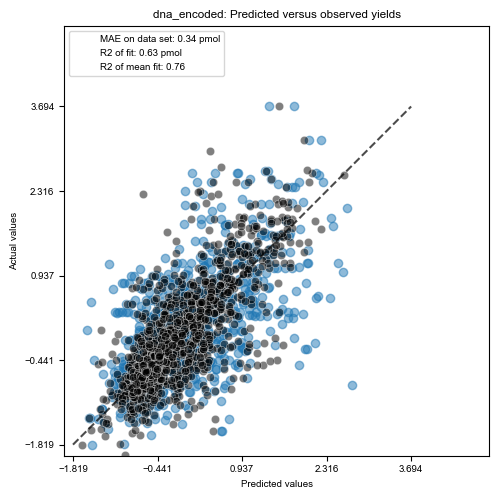

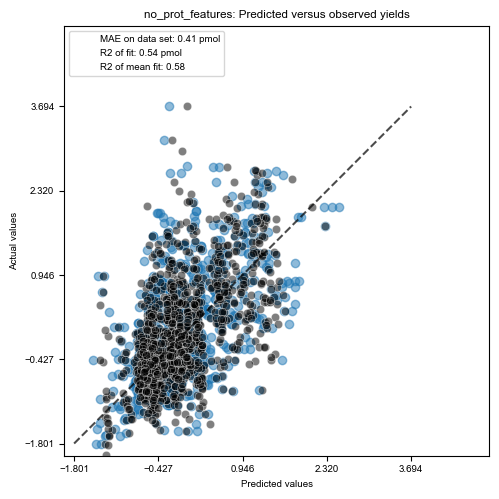

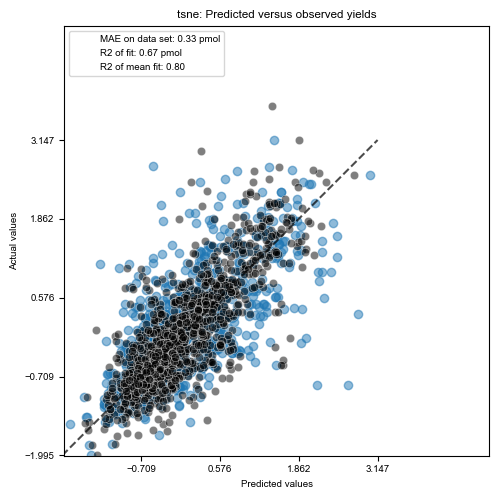

In [44]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

for ensemble,ensemble_df in pred_df.groupby('ensemble'):
    mae_train = median_absolute_error(ensemble_df['pmol_sub'], ensemble_df['pmol_sub_pred'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ensemble_df['pmol_sub'], ensemble_df['pmol_sub_pred'])
    
    t = ensemble_df.groupby(group_cols)[['pmol_sub','pmol_sub_pred']].agg(np.mean)
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t['pmol_sub'], t['pmol_sub_pred'])
    
    def abline(slope, intercept,ax):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, '--',color='red')
    # y_pred = model.predict(X_test[numerical_columns])
    # mae_test = median_absolute_error(y_test, y_pred)
    scores = {
        "MAE on data set": f"{mae_train:.2f} pmol",
        "R2 of fit": f"{r_value:.2f} pmol",
        "R2 of mean fit": f"{r_value_mean:.2f}",
    }

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        ensemble_df['pmol_sub'], ensemble_df['pmol_sub_pred'], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    sns.scatterplot(data=t,x='pmol_sub_pred',y='pmol_sub',color='black',alpha=0.5)
    
    # sns.scatterplot(data=test_converted,x='pmol_sub',y='pmol_sub_pred',alpha=0.05,ax=ax)
    ax.set_title(f"{ensemble}: Predicted versus observed yields")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    plt.tight_layout()
    # plt.plot([-5,25],[-5,25],color='black',ls='--')
    # abline(slope, intercept,ax)

    plt.xlim([-2,5])
    plt.ylim([-2,5])
    plt.show()

In [ ]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

scores = []

for [ensemble,dna],dna_df in calcs.groupby(['ensemble','DNA_name']):
    mae_train = median_absolute_error(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    
    t = dna_df.groupby(group_cols)[['pmol_sub','pmol_sub_pred']].agg('mean')
    mae_train_mean = median_absolute_error(t['pmol_sub'], t['pmol_sub_pred'])
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t['pmol_sub'], t['pmol_sub_pred'])
    scores.append([ensemble,dna,mae_train,r_value,mae_train_mean,r_value_mean])

scores_df = pd.DataFrame(scores,columns=['ensemble','DNA_name','mae','r_val','mae_mean','r_val_mean'])
scores_df

ensemble DNA_name   mae  r_val  mae_mean  r_val_mean
0   dna_encoded     AqpZ 0.246  0.790     0.158       0.886
1   dna_encoded      Aux 0.304  0.824     0.283       0.837
2   dna_encoded     B2AR 0.297  0.615     0.287       0.667
3   dna_encoded     B3AR 0.391  0.328     0.292       0.341
4   dna_encoded     Beta 0.374  0.724     0.315       0.768
..          ...      ...   ...    ...       ...         ...
79         tsne    OR1D2 0.434  0.548     0.434       0.534
80         tsne    OR1E1 0.446  0.622     0.359       0.709
81         tsne   OR2AG1 0.493  0.661     0.324       0.828
82         tsne  SecYE-G 0.273  0.769     0.145       0.895
83         tsne      Vol 0.145  0.951     0.136       0.967

[84 rows x 6 columns]

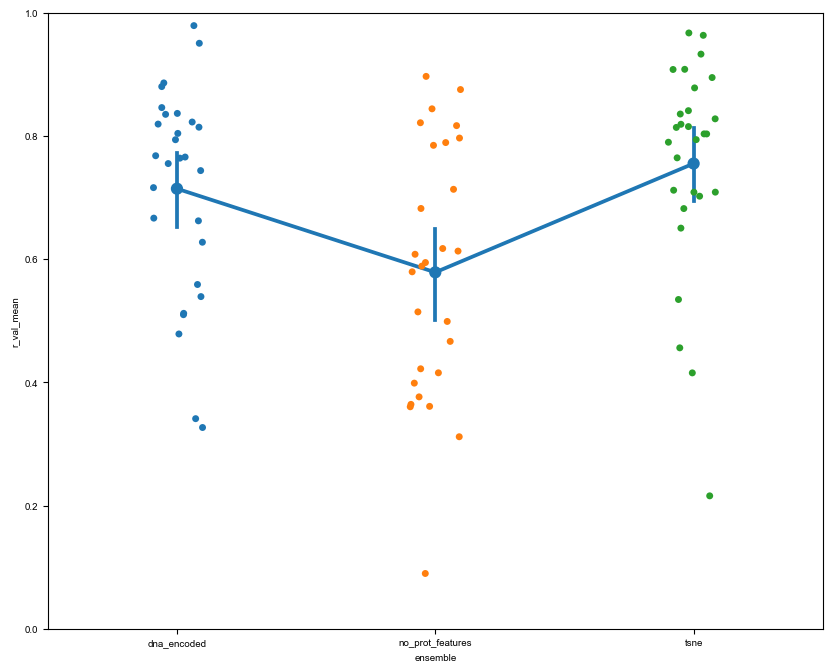

In [49]:
temp = scores_df[scores_df['ensemble'].isin(['dna_encoded','no_prot_features','tsne'])]

sns.stripplot(data=temp,x='ensemble',y='r_val_mean',order=['dna_encoded','no_prot_features','tsne'])
sns.pointplot(data=temp,x='ensemble',y='r_val_mean',order=['dna_encoded','no_prot_features','tsne'])
plt.ylim([0,1])
plt.show()

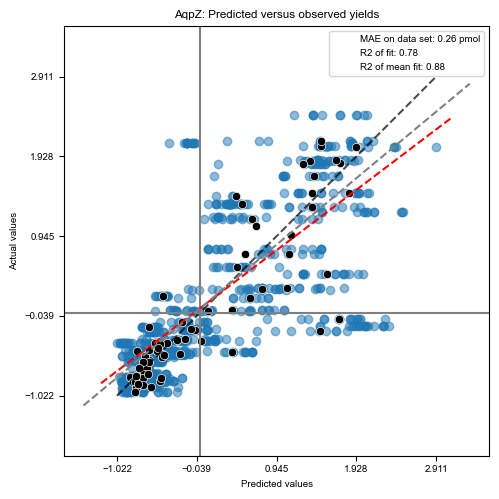

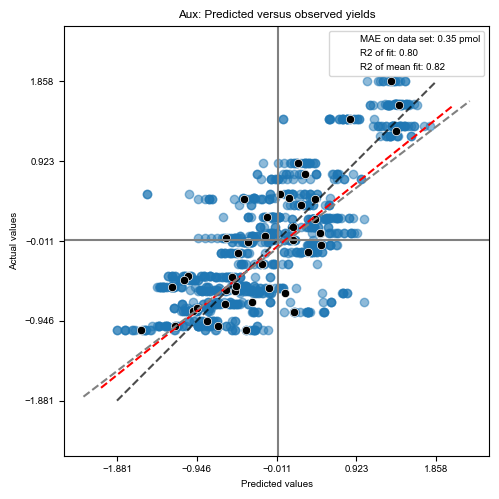

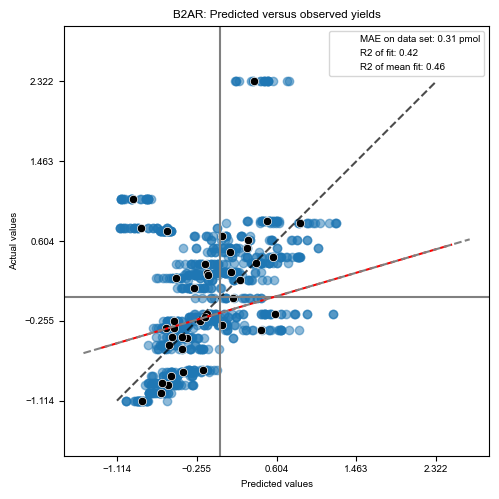

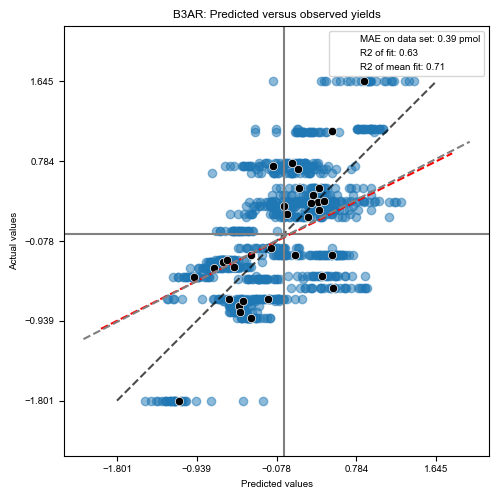

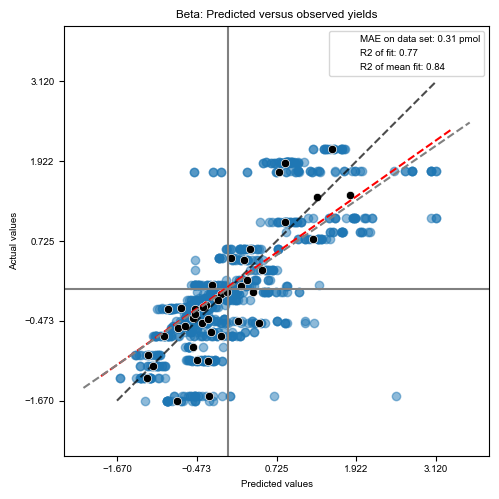

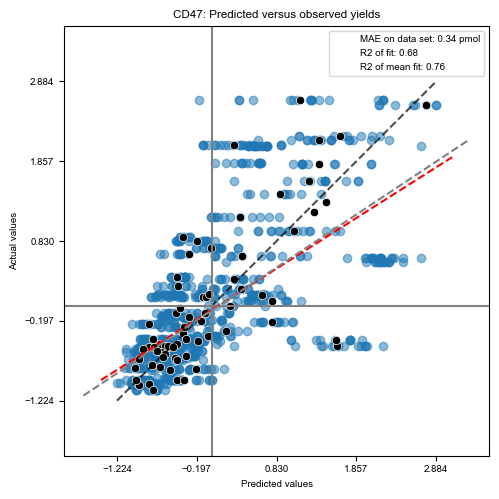

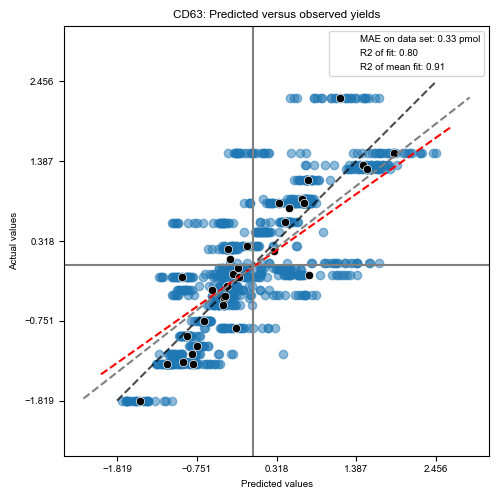

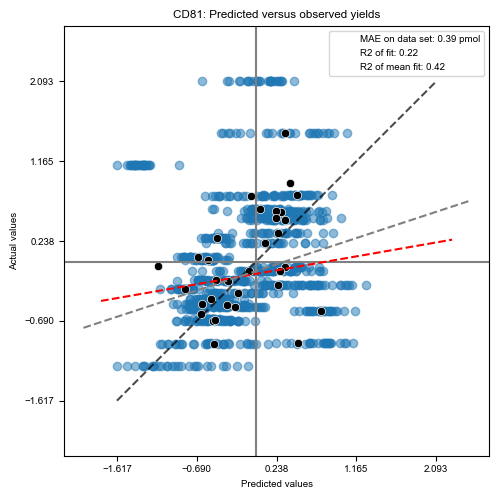

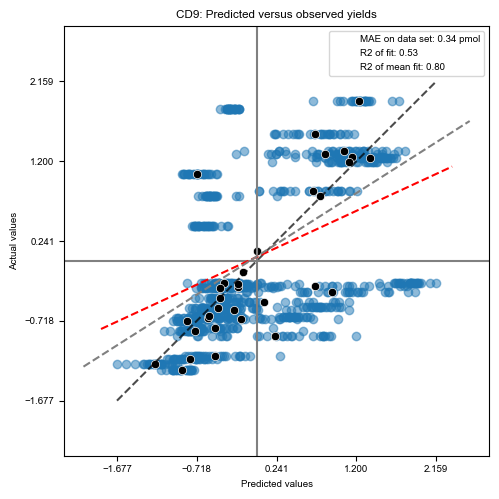

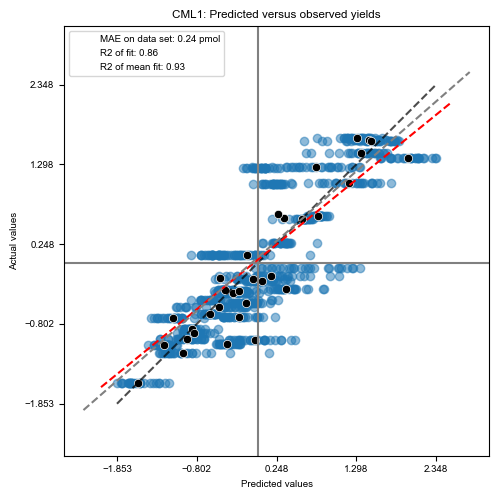

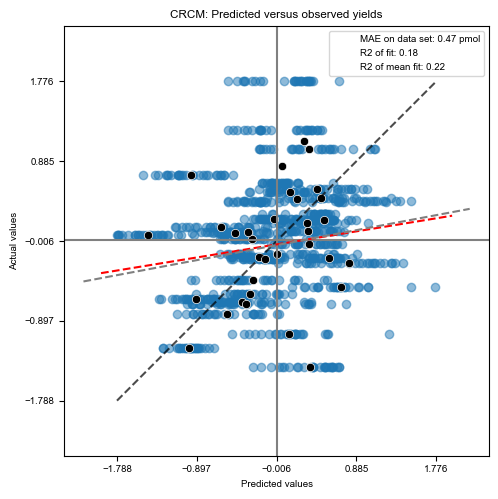

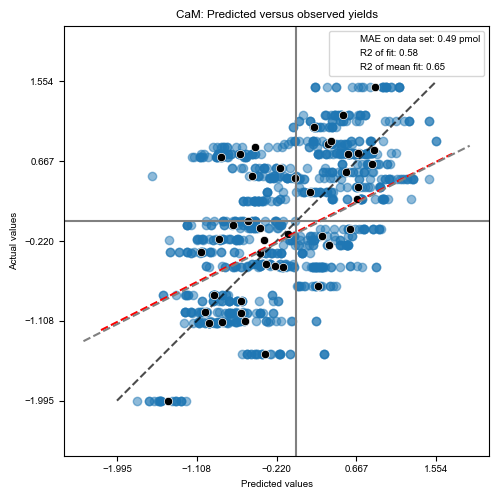

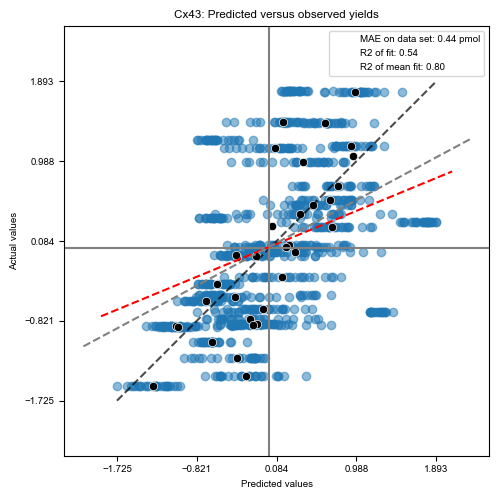

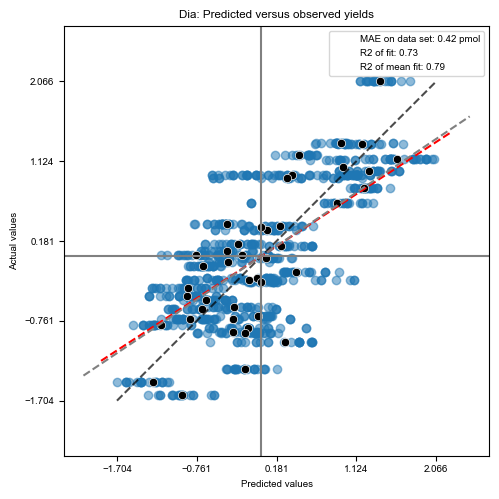

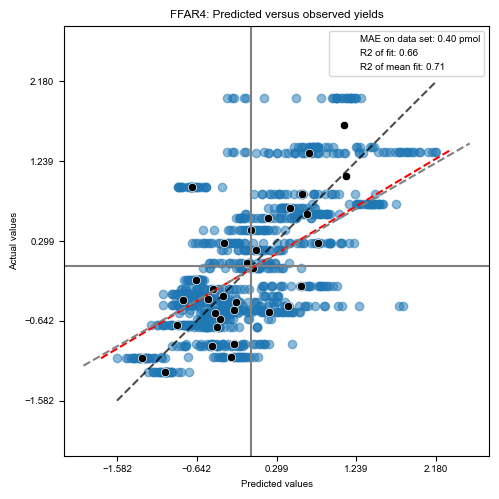

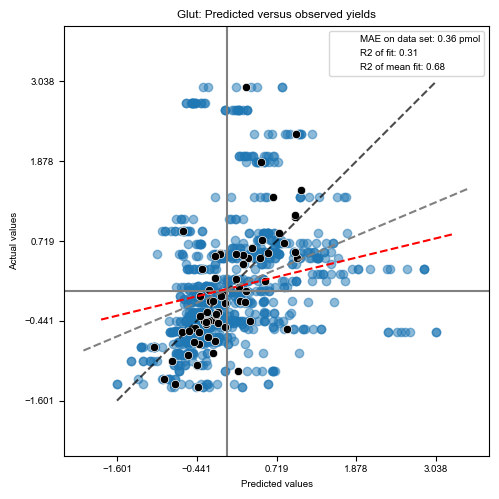

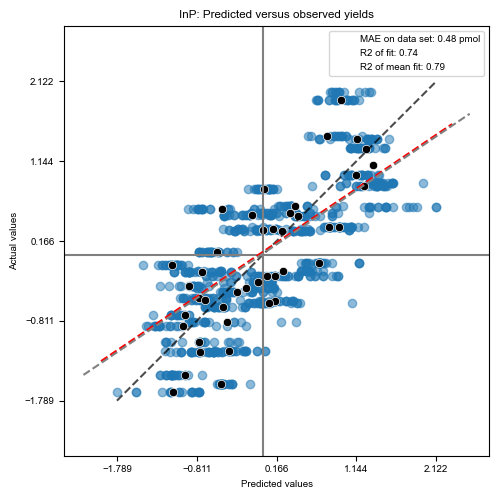

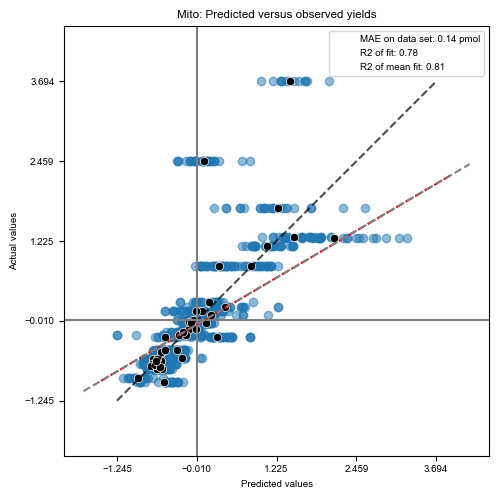

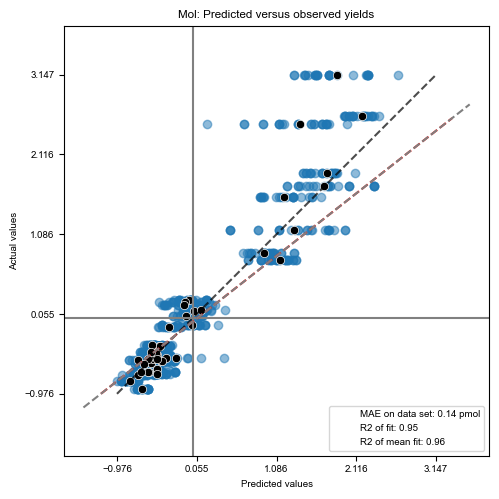

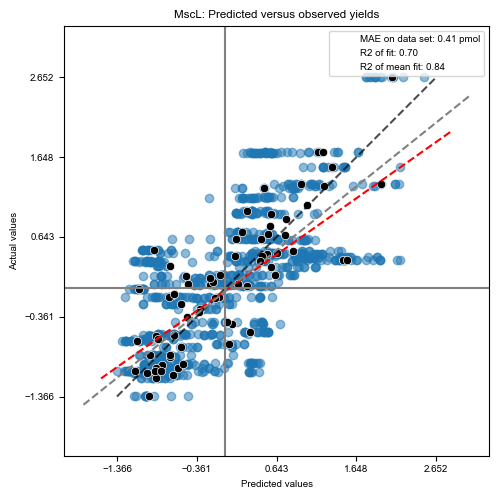

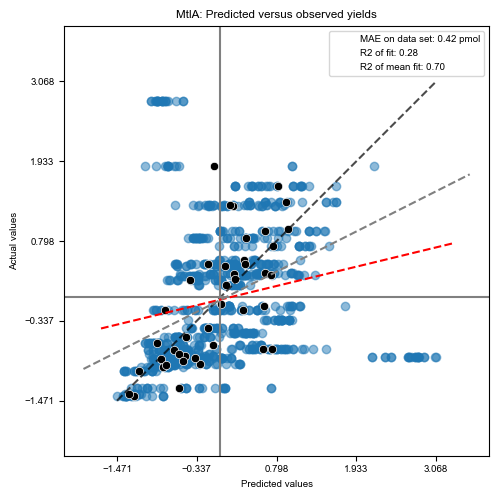

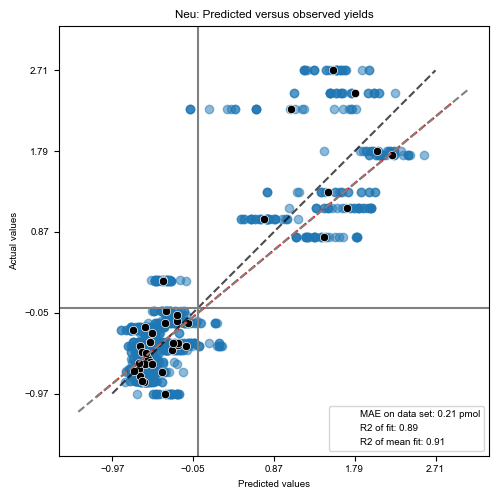

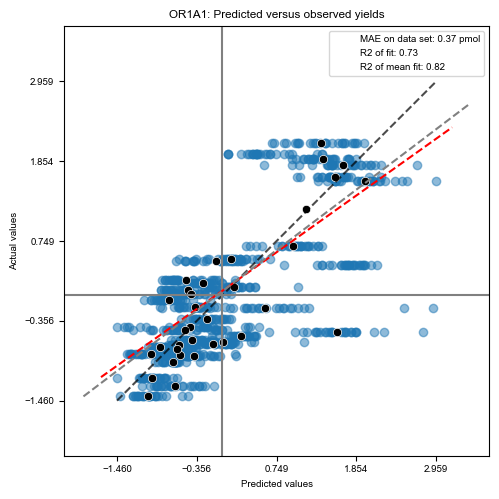

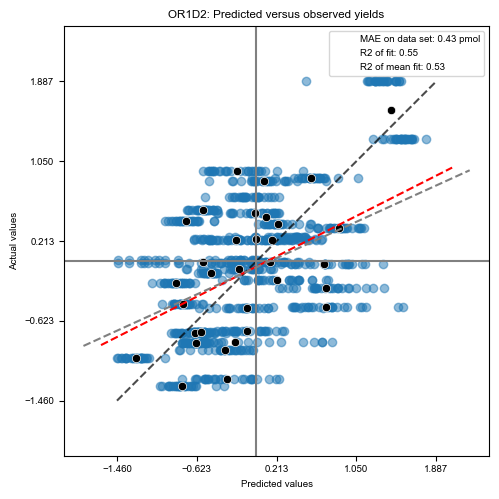

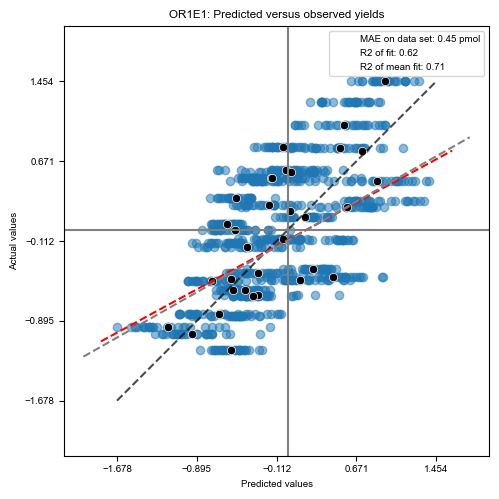

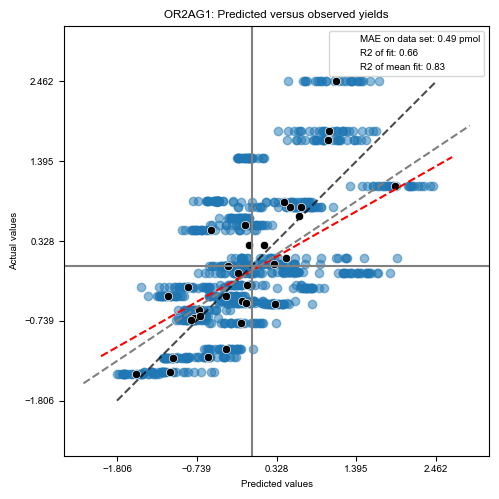

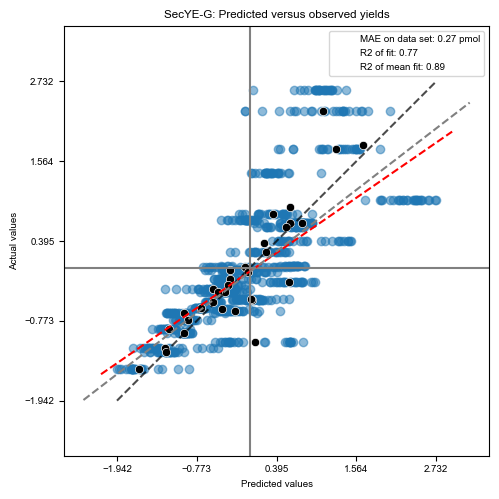

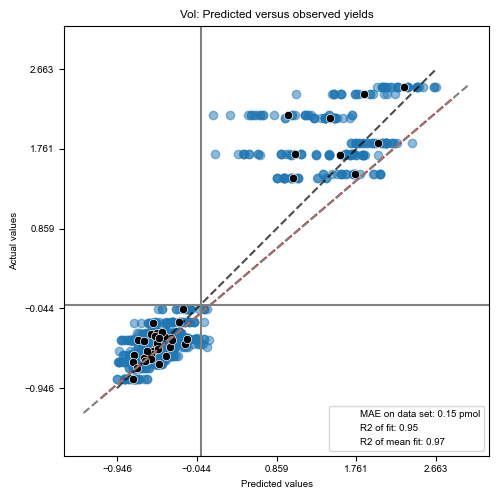

In [ ]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

for dna,dna_df in calcs[calcs['ensemble'] == 'tsne'].groupby('DNA_name'):
    mae_train = median_absolute_error(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    
    t = dna_df.groupby(group_cols)[['pmol_sub','pmol_sub_pred']].agg('mean')
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t['pmol_sub'], t['pmol_sub_pred'])
    
    def abline(slope, intercept,ax,color='red'):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + (slope * x_vals)
        ax.plot(x_vals, y_vals, '--',color=color)

    scores = {
        "MAE on data set": f"{mae_train:.2f} pmol",
        "R2 of fit": f"{r_value:.2f}",
        "R2 of mean fit": f"{r_value_mean:.2f}",
    }

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        dna_df['pmol_sub'], dna_df['pmol_sub_pred'], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    ax.set_title(f"{dna}: Predicted versus observed yields")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    plt.tight_layout()
    # plt.plot([-5,25],[-5,25],color='black',ls='--')
    plt.axvline(0,color='grey')
    plt.axhline(0,color='grey')
    abline(slope, intercept,ax)
    upper = round(np.max(dna_df['pmol_sub'])*1.25)+1
    lower = round(np.min(dna_df['pmol_sub'])*0.75)-1
    
    sns.scatterplot(data=t,x='pmol_sub_pred',y='pmol_sub',color='black')
    abline(slope_mean, intercept_mean,ax,color='grey')
    # plt.xlim([lower,upper])
    # plt.ylim([lower,upper])
    plt.show()

In [52]:
holdout_preds = []

for i,row in model_data.iterrows():
    temp = all_features[all_features['DNA_name'] == row['holdout']].copy()
    # temp = temp_all[temp_all['rxn_id'].isin(fold_dict[model_data.iloc[0]['fold']]['test'])].copy()
    temp_norm = norm_data[norm_data['DNA_name'] == row['holdout']].copy()
    # temp_norm = temp_norm[temp_norm['rxn_id'].isin(fold_dict[model_data.iloc[0]['fold']]['test'])]
    preds = model_dict[row['model_id']].predict(temp_norm[row['cols']])
    temp['pred'] = preds
    temp['model_id'] = row['model_id']
    temp['ensemble'] = row['ensemble']
    temp['holdout'] = row['holdout']
    holdout_preds.append(temp)
    
holdout_preds = pd.concat(holdout_preds).reset_index(drop=True)

holdout_converted = []

for dna,dna_df in holdout_preds.groupby('DNA_name'):
    temp = dna_df.copy()
    temp['pmol_sub_pred'] = scaler_dict[dna].inverse_transform(np.array(temp[['pred']]))
    temp['label'] = scaler_dict[dna].transform(np.array(temp[['pmol']]))
    holdout_converted.append(temp)
    
holdout_converted = pd.concat(holdout_converted).reset_index(drop=True)
holdout_converted

7/7 [==============================] - 0s 1ms/step


DNA_name   rxn_id  lipid     Mg  SecYE    K   PEG  pmol uniprot  \
0         AqpZ    0.000     14  8.000  0.000   85 2.000 4.918  P60844   
1         AqpZ    0.000     14  8.000  0.000   85 2.000 4.311  P60844   
2         AqpZ    0.000     14  8.000  0.000   85 2.000 2.644  P60844   
3         AqpZ    0.000     14  8.000  0.000   85 2.000 7.546  P60844   
4         AqpZ    0.000     14  8.000  0.000   85 2.000 7.527  P60844   
...        ...      ...    ...    ...    ...  ...   ...   ...     ...   
82585      Vol 3966.000     18 20.000  1.250  135 2.000 1.240  Q5JW98   
82586      Vol 3966.000     18 20.000  1.250  135 2.000 1.230  Q5JW98   
82587      Vol 3966.000     18 20.000  1.250  135 2.000 1.726  Q5JW98   
82588      Vol 3966.000     18 20.000  1.250  135 2.000 1.145  Q5JW98   
82589      Vol 3966.000     18 20.000  1.250  135 2.000 0.972  Q5JW98   

         Organism  ...  DNA_name-SecYE-G  DNA_name-Vol  tsne_x  tsne_y   pred  \
0         E. coli  ...             0.000         0.000   0.865   1.166 -0.444   
1         E. coli  ...             0.000         0.000   0.865   1.166 -0.444   
2         E. coli  ...             0.000         0.000   0.865   1.166 -0.444   
3         E. coli  ...             0.000         0.000   0.865   1.166 -0.444   
4         E. coli  ...             0.000         0.000   0.865   1.166 -0.444   
...           ...  ...               ...           ...     ...     ...    ...   
82585  H. sapiens  ...             0.000         1.000   1.234   0.377 -0.652   
82586  H. sapiens  ...             0.000         1.000   1.234   0.377 -0.652   
82587  H. sapiens  ...             0.000         1.000   1.234   0.377 -0.652   
82588  H. sapiens  ...             0.000         1.000   1.234   0.377 -0.652   
82589  H. sapiens  ...             0.000         1.000   1.234   0.377 -0.652   

       model_id          ensemble  holdout  pmol_sub_pred  label  
0             0  no_prot_features     AqpZ          5.816 -0.570  
1             0  no_prot_features     AqpZ          5.816 -0.656  
2             0  no_prot_features     AqpZ          5.816 -0.891  
3             0  no_prot_features     AqpZ          5.816 -0.201  
4             0  no_prot_features     AqpZ          5.816 -0.203  
...         ...               ...      ...            ...    ...  
82585       419              tsne      Vol          1.244 -0.656  
82586       419              tsne      Vol          1.244 -0.665  
82587       419              tsne      Vol          1.244 -0.194  
82588       419              tsne      Vol          1.244 -0.745  
82589       419              tsne      Vol          1.244 -0.910  

[82590 rows x 52 columns]

In [53]:
holdout_converted['pmol_sub'] = holdout_converted['label']
holdout_converted['pmol_sub_pred'] = holdout_converted['pred']

In [ ]:
holdout_df = holdout_converted.groupby(['rxn_id','ensemble','model_id','DNA_name']).agg('mean').reset_index()
holdout_df = holdout_df.set_index(['ensemble','model_id']).join(model_data.set_index(['ensemble','model_id'])).reset_index()

C:\Users\conar\AppData\Local\Temp\ipykernel_2444\4707909.py:1: FutureWarning: The operation <function mean at 0x0000025F383B4A60> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  holdout_df = holdout_converted.groupby(['rxn_id','ensemble','model_id','DNA_name']).agg(np.mean).reset_index()


In [55]:
holdout_df

ensemble  model_id   rxn_id DNA_name  lipid     Mg  SecYE       K  \
0      dna_encoded         5    0.000     AqpZ 14.000  8.000  0.000  85.000   
1      dna_encoded         5    1.000     AqpZ 14.000  8.000  0.000  85.000   
2      dna_encoded         5    2.000     AqpZ 14.000  8.000  0.000  85.000   
3      dna_encoded         5    3.000     AqpZ 14.000  8.000  0.000 135.000   
4      dna_encoded         5    4.000     AqpZ 14.000  8.000  0.000 135.000   
...            ...       ...      ...      ...    ...    ...    ...     ...   
18760         tsne       419 3953.000      Vol 18.000 20.000  0.000 135.000   
18761         tsne       419 3954.000      Vol 18.000 20.000  0.000 185.000   
18762         tsne       419 3964.000      Vol 18.000 20.000  0.625 185.000   
18763         tsne       419 3965.000      Vol 18.000 20.000  1.250  85.000   
18764         tsne       419 3966.000      Vol 18.000 20.000  1.250 135.000   

        PEG   pmol  ...  label  pmol_sub  holdout  fold  batch  learning_rate  \
0     2.000  5.389  ... -0.504    -0.504     AqpZ     0     50          0.001   
1     0.000 11.141  ...  0.305     0.305     AqpZ     0     50          0.001   
2     2.000  7.279  ... -0.238    -0.238     AqpZ     0     50          0.001   
3     2.000  5.387  ... -0.504    -0.504     AqpZ     0     50          0.001   
4     0.000 12.344  ...  0.475     0.475     AqpZ     0     50          0.001   
...     ...    ...  ...    ...       ...      ...   ...    ...            ...   
18760 2.000  1.313  ... -0.586    -0.586      Vol     4     50          0.001   
18761 0.000  3.725  ...  1.705     1.705      Vol     4     50          0.001   
18762 0.000  3.715  ...  1.695     1.695      Vol     4     50          0.001   
18763 2.000  1.530  ... -0.380    -0.380      Vol     4     50          0.001   
18764 2.000  1.263  ... -0.634    -0.634      Vol     4     50          0.001   

                             nodes  \
0      [512, 256, 128, 64, 32, 16]   
1      [512, 256, 128, 64, 32, 16]   
2      [512, 256, 128, 64, 32, 16]   
3      [512, 256, 128, 64, 32, 16]   
4      [512, 256, 128, 64, 32, 16]   
...                            ...   
18760  [512, 256, 128, 64, 32, 16]   
18761  [512, 256, 128, 64, 32, 16]   
18762  [512, 256, 128, 64, 32, 16]   
18763  [512, 256, 128, 64, 32, 16]   
18764  [512, 256, 128, 64, 32, 16]   

                                                    cols  \
0      [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
1      [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
2      [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
3      [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
4      [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
...                                                  ...   
18760         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18761         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18762         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18763         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18764         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   

                                                test_ids  \
0      [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
1      [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
2      [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
3      [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
4      [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
...                                                  ...   
18760  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   
18761  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   
18762  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   
18763  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   
18764  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   

                                               train_ids  
0      [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....  
1      [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....  
2      [2793

In [ ]:
# real_values = sub_df[['DNA_name','Mg','K','SecYE','PEG','Liposome_name','label','mean_diff','score']].drop_duplicates()
real_values = sub_df[sub_df['label'] == 'screen'][['DNA_name','Mg','K','SecYE','PEG','Liposome_name','label','mean_diff','score']].drop_duplicates()
lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14}

real_values['lipid'] = real_values['Liposome_name'].apply(lambda x: lipo_dict[x])
real_values = real_values.drop(columns=['Liposome_name'])
real_values = real_values.groupby(['DNA_name','Mg','K','SecYE','PEG','lipid']).agg('mean').reset_index()
real_values
# # holdout_calcs = holdout_calcs.set_index(['DNA_name','Mg','K','SecYE','PEG','lipid']).join(real_values.set_index(['DNA_name','Mg','K','SecYE','PEG','lipid'])).reset_index().dropna()
holdout_df = holdout_df.set_index(['DNA_name','Mg','K','SecYE','PEG','lipid']).join(real_values.set_index(['DNA_name','Mg','K','SecYE','PEG','lipid'])).reset_index().dropna()
holdout_df

C:\Users\conar\AppData\Local\Temp\ipykernel_2444\1054427489.py:7: FutureWarning: The operation <function mean at 0x0000025F383B4A60> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  real_values = real_values.groupby(['DNA_name','Mg','K','SecYE','PEG','lipid']).agg(np.mean).reset_index()


DNA_name     Mg       K  SecYE   PEG  lipid     ensemble  model_id  \
15        AqpZ  8.000  85.000  0.000 0.000 18.000  dna_encoded         5   
16        AqpZ  8.000  85.000  0.000 0.000 18.000  dna_encoded         5   
17        AqpZ  8.000  85.000  0.000 0.000 18.000  dna_encoded         6   
18        AqpZ  8.000  85.000  0.000 0.000 18.000  dna_encoded         6   
19        AqpZ  8.000  85.000  0.000 0.000 18.000  dna_encoded         7   
...        ...    ...     ...    ...   ...    ...          ...       ...   
18730      Vol 20.000 135.000  1.250 2.000 18.000         tsne       415   
18731      Vol 20.000 135.000  1.250 2.000 18.000         tsne       416   
18732      Vol 20.000 135.000  1.250 2.000 18.000         tsne       417   
18733      Vol 20.000 135.000  1.250 2.000 18.000         tsne       418   
18734      Vol 20.000 135.000  1.250 2.000 18.000         tsne       419   

        rxn_id   pmol  ...  holdout  fold  batch  learning_rate  \
15      35.000 23.824  ...     AqpZ     0     50          0.001   
16      37.000  7.785  ...     AqpZ     0     50          0.001   
17      35.000 23.824  ...     AqpZ     1     50          0.001   
18      37.000  7.785  ...     AqpZ     1     50          0.001   
19      35.000 23.824  ...     AqpZ     2     50          0.001   
...        ...    ...  ...      ...   ...    ...            ...   
18730 3966.000  1.263  ...      Vol     0     50          0.001   
18731 3966.000  1.263  ...      Vol     1     50          0.001   
18732 3966.000  1.263  ...      Vol     2     50          0.001   
18733 3966.000  1.263  ...      Vol     3     50          0.001   
18734 3966.000  1.263  ...      Vol     4     50          0.001   

                             nodes  \
15     [512, 256, 128, 64, 32, 16]   
16     [512, 256, 128, 64, 32, 16]   
17     [512, 256, 128, 64, 32, 16]   
18     [512, 256, 128, 64, 32, 16]   
19     [512, 256, 128, 64, 32, 16]   
...                            ...   
18730  [512, 256, 128, 64, 32, 16]   
18731  [512, 256, 128, 64, 32, 16]   
18732  [512, 256, 128, 64, 32, 16]   
18733  [512, 256, 128, 64, 32, 16]   
18734  [512, 256, 128, 64, 32, 16]   

                                                    cols  \
15     [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
16     [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
17     [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
18     [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
19     [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
...                                                  ...   
18730         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18731         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18732         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18733         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   
18734         [Mg, SecYE, K, PEG, lipid, tsne_x, tsne_y]   

                                                test_ids  \
15     [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
16     [2831.0, 2998.0, 1217.0, 2621.0, 3562.0, 3039....   
17     [2793.0, 1528.0, 1900.0, 3401.0, 530.0, 2412.0...   
18     [2793.0, 1528.0, 1900.0, 3401.0, 530.0, 2412.0...   
19     [1889.0, 1370.0, 3602.0, 1580.0, 1884.0, 3530....   
...                                                  ...   
18730  [2307.0, 3332.0, 1883.0, 660.0, 178.0, 2801.0,...   
18731  [2997.0, 205.0, 540.0, 1302.0, 543.0, 2342.0, ...   
18732  [2942.0, 2382.0, 2434.0, 1891.0, 1403.0, 3076....   
18733  [544.0, 2831.0, 158.0, 1004.0, 2306.0, 1538.0,...   
18734  [1799.0, 561.0, 2109.0, 1743.0, 2793.0, 3600.0...   

                                               train_ids  mean_diff  score  
15     [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....      4.577  1.000  
16     [2793.0, 1889.0, 1887.0, 3917.0, 1528.0, 1370....      4.577  1.000  
17     [2831.0, 1889.0, 1887.0, 3917.0, 2998.0, 1370....      4.577  1.000  
18     [2831.0, 1889.0, 1887.0, 3917.0, 2998.0, 1370....      4.577  1.000  
19  

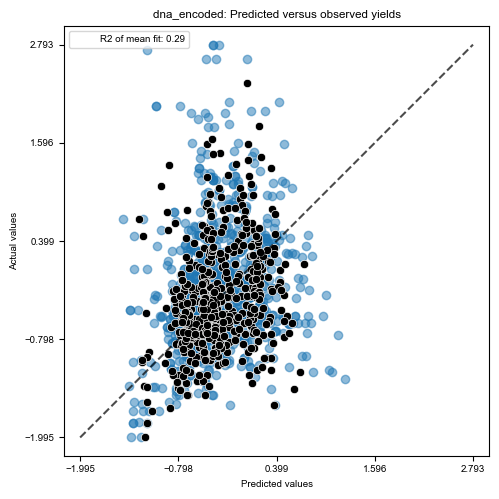

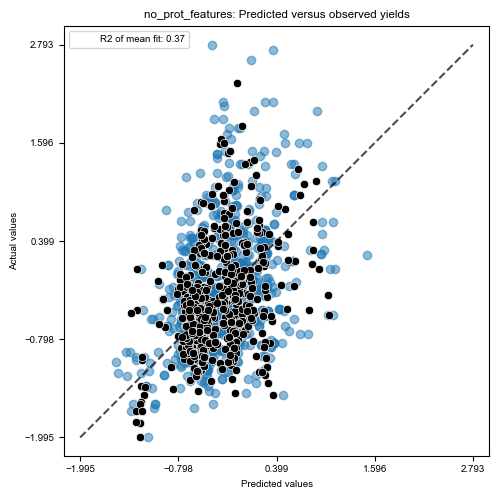

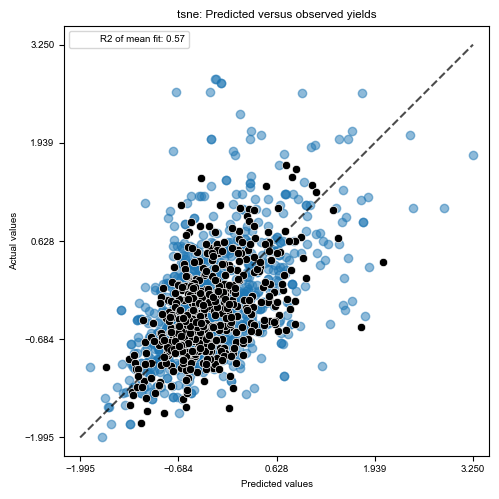

In [ ]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

for ensemble, ens_df in holdout_df.groupby('ensemble'):
    t = ens_df.groupby(group_cols)[['pmol_sub','pmol_sub_pred']].agg('mean')
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t['pmol_sub'], t['pmol_sub_pred'])

    def abline(slope, intercept,ax,color='red'):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axes.get_xlim())
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals, y_vals, '--',color=color)
    # y_pred = model.predict(X_test[numerical_columns])
    # mae_test = median_absolute_error(y_test, y_pred)
    scores = {
        # "MAE on data set": f"{mae_train:.2f} pmol",
        # "R2 of fit": f"{r_value:.2f} pmol",
        "R2 of mean fit": f"{r_value_mean:.2f}",
    }

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        ens_df['pmol_sub'], ens_df['pmol_sub_pred'], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    sns.scatterplot(data=t.sample(500),x='pmol_sub_pred',y='pmol_sub',color='black')
    # abline(slope_mean, intercept_mean,ax,color='grey')

    # sns.scatterplot(data=test_converted,x='pmol_sub',y='pmol_sub_pred',alpha=0.05,ax=ax)
    ax.set_title(f"{ensemble}: Predicted versus observed yields")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    plt.tight_layout()
    # plt.plot([-5,25],[-5,25],color='black',ls='--')
    # abline(slope, intercept,ax)

    # plt.xlim([-2,5])
    # plt.ylim([-2,5])
    plt.show()

In [ ]:
group_cols = ['ensemble','DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

means = holdout_df.groupby(group_cols).agg('mean')[['pmol_sub_pred']]
stdevs = holdout_df.groupby(group_cols).agg('std')[['pmol_sub_pred']]
calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev')


C:\Users\conar\AppData\Local\Temp\ipykernel_2444\2818297440.py:3: FutureWarning: The operation <function mean at 0x0000025F383B4A60> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  means = holdout_df.groupby(group_cols).agg(np.mean)[['pmol_sub_pred']]
C:\Users\conar\AppData\Local\Temp\ipykernel_2444\2818297440.py:4: FutureWarning: The operation <function std at 0x0000025F383B4C10> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  stdevs = holdout_df.groupby(group_cols).agg(np.std)[['pmol_sub_pred']]


C:\Users\conar\AppData\Local\Temp\ipykernel_2444\4027412989.py:1: FutureWarning: The operation <function mean at 0x0000025F383B4A60> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  holdout_df = holdout_converted.groupby(['rxn_id','ensemble','model_id','DNA_name']).agg(np.mean).reset_index()
C:\Users\conar\AppData\Local\Temp\ipykernel_2444\4027412989.py:5: FutureWarning: The operation <function std at 0x0000025F383B4C10> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  stdevs = holdout_df.groupby(['ensemble','rxn_id']).agg(np.std)[['pmol_sub_pred']]
C:\Users\conar\AppData\Local\Temp\ipykernel_2444\4027412989.py:6: FutureWarning: The operation <function mean at 0x0000025F383B4A60> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop thes

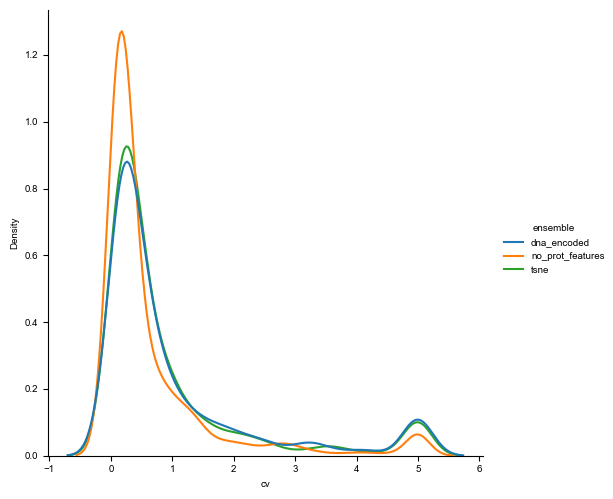

In [ ]:
holdout_df = holdout_converted.groupby(['rxn_id','ensemble','model_id','DNA_name']).agg('mean').reset_index()
holdout_df = holdout_df.set_index(['ensemble','model_id']).join(model_data.set_index(['ensemble','model_id'])).reset_index()
holdout_df = holdout_df.set_index(['DNA_name','Mg','K','SecYE','PEG','lipid']).join(real_values.set_index(['DNA_name','Mg','K','SecYE','PEG','lipid'])).reset_index().dropna()

stdevs = holdout_df.groupby(['ensemble','rxn_id']).agg('std')[['pmol_sub_pred']]
means = holdout_df.groupby(['ensemble','rxn_id']).agg('mean')[['pmol_sub_pred']]
calcs = means.join(stdevs,rsuffix='_stdev',lsuffix='_mean')
calcs['cv'] = abs(calcs['pmol_sub_pred_stdev'] / calcs['pmol_sub_pred_mean'])
# cvs.describe()
calcs['cv'] = calcs['cv'].clip(0,5)

calcs = holdout_df.set_index(['ensemble','rxn_id']).join(calcs).reset_index()

sns.displot(data=calcs,x='cv',hue='ensemble',kind='kde',common_norm=False)
plt.show()

In [ ]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

scores = []

for [ensemble,dna],dna_df in calcs.groupby(['ensemble','DNA_name']):
    mae_train = median_absolute_error(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    
    t = dna_df.groupby(group_cols)[['pmol_sub','pmol_sub_pred']].agg('mean')
    mae_train_mean = median_absolute_error(t['pmol_sub'], t['pmol_sub_pred'])
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t['pmol_sub'], t['pmol_sub_pred'])
    scores.append([ensemble,dna,mae_train,r_value,mae_train_mean,r_value_mean])

scores_df = pd.DataFrame(scores,columns=['ensemble','DNA_name','mae','r_val','mae_mean','r_val_mean'])
scores_df

ensemble DNA_name   mae  r_val  mae_mean  r_val_mean
0   dna_encoded     AqpZ 0.330  0.258     0.340       0.313
1   dna_encoded      Aux 0.430  0.429     0.327       0.445
2   dna_encoded     B2AR 0.375  0.498     0.416       0.553
3   dna_encoded     B3AR 0.414  0.507     0.391       0.565
4   dna_encoded     Beta 0.365  0.458     0.350       0.510
..          ...      ...   ...    ...       ...         ...
79         tsne    OR1D2 0.561  0.459     0.537       0.432
80         tsne    OR1E1 0.416  0.679     0.384       0.729
81         tsne   OR2AG1 0.472  0.484     0.419       0.593
82         tsne  SecYE-G 0.257  0.777     0.273       0.815
83         tsne      Vol 0.162  0.418     0.118       0.487

[84 rows x 6 columns]

In [61]:
scores_df.value_counts(['ensemble'])

ensemble        
dna_encoded         28
no_prot_features    28
tsne                28
dtype: int64

In [66]:
low = ['B3AR','CML1','CRCM','Cx43','FFAR4','Neu','OR1D2','OR1E1','OR2AG1','Vol']


In [85]:
t = scores_df[scores_df['ensemble'].isin(['dna_encoded','no_prot_features','tsne'])]
# t = t[~t['DNA_name'].isin(low)]

dna = t[t['ensemble'] == 'dna_encoded']
no_prot = t[t['ensemble'] == 'no_prot_features']
perp = t[t['ensemble'] == 'tsne']

perp_dna = ttest_ind(perp['r_val_mean'],dna['r_val_mean'])[1]
per_diff = (perp['r_val_mean'].mean() - dna['r_val_mean'].mean()) / dna['r_val_mean'].mean() *100
print(f'tsne-_no_dna - p-val:{perp_dna}   diff:{per_diff}%')

perp_no = ttest_ind(perp['r_val_mean'],no_prot['r_val_mean'])[1]
per_diff = (perp['r_val_mean'].mean() - no_prot['r_val_mean'].mean()) / no_prot['r_val_mean'].mean() *100
print(f'tsne-no_prot - p-val:{perp_no}   diff:{per_diff}%')

no_dna = ttest_ind(no_prot['r_val_mean'],dna['r_val_mean'])[1]
per_diff = (no_prot['r_val_mean'].mean() - dna['r_val_mean'].mean()) / dna['r_val_mean'].mean() *100
print(f'no_prot-dna - p-val:{no_dna}   diff:{per_diff}%')

tsne-_no_dna - p-val:0.00016134515097184488   diff:64.61720165046405%
tsne-no_prot - p-val:0.0047181884036970705   diff:37.531098370792776%
no_prot-dna - p-val:0.18983311160663208   diff:19.694529892174195%


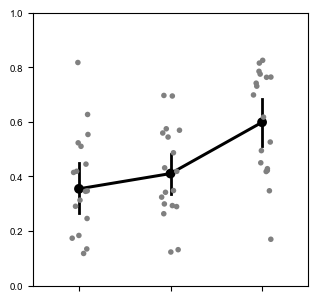

In [ ]:
temp = scores_df[scores_df['ensemble'].isin(['dna_encoded','no_prot_features','tsne'])]
temp = temp[~temp['DNA_name'].isin(low)]

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

sns.stripplot(data=temp,x='ensemble',y='r_val_mean',order=['dna_encoded','no_prot_features','tsne'],s=4,color='grey')
sns.pointplot(data=temp,x='ensemble',y='r_val_mean',order=['dna_encoded','no_prot_features','tsne'],scale=0.8,errwidth=2,color='black')

plt.ylim([0,1])
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=[])
# plt.savefig(f'{fig_folder}/Fig4B-ensemble_comparison_high_0to1.svg',format='svg',dpi=300)
plt.show()

# temp.set_index('ensemble').to_excel(f'{data_folder}/Fig4B-ensemble_R2_values.xlsx')